In [1]:
# Install all libraries needed for producing plots that are not already available in the Object
# Detection Docker image.

# !pip install --upgrade pip
# !pip install seaborn
# !pip install sklearn
# !pip install geopandas
# !pip install shapely
# !pip install fiona
# !pip install descartes
# !pip install statsmodels
# !pip install pingouin
# !pip install squarify
# !apt install libspatialindex-dev python3-rtree -y
# !pip3 install Rtree
# !pip3 install geopy
!pip3 install tqdm

     |████████████████████████████████| 78 kB 5.6 MB/s             
  Attempting uninstall: zipp
    Found existing installation: zipp 0.6.0
    Uninstalling zipp-0.6.0:
      Successfully uninstalled zipp-0.6.0


In [2]:
# Import relevant libraries

import os
import sys
import math
sys.path.append("../..")
import ast
import datetime
import glob
import re
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator,\
   DayLocator, MONDAY
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns
import scipy as sp
from sklearn import linear_model
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
import pingouin as pg
import squarify
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.ops import nearest_points
import rtree
import geopandas

from scipy.stats import entropy
from scipy import stats
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
# Create array of category names as they appear in the detections data. See paper for details of each category.
categories = ['car', 'person', 'trotro', 'stall', 'truck', 'stove', 'motorcycle', 'vendor', 'lorry', 'umbrella', 'bus', 'trash', 'taxi', 'van', 'debris', 'loudspeaker', 'bowl', 'food', 'animal', 'bicycle']

# Column names in the data frame for the number of counts of each category type in an image.
count_cols = [cat+'_counts' for cat in categories]

In [6]:
# Structure for organising each site and the cameras at each site.

# Long term sites 
site_cams = {'AD' : ['C4', 'C17', 'C12', 'C14'],
             'ASH' : ['C6', 'C13'],
             'EL' : ['C12', 'C32', 'C01', 'C8', 'C18', 'C28', 'C10'],
             'JT' : ['C31', 'C21', 'C11', 'C9'],
             'LA' : ['C16', 'C35'],
             'N1West' : ['C36', 'C15', 'C33'],
             'Nima' : ['C2', 'C27','C13', 'C26'],
             'Taifa' : ['C21', 'C22'],
             'TMW' : ['C30', 'C19'],
             'UGH' : ['C5','C12','C23','C33','C25']}

dirs = []

# Short term sites
sitelist = [x[:x.index('_')] for x in os.listdir('results/detections_data/') if (x[0] == 'S')]

sitelist.remove('S101')
sitelist.remove('S101')
sitelist.remove('S74')

for site in sitelist:
    cams = ['C'+re.search('C(\d+)', x).group(1) for x in os.listdir('results/detections_data/') if ((x[:len(site)+1] == site+'_'))]
    site_cams[site] = []
    for cam in cams:
        site_cams[site].append(cam)

In [7]:
#If you need to continue the analysis later but don't wish to redo all the file reading, uncomment the "dump" command below to save the existing, processed object data and resume later with the "load" command

# pickle.dump( object_data, open( "object_data_release.p", "wb" ) )
object_data = pickle.load(open("notebooks/object_data_release.p", "rb" ))

FileNotFoundError: [Errno 2] No such file or directory: 'notebooks/object_data_release.p'

In [6]:
vehicle_categories = ['car', 'trotro', 'truck', 'motorcycle', 'lorry', 'bus', 'taxi', 'van', 'bicycle']

super_categories = {'people' : ['person','vendor'],
                    'small_vehicles' : ['car', 'taxi','truck'],
                    'two_wheelers' : ['bicycle', 'motorcycle'],
                    'large_vehicles' : ['trotro', 'van', 'lorry','bus'],
                    'refuse' : ['trash', 'debris'],
                    'market': ['umbrella','stall','bowl','food'],
                    'paratransit': ['taxi','trotro']}

# for site in site_cams:
#     for cam in site_cams[site]:
#         object_data[site][cam]['vehicle_counts'] = 0
#         object_data[site][cam]['hour'] = object_data[site][cam].index.strftime("%H")
#         for vehicle in vehicle_categories:
#             object_data[site][cam]['vehicle_counts'] += object_data[site][cam][vehicle+'_counts']
#         for super_category in super_categories:
#             object_data[site][cam][super_category+'_counts'] = 0
#             for cat in super_categories[super_category]:
#                 object_data[site][cam][super_category+'_counts'] += object_data[site][cam][cat+'_counts']
    

In [7]:
# Produce some relevant metadata regarding the imagery used in this analysis

print("Number of rotating sites: "+str(len([site for site in site_cams if site[0] == 'S'])))
print("Number of fixes sites: "+str(len([site for site in site_cams if site[0] != 'S'])))

rotating_len=0
fixed_len=0
rotating_obj_sum=0
fixed_obj_sum=0
two_cam_rotating_sites=0
one_cam_rotating_sites=0
for site in site_cams:
    if(site.lower()[0] == 's'):
        if(len(site_cams[site]) == 1):
            one_cam_rotating_sites+=1
        else:
            two_cam_rotating_sites+=1
    for cam in site_cams[site]:
        if(site.lower()[0] == 's'):
            rotating_len+=len(object_data[site][cam])
            rotating_obj_sum+=object_data[site][cam][[cat+'_counts' for cat in categories]].sum().sum()
        else:
            fixed_len+=len(object_data[site][cam])
            fixed_obj_sum+=object_data[site][cam][[cat+'_counts' for cat in categories]].sum().sum()

print("Number of images: "+str(fixed_len+rotating_len))
print("Number of objects: "+str(rotating_obj_sum+fixed_obj_sum))
print("Number of rotating sites images: "+str(rotating_len))
print("Number of rotating sites objects: "+str(rotating_obj_sum))
print("Number of fixed sites images: "+str(fixed_len))
print("Number of fixed sites objects: "+str(fixed_obj_sum))
print("Number of one camera rotating sites: "+str(one_cam_rotating_sites))
print("Number of two camera rotating sites: "+str(two_cam_rotating_sites))
print("Number of one camera fixed sites: 3")
print("Number of two camera fixed sites: 7")

Number of rotating sites: 133
Number of fixes sites: 10
Number of images: 2079997
Number of objects: 23409902.0
Number of rotating sites images: 405065
Number of rotating sites objects: 2273756.0
Number of fixed sites images: 1674932
Number of fixed sites objects: 21136146.0
Number of one camera rotating sites: 51
Number of two camera rotating sites: 82
Number of one camera fixed sites: 3
Number of two camera fixed sites: 7


In [7]:
unique_fclasses = ['police', 'post_box', 'hotel', 'restaurant', 'computer_shop', 'fire_station', 'bank', 'hospital', 'fast_food', 'embassy', 'supermarket', 'theatre', 'golf_course', 'sports_centre', 'school', 'attraction', 'pub', 'courthouse', 'arts_centre', 'artwork', 'doctors', 'post_office', 'department_store', 'stadium', 'atm', 'bicycle_shop', 'cafe', 'university', 'monument', 'bar', 'pharmacy', 'car_dealership', 'toy_shop', 'laundry', 'kindergarten', 'guesthouse', 'gift_shop', 'nightclub', 'convenience', 'mobile_phone_shop', 'stationery', 'furniture_shop', 'clothes', 'toilet', 'hostel', 'town_hall', 'dentist', 'butcher', 'college', 'bookshop', 'beverages', 'mall', 'chalet', 'bakery', 'veterinary', 'playground', 'telephone', 'comms_tower', 'museum', 'wastewater_plant', 'beauty_shop', 'garden_centre', 'hairdresser', 'greengrocer', 'car_wash', 'doityourself', 'sports_shop', 'chemist', 'kiosk', 'library', 'tower', 'florist', 'food_court', 'biergarten', 'track', 'tourist_info', 'cinema', 'community_centre', 'alpine_hut', 'memorial', 'car_rental', 'jeweller', 'outdoor_shop', 'waste_basket', 'fountain', 'recycling', 'shelter', 'bench', 'travel_agent', 'park', 'viewpoint', 'pitch', 'shoe_shop', 'nursing_home', 'drinking_water', 'water_well', 'optician', 'water_works', 'video_shop', 'graveyard', 'bicycle_rental', 'swimming_pool', 'castle', 'camera_surveillance', 'wayside_cross', 'christian_methodist', 'christian', 'muslim', 'christian_anglican', 'muslim_sunni', 'christian_orthodox', 'christian_protestant', 'hindu', 'christian_evangelical', 'zoo', 'theme_park', 'prison', 'lighthouse', 'battlefield', 'christian_catholic']

In [8]:
# Adding site metadata 

# site_cats = pd.read_csv('notebooks/site_cats.csv')
site_cats = pd.read_csv('site_cats_businesses_400.csv')
site_densities = pd.read_csv('site_cats_densities.csv')
site_roads = pd.read_csv('notebooks/site_road_types_2.csv')
site_pop_dens_ndvi= pd.read_csv('notebooks/site_pop_dens_ndvi.csv')

In [10]:


# Mapping OpenStreetMap (2019) code categorisations to our definitions.
road_codes = {5122: 'minor', 5121: 'minor', 5115: 'medium', 5114: 'major', 5141: 'minor', 5135: 'medium', 5113: 'major', 5133: 'major'}
site_roads.code.replace(road_codes,inplace=True)

for site in site_cams:
    for cam in site_cams[site]:
        if(len(object_data[site][cam]) > 1):
            object_data[site][cam]['site_type'] = None
            object_data[site][cam]['lat'] = None
            object_data[site][cam]['lon'] = None    
            object_data[site][cam]['WB_cat'] = None
            object_data[site][cam]['pop_dens_cat'] = None
            object_data[site][cam]['ndvi_cat'] = None
            object_data[site][cam]['pop_dens'] = None
            object_data[site][cam]['ndvi'] = None    
            object_data[site][cam]['road_surface'] = None
            object_data[site][cam]['road_type'] = None
            object_data[site][cam]['business_types'] = None
            object_data[site][cam]['num_business'] = None
            site_bool = np.logical_or(site_cats['ID'] == site.lower(), site_cats['ID'] == site)
            object_data[site][cam]['site_type'] = site_cats.loc[site_bool]['site_type'].values[0]
            object_data[site][cam]['lat'] = site_cats.loc[site_bool]['Lat'].values[0]
            object_data[site][cam]['lon'] = site_cats.loc[site_bool]['Lon'].values[0]
            object_data[site][cam]['business_types'] = site_cats.loc[site_bool]['num_types'].values[0]
            object_data[site][cam]['num_business'] = site_cats.loc[site_bool]['num_business'].values[0]
#             print(site, site_dens_bool.sum(), site_densities.loc[site_dens_bool].shape)
            site_dens_bool = np.logical_or(site_densities['ID'] == site.lower(), site_densities['ID'] == site)
            object_data[site][cam]['pop_dens_2010'] = site_densities.loc[site_dens_bool]['population_density_2019'].values[0]
            object_data[site][cam]['building_dens'] = site_densities.loc[site_dens_bool]['buildings_density_2019'].values[0]
            for fclass in unique_fclasses:
                object_data[site][cam][fclass] = site_cats.loc[site_bool][fclass].values[0]
            object_data[site][cam]['WB_cat'] = site_cats.loc[site_bool]['WB_cat'].values[0]
            object_data[site][cam]['pop_dens_cat'] = site_pop_dens_ndvi.loc[site_bool]['pop_dens_cat'].values[0]
            object_data[site][cam]['pop_dens'] = site_pop_dens_ndvi.loc[site_bool]['pop_den'].values[0]
            object_data[site][cam]['ndvi_cat'] = site_pop_dens_ndvi.loc[site_bool]['ndvi_cat'].values[0]
            object_data[site][cam]['ndvi'] = site_pop_dens_ndvi.loc[site_bool]['ndvi'].values[0]
            object_data[site][cam]['road_surface'] = site_cats.loc[site_bool]['Road_surface'].values[0].lower()
            object_data[site][cam]['road_type'] = site_roads.loc[site_roads['site'] == site]['code'].values[0]

In [9]:
from scipy.stats import entropy

def shannon_entropy(row):
    # Filter out zero values to avoid division errors
    row = row[row > 0]
    
    # Normalize the row to make it a probability distribution
    row_normalized = row / row.sum()
    
    # Compute entropy using scipy function
    entropy_value = entropy(row_normalized, base=2)
    
    return entropy_value

# Compute the entropy for each row (site)
site_cats['shannon_entropy'] = site_cats[unique_fclasses].apply(shannon_entropy, axis=1)

In [10]:
import numpy as np
from scipy import stats

def gini_coefficient(array):
    """Calculate the Gini coefficient of a numpy array."""
    # Based on the formula: Gini = (1 / (2n^2μ)) * Σ|xi - xj|
    array = array.flatten()  # All values are treated equally, arrays must be 1d.
    if np.amin(array) < 0:
        array -= np.amin(array)  # Values cannot be negative.
    if np.sum(array) == 0:
        return np.nan  # No inequality if all values are zero.
    array_sorted = np.sort(array)  # Values must be sorted.
    n = array.size
    index = np.arange(1, n + 1)  # Index per array element.
    return (np.sum((2 * index - n - 1) * array_sorted)) / (n * np.sum(array_sorted))

In [68]:
# def calculate_metrics(df):
#     if df.empty:  # If the input dataframe is empty, return NaN values
#         return np.nan, np.nan, np.nan
    
#     counts = df['person_counts']
# #     counts = df['vehicle_counts']
    
#     # Calculate the coefficient of variation (CV)
#     cv = counts.std() / counts.mean()
    
#     # Calculate entropy
#     entropy = stats.entropy(counts.value_counts(normalize=True))
    
#     return cv, entropy

# def calculate_metrics(df):
#     if df.empty:
#         return np.nan, np.nan

#     # Aggregate counts within each hour
#     hourly_counts = df[['person_counts']].resample('H').sum()

#     # Check if 'person_counts' exists in hourly_counts
#     if 'person_counts' not in hourly_counts.columns:
#         return np.nan, np.nan

#     # Calculate the coefficient of variation (CV)
#     cv = hourly_counts['person_counts'].std() / hourly_counts['person_counts'].mean()

#     # Calculate entropy
#     entropy = stats.entropy(hourly_counts['person_counts'].value_counts(normalize=True))

#     # Calculate Gini coefficient
#     gini = gini_coefficient(hourly_counts['person_counts'].values)

#     return cv, entropy, gini


from scipy import stats

def calculate_metrics(df, hour_fraction=1.0):
    if df.empty:
        return np.nan, np.nan, np.nan

    # Determine the number of minutes for resampling based on the hour fraction
    resample_minutes = int(60 * hour_fraction)
    resample_freq = f'{resample_minutes}T'  # 'T' stands for 'minute'

    # If resample frequency is less than 10 minutes, use data as-is
    if resample_minutes < 10:
        hourly_counts = df[['person_counts']]
    else:
        # Aggregate counts within each specified interval
        hourly_counts = df[['person_counts']].resample(resample_freq).sum()

    # Check if 'person_counts' exists in hourly_counts
    if 'person_counts' not in hourly_counts.columns:
        return np.nan, np.nan, np.nan

    # Calculate the coefficient of variation (CV)
    cv = hourly_counts['person_counts'].std() / hourly_counts['person_counts'].mean()

    # Calculate entropy
    entropy = stats.entropy(hourly_counts['person_counts'].value_counts(normalize=True))

    # Calculate Gini coefficient
    gini = gini_coefficient(hourly_counts['person_counts'].values)

    return cv, entropy, gini


In [13]:
# site_entropy = []

# for site in tqdm(site_cams):
#     # Initialize the metrics for the site
#     day_cv_sum, day_entropy_sum, night_cv_sum, night_entropy_sum = 0, 0, 0, 0
#     cam_count = 0  # Count of cameras in the site
#     for cam in site_cams[site]:
#         df = object_data[site][cam]

#         # Ensure that the index is a DateTimeIndex
#         df.index = pd.to_datetime(df.index)

#         # Split the dataframe into day and night
#         df_day = df[(df.index.hour >= 6) & (df.index.hour < 18)]
#         df_night = df[(df.index.hour >= 18) | (df.index.hour < 6)]

#         # Compute daily metrics for daytime and nighttime data
#         day_metrics = df_day.groupby(df_day.index.date).apply(calculate_metrics)
#         night_metrics = df_night.groupby(df_night.index.date).apply(calculate_metrics)
#         metrics = df.groupby(df.index.date).apply(calculate_metrics)

#         # Compute average of daily metrics
#         day_cv_sum = day_metrics.apply(lambda x: x[0]).mean()
#         day_entropy_sum = day_metrics.apply(lambda x: x[1]).mean()
        
#         night_cv_sum = night_metrics.apply(lambda x: x[0]).mean()
#         night_entropy_sum = night_metrics.apply(lambda x: x[1]).mean()
        
#         cv_sum = metrics.apply(lambda x: x[0]).mean()
#         entropy_sum = metrics.apply(lambda x: x[1]).mean()
        
#         cam_count +=1

#     site_entropy.append(
#         {'site': site,
#         'day_cv': day_cv_sum / cam_count,
#         'day_entropy': day_entropy_sum / cam_count,
#         'night_cv': night_cv_sum / cam_count,
#         'night_entropy': night_entropy_sum / cam_count,
#         'cv' : cv_sum / cam_count,
#         'entropy' : entropy_sum / cam_count})

# # Convert results to DataFrame
# site_entropy = pd.DataFrame(site_entropy)
# site_entropy.to_csv('site_entropy_updated.csv', index=False)

  1%|▏         | 2/143 [00:03<03:27,  1.47s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
100%|██████████| 143/143 [00:23<00:00,  6.01it/s]


In [12]:
site_entropy = []

for site in tqdm(site_cams):
    # Lists to accumulate metrics for the site
    day_cv_values, day_entropy_values, day_gini_values, night_cv_values, night_entropy_values, night_gini_values = [], [], [], [], [], []

    for cam in site_cams[site]:
        df = object_data[site][cam]
        df.index = pd.to_datetime(df.index)

        # Split the dataframe into day and night
        df_day = df[(df.index.hour >= 6) & (df.index.hour < 18)]
        df_night = df[(df.index.hour >= 18) | (df.index.hour < 6)]

        # Compute daily metrics for daytime and nighttime data
        day_metrics = df_day.groupby(df_day.index.date).apply(calculate_metrics, hour_fraction=0.5)
        night_metrics = df_night.groupby(df_night.index.date).apply(calculate_metrics, hour_fraction=0.5)

#         day_metrics = df_day.groupby(df_day.index.date).apply(calculate_metrics, hour_fraction=0.5)
        
        # Extract cv and entropy values separately and accumulate metrics
        day_cv_values.extend([metric[0] for metric in day_metrics if not pd.isna(metric[0])])
        day_entropy_values.extend([metric[1] for metric in day_metrics if not pd.isna(metric[1])])
        day_gini_values.extend([metric[2] for metric in day_metrics if not pd.isna(metric[2])])
        night_cv_values.extend([metric[0] for metric in night_metrics if not pd.isna(metric[0])])
        night_entropy_values.extend([metric[1] for metric in night_metrics if not pd.isna(metric[1])])
        night_gini_values.extend([metric[2] for metric in night_metrics if not pd.isna(metric[2])])

    # Compute the mean of the accumulated metrics for the site
    day_cv_mean = np.nanmean(day_cv_values)
    day_entropy_mean = np.nanmean(day_entropy_values)
    day_gini_mean = np.nanmean(day_gini_values)
    night_cv_mean = np.nanmean(night_cv_values)
    night_entropy_mean = np.nanmean(night_entropy_values)
    night_gini_mean = np.nanmean(night_gini_values)

    site_entropy.append({
        'site': site,
        'day_cv': day_cv_mean,
        'day_entropy': day_entropy_mean,
        'day_gini': day_gini_mean,
        'night_cv': night_cv_mean,
        'night_entropy': night_entropy_mean,
        'night_gini': night_gini_mean
    })

# Convert results to DataFrame and save to CSV
site_entropy_df = pd.DataFrame(site_entropy)
site_entropy_df.to_csv('site_entropy_half_hourly_gini.csv', index=False)


100%|██████████| 143/143 [02:58<00:00,  1.25s/it]


In [85]:
site_camera_metrics = []

for site in tqdm(site_cams):
    # Process only sites starting with 'S' or 's' and having more than one camera
    if site.lower().startswith('s') and len(site_cams[site]) > 1:
        for cam in site_cams[site]:
            df = object_data[site][cam]
            df.index = pd.to_datetime(df.index)

            # Calculate metrics for day and night
            df_day = df.between_time('06:00', '17:59')
            df_night = df.between_time('18:00', '05:59', include_end=False)
            day_metrics = df_day.groupby(df_day.index.date).apply(calculate_metrics, hour_fraction=0.5)
            night_metrics = df_night.groupby(df_night.index.date).apply(calculate_metrics, hour_fraction=0.5)

            # Extract and calculate mean metrics for each camera
            day_cv_mean = np.nanmean([metric[0] for metric in day_metrics if not pd.isna(metric[0])])
            day_entropy_mean = np.nanmean([metric[1] for metric in day_metrics if not pd.isna(metric[1])])
            day_gini_mean = np.nanmean([metric[2] for metric in day_metrics if not pd.isna(metric[2])])
            night_cv_mean = np.nanmean([metric[0] for metric in night_metrics if not pd.isna(metric[0])])
            night_entropy_mean = np.nanmean([metric[1] for metric in night_metrics if not pd.isna(metric[1])])
            night_gini_mean = np.nanmean([metric[2] for metric in night_metrics if not pd.isna(metric[2])])

            site_camera_metrics.append({
                'site': site,
                'camera': cam,
                'day_cv': day_cv_mean,
                'day_entropy': day_entropy_mean,
                'day_gini': day_gini_mean,
                'night_cv': night_cv_mean,
                'night_entropy': night_entropy_mean,
                'night_gini': night_gini_mean
            })

# Convert results to DataFrame
site_camera_df = pd.DataFrame(site_camera_metrics)
site_camera_df.to_csv('site_camera_metrics.csv', index=False)


 52%|█████▏    | 75/143 [00:16<00:20,  3.31it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
100%|██████████| 143/143 [00:27<00:00,  5.13it/s]


In [ ]:
site_entropy = []

for site in tqdm(site_cams):
    # Lists to accumulate metrics for the site
    day_cv_values, day_entropy_values, night_cv_values, night_entropy_values = [], [], [], []

    for cam in site_cams[site]:
        df = object_data[site][cam]
        df.index = pd.to_datetime(df.index)

        # Split the dataframe into day and night
        df_day = df[(df.index.hour >= 6) & (df.index.hour < 18)]
        df_night = df[(df.index.hour >= 18) | (df.index.hour < 6)]

        # Compute daily metrics for daytime and nighttime data
        day_metrics = df_day.groupby(df_day.index.date).apply(calculate_metrics)
        night_metrics = df_night.groupby(df_night.index.date).apply(calculate_metrics)

        # Extract cv and entropy values separately and accumulate metrics
        day_cv_values.extend([metric[0] for metric in day_metrics if not pd.isna(metric[0])])
        day_entropy_values.extend([metric[1] for metric in day_metrics if not pd.isna(metric[1])])
        night_cv_values.extend([metric[0] for metric in night_metrics if not pd.isna(metric[0])])
        night_entropy_values.extend([metric[1] for metric in night_metrics if not pd.isna(metric[1])])

    # Compute the mean of the accumulated metrics for the site
    day_cv_mean = np.nanmean(day_cv_values)
    day_entropy_mean = np.nanmean(day_entropy_values)
    night_cv_mean = np.nanmean(night_cv_values)
    night_entropy_mean = np.nanmean(night_entropy_values)

    site_entropy.append({
        'site': site,
        'day_cv': day_cv_mean,
        'day_entropy': day_entropy_mean,
        'night_cv': night_cv_mean,
        'night_entropy': night_entropy_mean
    })

# Convert results to DataFrame and save to CSV
site_entropy_df = pd.DataFrame(site_entropy)
site_entropy_df.to_csv('site_entropy_updated_hourly.csv', index=False)


In [20]:
site_entropy = pd.read_csv('site_entropy_hourly_gini.csv')
site_entropy_vehicles = pd.read_csv('site_entropy_cars.csv')

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import numpy as np

def plot_camera_metric_correlation(metric_name):
    # Filter data for the specific metric
    filtered_df = site_camera_df[['site', 'camera', metric_name]].dropna()

    # Pivot table to have one row per site with metrics from different cameras
    pivoted_df = filtered_df.pivot(index='site', columns='camera', values=metric_name)

    # Keep only rows where exactly two cameras have data
    valid_sites = pivoted_df.count(axis=1) == 2
    valid_pivoted_df = pivoted_df[valid_sites]

    # Prepare data for scatter plot
    x_values, y_values = [], []
    for index, row in valid_pivoted_df.iterrows():
        non_nan_values = row.dropna()
        if len(non_nan_values) == 2:
            x_values.append(non_nan_values.iloc[0])
            y_values.append(non_nan_values.iloc[1])

    x_values = np.array(x_values)
    y_values = np.array(y_values)

    # Check if there are enough data points to plot
    if len(x_values) > 1:
        # Calculate correlation
        slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

        # Create scatter plot
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.regplot(x=x_values, y=y_values, ax=ax, scatter_kws={'s': 35, 'edgecolor': 'k', 'alpha': 0.7})

        # Regression line with error band
        sns.regplot(x=x_values, y=y_values, ax=ax, scatter=False, line_kws={'color': 'red', 'label': f'Slope: {slope:.2f}, Intercept: {intercept:.2f}'})

        # Conditional p-value formatting
        if p_value < 0.0001:
            p_value_str = "<0.0001"
        else:
            p_value_str = "{:.4f}".format(p_value)
        
        plt.xlabel(f'{metric_name} (Camera 1)', fontsize=16)
        plt.ylabel(f'{metric_name} (Camera 2)', fontsize=16)
        plt.title(f'Correlation between Cameras at Each Site for {metric_name}')
        plt.legend(title=f'Linear Regression (p={p_value_str}, R\u00b2={r_value**2:.2f})')
        plt.show()
    else:
        print("Not enough data points for plotting correlation.")



No handles with labels found to put in legend.


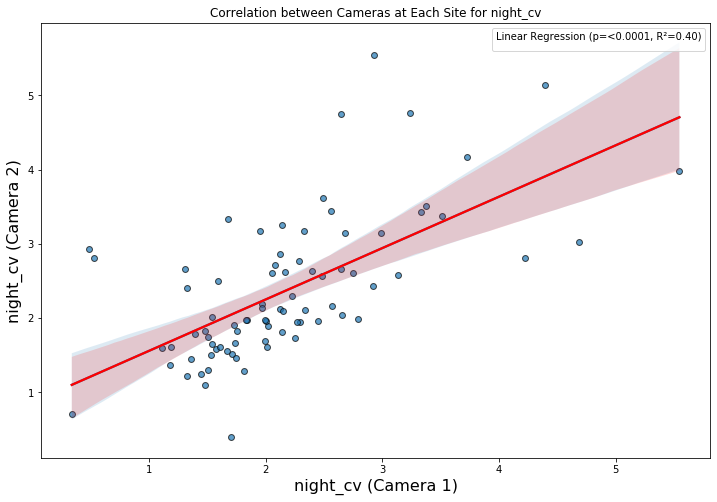

In [87]:
# Example usage
plot_camera_metric_correlation('night_cv')


In [22]:
results = []

for site in tqdm(site_cams):
    site_bool = np.logical_or(site_cats['ID'] == site.lower(), site_cats['ID'] == site)
    num_type = site_cats.loc[site_bool]['num_types'].values[0]
    num_business = site_cats.loc[site_bool]['num_business'].values[0]
    shannon_entropy = site_cats.loc[site_bool]['shannon_entropy'].values[0]
    intersections = site_cats.loc[site_bool]['total_intersections'].values[0]
    road_len = site_cats.loc[site_bool]['total_road_length'].values[0]        
    site_dens_bool = np.logical_or(site_densities['ID'] == site.lower(), site_densities['ID'] == site)
#     pop_dens = site_pop_dens_ndvi.loc[site_bool]['pop_den'].values[0]
    pop_dens = site_densities.loc[site_dens_bool]['population_density_2019'].values[0]
    building_dens = site_densities.loc[site_dens_bool]['buildings_density_2019'].values[0]
    day_entropy = site_entropy[site_entropy['site'] == site]['day_entropy'].values[0]
    night_entropy = site_entropy[site_entropy['site'] == site]['night_entropy'].values[0]
    day_cv = site_entropy[site_entropy['site'] == site]['day_cv'].values[0]
    night_cv = site_entropy[site_entropy['site'] == site]['night_cv'].values[0]
    day_gini = site_entropy[site_entropy['site'] == site]['day_gini'].values[0]
    night_gini = site_entropy[site_entropy['site'] == site]['night_gini'].values[0]
#     cv = site_entropy[site_entropy['site'] == site]['cv'].values[0]
#     entropy = site_entropy[site_entropy['site'] == site]['entropy'].values[0]
    day_cv_vehicles = site_entropy_vehicles[site_entropy_vehicles['site'] == site]['day_cv_vehicles'].values[0]
    night_cv_vehicles = site_entropy_vehicles[site_entropy_vehicles['site'] == site]['night_cv_vehicles'].values[0]
    log_day_cv = np.log(day_cv)
    log_night_cv = np.log(night_cv)
    log_day_gini = np.log(day_gini)
    log_night_gini = np.log(night_gini)
#     log_cv = np.log(cv)
    log_day_entropy = np.log(day_entropy)
    log_night_entropy = np.log(night_entropy)
#     log_entropy = np.log(entropy)
    log_day_cv_vehicles = np.log(day_cv_vehicles)
    log_night_cv_vehicles = np.log(night_cv_vehicles)
    
    
    # Create the dictionary for this site
    site_dict = {
        'site': site,
        'day_cv': day_cv,
        'day_gini': day_gini,
        'log_day_cv': log_day_cv,
        'log_day_gini': log_day_gini,
        'day_entropy': day_entropy,
        'log_day_entropy' : log_day_entropy,
#         'entropy': entropy,
#         'log_entropy': log_entropy,
#         'cv': cv,
#         'log_cv': log_cv,
        'night_cv': night_cv,
        'night_gini': night_gini,
        'log_night_cv': log_night_cv,  
        'log_night_gini': log_night_gini,
        'night_entropy': night_entropy,
        'log_night_entropy' : log_night_entropy,
        'day_cv_vehicles': day_cv_vehicles,
        'log_day_cv_vehicles': log_day_cv_vehicles,
#         'day_entropy_vehicles': day_entropy_vehicles,
#         'log_day_entropy_vehicles' : log_day_entropy_vehicles,
        'night_cv_vehicles': night_cv_vehicles,
        'log_night_cv_vehicles': log_night_cv_vehicles,        
#         'night_entropy_vehicles': night_entropy_vehicles,
#         'log_night_entropy_vehicles' : log_night_entropy_vehicles,
        'business_types': num_type,
        'num_business': num_business,
        'pop_dens': pop_dens,
        'building_dens': building_dens,
        'intersections': intersections,
        'road_len': road_len,
        'shannon_entropy': shannon_entropy
    }

    # Add each unique fclass value
    for fclass in unique_fclasses:
        site_dict[fclass] = site_cats.loc[site_bool][fclass].values[0]

    results.append(site_dict)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

100%|██████████| 143/143 [00:09<00:00, 15.84it/s]


In [43]:
# Constant footfall: 100 people pass by each hour
constant_footfall = pd.DataFrame({'footfall': [100]*24})

# Uneven footfall: 2400 people pass by at noon, 0 at all other times
uneven_footfall = pd.DataFrame({'footfall': [0]*11 + [2400] + [0]*12})

def calculate_entropy(df):
    # Calculate probabilities
    total_footfall = df['footfall'].sum()
    df['probability'] = df['footfall'] / total_footfall
    
    # Calculate entropy
    entropy = -np.sum(df['probability'] * np.log(df['probability']))
    return entropy


def calculate_cov(df):
    # Calculate probabilities
    cov = df['footfall'].std() / df['footfall'].mean()
    return cov
    
# Calculate entropy for each situation
constant_entropy = calculate_entropy(constant_footfall)
uneven_entropy = calculate_entropy(uneven_footfall)

print(f'Entropy for constant footfall: {constant_entropy}')
print(f'Entropy for uneven footfall: {uneven_entropy}')


Entropy for constant footfall: 3.1780538303479453
Entropy for uneven footfall: -0.0


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
import numpy as np
import pandas as pd

np.random.seed(0)  # set seed for reproducibility

# Scenario 1: totally random number of people may turn up in a given hour
random_footfall = pd.DataFrame({'footfall': np.random.randint(low=0, high=100, size=24)})
random_footfall = random_footfall * 2400 / random_footfall.sum()

# Scenario 2: no one between 6am and 6pm but between these hours the footfall increases to midday and decays to 6pm
footfall_day = np.concatenate((np.arange(6), np.full(1,6), np.arange(6)[::-1]))
footfall_night = np.zeros(11)
footfall_values = np.concatenate((footfall_night, footfall_day))
uneven_day_footfall = pd.DataFrame({'footfall': footfall_values * 2400 / footfall_values.sum()})
# print(uneven_day_footfall)

# Scenario 3: footfall is highly peaked around the morning (~9am) and evening (~5pm)
morning_peak = np.concatenate((np.zeros(6), [0,1,2,3,2,1,0], np.zeros(11)))
evening_peak = np.concatenate((np.zeros(14), [0,1,2,3,2,1,0], np.zeros(3)))
peak_footfall = pd.DataFrame({'footfall': (morning_peak + evening_peak) * 2400 / (morning_peak + evening_peak).sum()})
print(peak_footfall)

# Use the calculate_entropy function for each dataframe
random_entropy = calculate_entropy(random_footfall)
uneven_day_entropy = calculate_entropy(uneven_day_footfall)
peak_entropy = calculate_entropy(peak_footfall)

print(f'Entropy for random footfall: {random_entropy}')
print(f'Entropy for uneven day footfall: {uneven_day_entropy}')
print(f'Entropy for peak footfall: {peak_entropy}')


      footfall
0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7   133.333333
8   266.666667
9   400.000000
10  266.666667
11  133.333333
12    0.000000
13    0.000000
14    0.000000
15  133.333333
16  266.666667
17  400.000000
18  266.666667
19  133.333333
20    0.000000
21    0.000000
22    0.000000
23    0.000000
Entropy for random footfall: 3.068827926121998
Entropy for uneven day footfall: 2.2696424583750847
Entropy for peak footfall: 2.2161022480912633


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


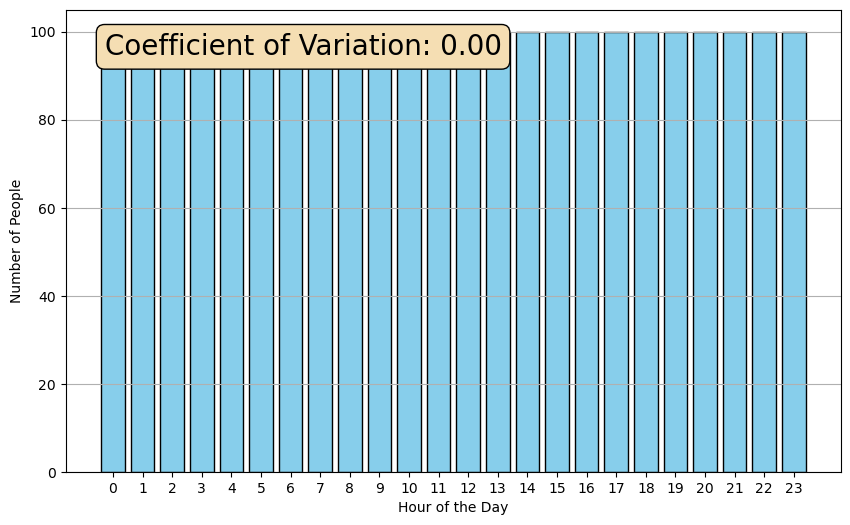

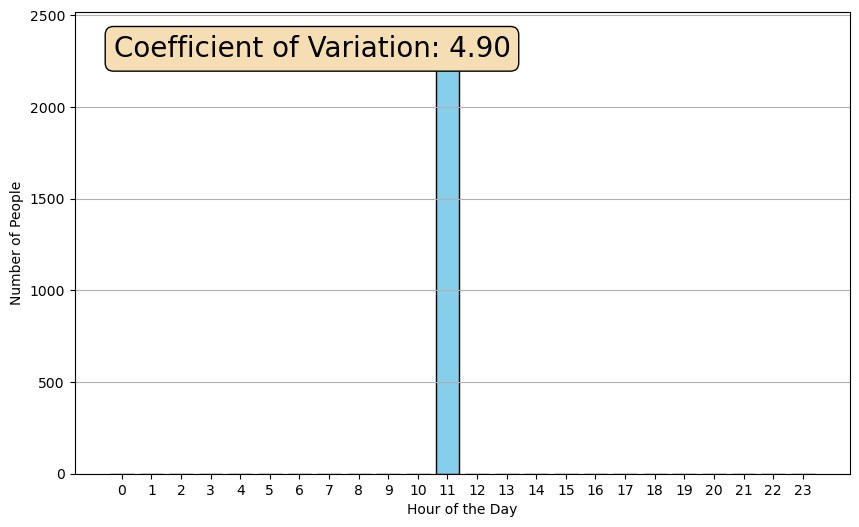

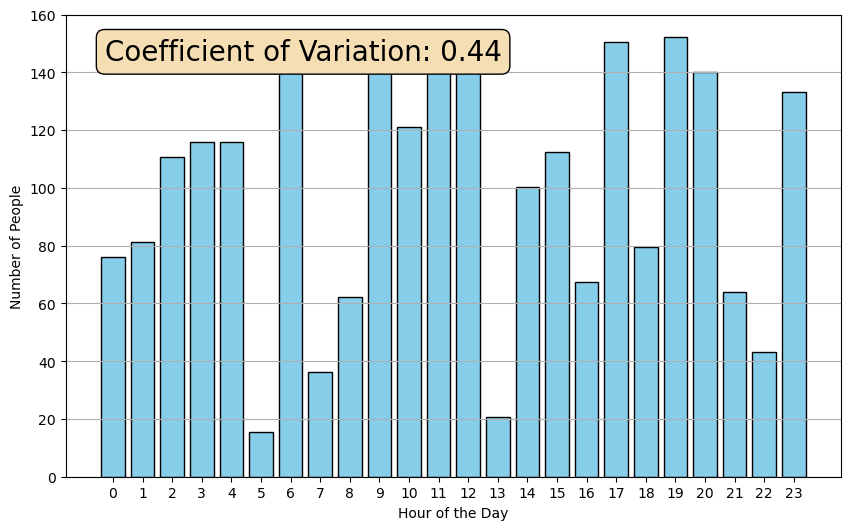

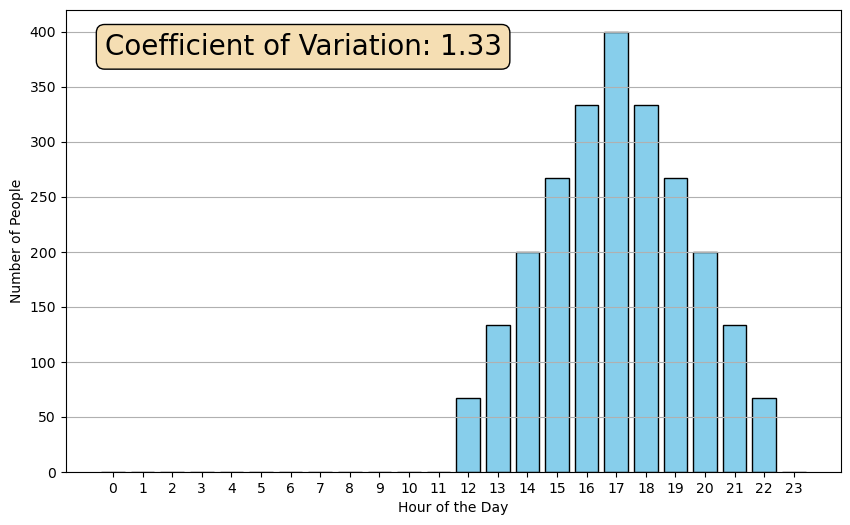

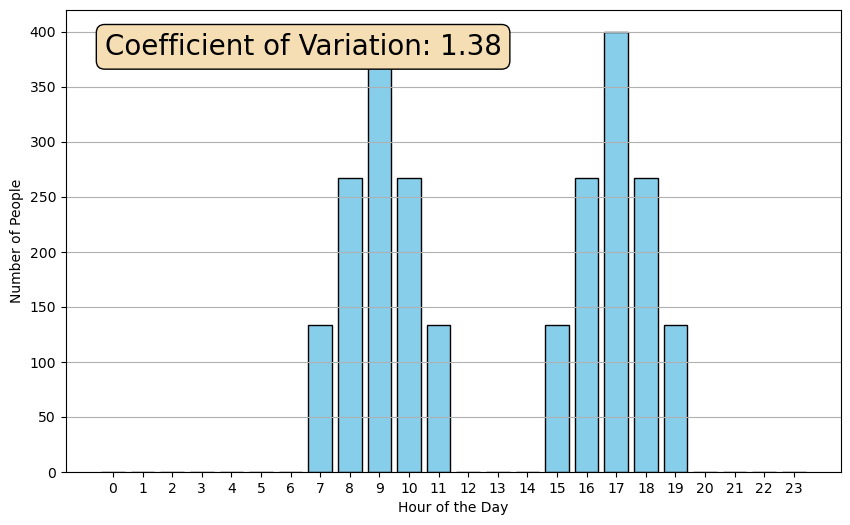

In [41]:
# Function to plot footfall
def plot_footfall(df, title):
    # Calculate entropy
    entropy = calculate_entropy(df)
    cov = calculate_cov(df)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(24), df['footfall'], color='skyblue', edgecolor='black')

    plt.xticks(range(24))
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of People')
#     plt.title(f'{title}\nEntropy: {entropy:.2f}')

    # Adding a text box inside the plot
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
#     textstr = f'Entropy: {entropy:.2f}'
#     plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=20, verticalalignment='top', bbox=props)

    textstr = f'Coefficient of Variation: {cov:.2f}'
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=20, verticalalignment='top', bbox=props)

    plt.grid(axis='y')
    plt.show()

# Plot footfall for each scenario
plot_footfall(constant_footfall, 'Constant Footfall')
plot_footfall(uneven_footfall, 'Totally predictable Footfall')
plot_footfall(random_footfall, 'Random Footfall')
plot_footfall(uneven_day_footfall, 'Unimodal Footfall')
plot_footfall(peak_footfall, 'Bimodal Footfall')


In [119]:
results_df.num_business.sum()

3847.0

SpearmanrResult(correlation=-0.3494367579008104, pvalue=1.8889906937778155e-05)
p_value:  3.257161046150158e-05


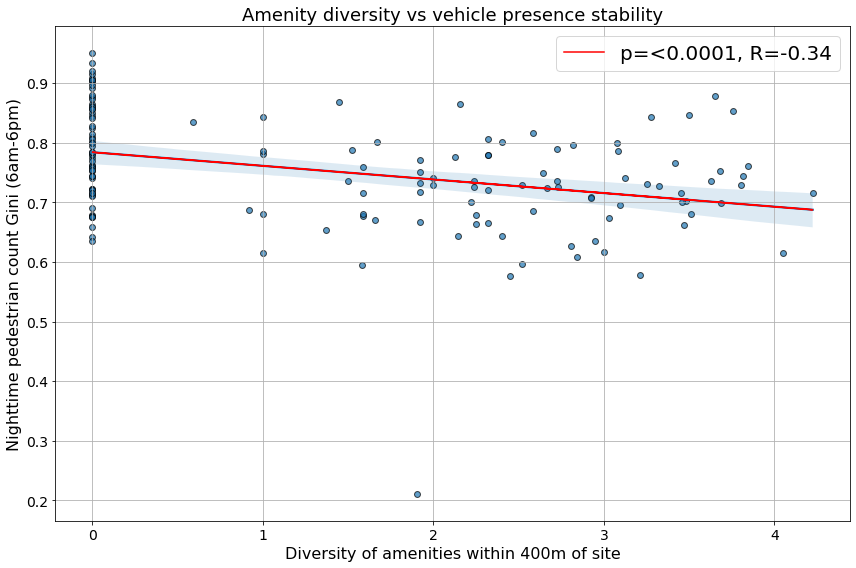

In [29]:
x = 'shannon_entropy'
y = 'night_gini'

regression_frame = results_df[results_df[x].notna() & results_df[y].notna()]
# regression_frame = regression_frame[~regression_frame['night_entropy'].apply(lambda x: isinstance(x, pd.Series) and x.empty)]

# Ensure that all values in 'night_entropy' are numeric
# regression_frame['night_entropy'] = pd.to_numeric(regression_frame['night_entropy'], errors='coerce')

# Repeat for 'night_cv' if necessary
# regression_frame['log_night_cv'] = pd.to_numeric(regression_frame['night_cv'], errors='coerce')

slope, intercept, r_value, p_value, std_err = stats.linregress(regression_frame[x].values,regression_frame[y].values)
spearmanr = stats.spearmanr(regression_frame[x].values, regression_frame[y])

print(spearmanr)
print("p_value: ", p_value)

fig, ax = plt.subplots(figsize=(12,8))  # Increased figure size for better visibility

sns.regplot(data=regression_frame, x = x, y = y, ax=ax, scatter_kws={'s':35, 'edgecolor':'k', 'alpha':0.7}) # Increased marker size, added edgecolor for better visibility

# Conditional p-value formatting
if p_value < 0.0001:
    p_value_str = "<0.0001"
else:
    p_value_str = "{:.4f}".format(p_value)
# plt.plot(regression_frame[x], intercept + slope * regression_frame[x], 'r', label='p={}, R\u00b2={:.2f}'.format(p_value_str, r_value*r_value))
plt.plot(regression_frame[x], intercept + slope * regression_frame[x], 'r', label='p={}, R={:.2f}'.format(p_value_str, r_value))

# Set larger font sizes
plt.title('Amenity diversity vs pedestrian presence stability', fontsize=18) 
plt.title('Amenity diversity vs vehicle presence stability', fontsize=18) 
plt.xlabel('Diversity of amenities within 400m of site', fontsize=16) 
# plt.ylabel('Log of Daytime pedestrian count entropy (6am-6pm)', fontsize=16) 
# plt.ylabel('Log of Daytime vehicle count entropy (6am-6pm)', fontsize=16) 
# plt.ylabel('Log of Nighttime pedestrian count entropy (6pm-6am)', fontsize=16) 
# plt.ylabel('Log of Daytime pedestrian count Gini (6am-6pm)', fontsize=16) 
# plt.ylabel('Daytime pedestrian count Gini (6am-6pm)', fontsize=16) 
plt.ylabel('Nighttime pedestrian count Gini (6am-6pm)', fontsize=16) 
# plt.ylabel('Log of Daytime pedestrian count CoV (6am-6pm)', fontsize=16) 
# plt.ylabel('Log of Daytime vehicle count CoV (6am-6pm)', fontsize=16) 
# plt.ylabel('Log of Nighttime pedestrian count CoV (6pm-6am)', fontsize=16)
# plt.ylabel('Log of Nighttime vehicle count CoV (6pm-6am)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True) # Enable grid
plt.legend(fontsize=20) # Decreased legend fontsize to match axis ticks
plt.tight_layout() # Provides adequate spacing for labels
plt.savefig('results/Jacobs/Correlation_plots/'+x+'_vs_'+y+'.png', format ='png', bbox_inches='tight', pad_inches=0.0)

In [32]:
# for fclass in unique_fclasses:
#     print(fclass)
#     print(results_df[fclass].sum())
#     print("\n")

In [32]:
fclass_correlations = []

for y in unique_fclasses:
    x = 'day_gini'
#     print(y)
    regression_frame = results_df[results_df[x].notna() & results_df[y].notna()]

    fclass_sum = results_df[y].sum()
    slope, intercept, r_value, p_value, std_err = stats.linregress(regression_frame[x].values,regression_frame[y].values)

    fclass_correlations.append({"fclass": y, "r": r_value, "r2": r_value*r_value, "p_value": p_value, "samples": fclass_sum})

fclass_corr = pd.DataFrame(fclass_correlations)

In [33]:
sampled_fclass = fclass_corr[fclass_corr['samples'].astype(float) > 5]
print(len(sampled_fclass))
sampled_fclass.sort_values(by='r', ascending=True)[:20]
# sampled_fclass.iloc[sampled_fclass['r'].nsmallest().index]

46


,fclass,r,r2,p_value,samples
6,bank,-0.268082,0.071868,0.001207,89.0
30,pharmacy,-0.264057,0.069726,0.001439,45.0
14,school,-0.240092,0.057644,0.003874,101.0
21,post_office,-0.230982,0.053353,0.005511,14.0
107,muslim,-0.228601,0.052258,0.006030,11.0
106,christian,-0.201095,0.040439,0.016027,93.0
29,bar,-0.199963,0.039985,0.016645,31.0
7,hospital,-0.190085,0.036132,0.022972,13.0
0,police,-0.183172,0.033552,0.028542,13.0
42,clothes,-0.175829,0.030916,0.035681,14.0


p_value:  1.0975185168577177e-54


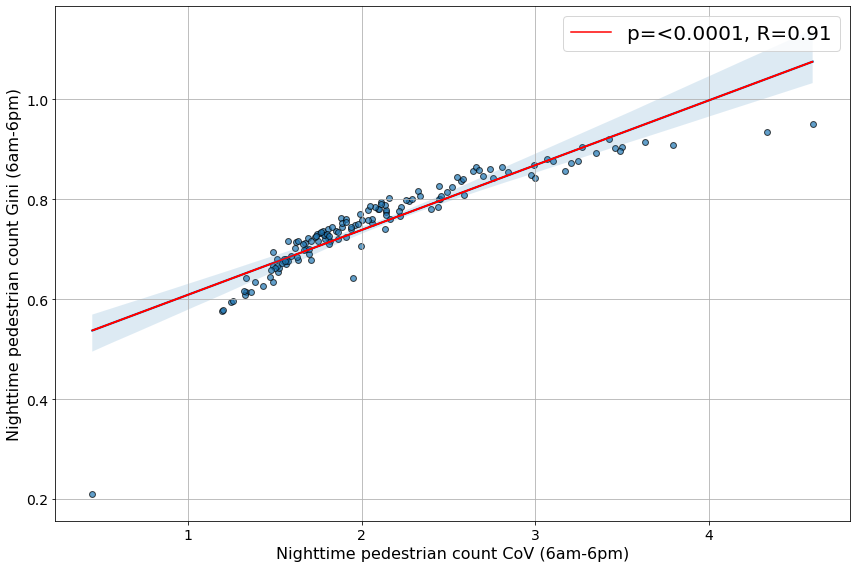

In [40]:
x = 'night_cv'
y = 'night_gini'

regression_frame = results_df[results_df[x].notna() & results_df[y].notna()]
regression_frame = regression_frame[~regression_frame['night_entropy'].apply(lambda x: isinstance(x, pd.Series) and x.empty)]

# Ensure that all values in 'night_entropy' are numeric
regression_frame['night_entropy'] = pd.to_numeric(regression_frame['night_entropy'], errors='coerce')

# Repeat for 'night_cv' if necessary
# regression_frame['night_cv'] = pd.to_numeric(regression_frame['night_cv'], errors='coerce')

slope, intercept, r_value, p_value, std_err = stats.linregress(regression_frame[x].values,regression_frame[y].values)


print("p_value: ", p_value)

fig, ax = plt.subplots(figsize=(12,8))  # Increased figure size for better visibility

sns.regplot(data=regression_frame, x = x, y = y, ax=ax, scatter_kws={'s':35, 'edgecolor':'k', 'alpha':0.7}) # Increased marker size, added edgecolor for better visibility

# Conditional p-value formatting
if p_value < 0.0001:
    p_value_str = "<0.0001"
else:
    p_value_str = "{:.4f}".format(p_value)
# plt.plot(regression_frame[x], intercept + slope * regression_frame[x], 'r', label='p={}, R\u00b2={:.2f}'.format(p_value_str, r_value*r_value))
plt.plot(regression_frame[x], intercept + slope * regression_frame[x], 'r', label='p={}, R={:.2f}'.format(p_value_str, r_value))

# Set larger font sizes
# plt.title('Population density vs pedestrian presence stability', fontsize=18) 
# plt.xlabel('Diversity of amenities within 400m of site', fontsize=16) 
# plt.xlabel('Number of overall amenities within 400m of site', fontsize=16) 
# plt.xlabel('Population density near site (count per square km)', fontsize=16) 
# plt.xlabel('Building density near site (count per square km)', fontsize=16) 
# plt.xlabel('Total length of roads near site (metres)', fontsize=16) 
# plt.xlabel('Number of intersections near site (count in radius)', fontsize=16) 
# plt.xlabel('Daytime pedestrian count CoV (6am-6pm)', fontsize=16) 
plt.xlabel('Nighttime pedestrian count CoV (6am-6pm)', fontsize=16) 
# plt.xlabel('Log of Daytime pedestrian count CoV (6am-6pm)', fontsize=16) 
# plt.xlabel('Log of Nighttime pedestrian count CoV (6am-6pm)', fontsize=16) 
# plt.xlabel('Log of Daytime vehicle count CoV (6am-6pm)', fontsize=16) 
# plt.xlabel('Log of Nighttime vehicle count CoV (6am-6pm)', fontsize=16) 

# plt.ylabel('Number of unique amenities within 400m of site', fontsize=16) 
# plt.ylabel('Number of overall amenities within 400m of site', fontsize=16) 
# plt.ylabel('Population density near site (count per square km)', fontsize=16) 
# plt.ylabel('Building density near site (count per square km)', fontsize=16) 
# plt.ylabel('Total length of roads near site (metres)', fontsize=16) 
# plt.ylabel('Number of intersections near site (count in radius)', fontsize=16) 
# plt.ylabel('Log of Daytime pedestrian count CoV (6am-6pm)', fontsize=16) 
# plt.ylabel('Daytime pedestrian count entropy (6am-6pm)', fontsize=16) 
# plt.ylabel('Nighttime pedestrian count entropy (6pm-6am)', fontsize=16) 
# plt.ylabel('Log of Daytime pedestrian count CoV (6am-6pm)', fontsize=16) 
# plt.ylabel('Log of Nighttime pedestrian count CoV (6pm-6am)', fontsize=16)
# plt.ylabel('Log of Daytime vehicle count CoV (6am-6pm)', fontsize=16) 
# plt.ylabel('Daytime pedestrian count Gini (6am-6pm)', fontsize=16) 
plt.ylabel('Nighttime pedestrian count Gini (6am-6pm)', fontsize=16) 
# plt.ylabel('Log of Nighttime vehicle count CoV (6am-6pm)', fontsize=16) 

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True) # Enable grid
plt.legend(fontsize=20) # Decreased legend fontsize to match axis ticks
plt.tight_layout() # Provides adequate spacing for labels
plt.savefig('results/Jacobs/Correlation_plots/'+x+'_vs_'+y+'.png', format ='png', bbox_inches='tight', pad_inches=0.0)

In [77]:
results_df.head()

,site,day_cv,log_day_cv,day_entropy,log_day_entropy,night_cv,log_night_cv,night_entropy,log_night_entropy,business_types,...,christian_orthodox,christian_protestant,hindu,christian_evangelical,zoo,theme_park,prison,lighthouse,battlefield,christian_catholic
0,AD,0.107227,-2.232807,0.659321,-0.416545,0.402924,-0.909006,0.405334,-0.903043,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ASH,0.694677,-0.364308,0.630419,-0.461371,1.245210,0.219305,0.301261,-1.199779,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EL,0.208107,-1.569704,0.143442,-1.941823,0.575507,-0.552503,0.043525,-3.134429,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JT,0.064922,-2.734564,0.686809,-0.375699,0.216876,-1.528427,0.638088,-0.449279,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,LA,0.683508,-0.380516,0.790399,-0.235217,1.870923,0.626432,0.252751,-1.375350,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
import statsmodels.formula.api as smf

y = 'night_cv'

regression_frame = results_df
regression_frame = results_df[results_df[y].notna()]
# regression_frame['log_night_cv'] = pd.to_numeric(regression_frame['log_night_cv'], errors='coerce')

print(len(regression_frame))

## REMEMBER Include pop_dens for the appendix
# Create a fitted model with all three features
lm = smf.ols(formula=y+' ~ shannon_entropy + num_business + building_dens + intersections', data=regression_frame).fit()

# Print the coefficients
print(lm.params)
print(lm.summary())

partial_corr = pg.partial_corr(data=regression_frame, x='shannon_entropy', y=y, covar=['num_business','pop_dens','building_dens','intersections'])
# partial_corr = pg.partial_corr(data=regression_frame, x='intersections', y=y, covar=['num_business','pop_dens','building_dens', 'business_types'])
# partial_corr = pg.partial_corr(data=regression_frame, x='business_types', y=y, covar=['num_business'])
# partial_corr = pg.partial_corr(data=regression_frame, x='building_dens', y=y, covar=['num_business','shannon_entropy', 'pop_dens', 'intersections'])

print("\n\n")
print(partial_corr)
# print(str(partial_corr.r*partial_corr.r))


143
Intercept          2.898353
shannon_entropy   -0.090758
num_business       0.003171
building_dens     -0.000253
intersections     -0.007268
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               night_cv   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     26.40
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           2.89e-16
Time:                        07:47:56   Log-Likelihood:                -101.67
No. Observations:                 143   AIC:                             213.3
Df Residuals:                     138   BIC:                             228.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t   

In [52]:
print([*range(5,100,5)]+[*range(100,260,10)])

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]


In [55]:
interval = 10

day_correlations = {str(i)+'0': None for i in [*range(interval,100,interval)]+[*range(100,410,10)]}
night_correlations = {str(i)+'0': None for i in [*range(interval,100,interval)]+[*range(100,410,10)]}

day_correlations_cv = {str(i)+'0': None for i in [*range(interval,100,interval)]+[*range(100,410,10)]}
night_correlations_cv = {str(i)+'0': None for i in [*range(interval,100,interval)]+[*range(100,410,10)]}

for i in tqdm(range(interval,110,interval)):
# for i in tqdm(range(100,260,10)):    
#     site_cats = pd.read_csv('site_cats_businesses_'+str(i)+'00.csv')
    site_cats = pd.read_csv('site_cats_businesses_'+str(i)+'0.csv')
    site_cats['shannon_entropy'] = site_cats[unique_fclasses].apply(shannon_entropy, axis=1)
    results = []

    for site in site_cams:
        site_bool = np.logical_or(site_cats['ID'] == site.lower(), site_cats['ID'] == site)
        num_type = site_cats.loc[site_bool]['num_types'].values[0]

        business_entropy = site_cats.loc[site_bool]['shannon_entropy'].values[0]
        num_business = site_cats.loc[site_bool]['num_business'].values[0]
        site_dens_bool = np.logical_or(site_densities['ID'] == site.lower(), site_densities['ID'] == site)
        pop_dens = site_pop_dens_ndvi.loc[site_bool]['pop_den'].values[0]
    #     pop_dens = site_densities.loc[site_dens_bool]['population_density_2019'].values[0]
        building_dens = site_densities.loc[site_dens_bool]['buildings_density_2019'].values[0]
        day_entropy = site_entropy[site_entropy['site'] == site]['day_entropy'].values[0]
        night_entropy = site_entropy[site_entropy['site'] == site]['night_entropy'].values[0]
        day_cv = site_entropy[site_entropy['site'] == site]['day_cv'].values[0]
        night_cv = site_entropy[site_entropy['site'] == site]['night_cv'].values[0]
        log_day_cv = np.log(day_cv)
        log_night_cv = np.log(night_cv)

        # Create the dictionary for this site
        site_dict = {
            'site': site,
            'day_cv': day_cv,
            'log_day_cv': log_day_cv,
            'day_entropy': day_entropy,
            'night_cv': night_cv,
            'log_night_cv': log_night_cv,        
            'night_entropy': night_entropy,
            'business_types': num_type,
            'shannon_entropy': business_entropy,
            'num_business': num_business,
            'pop_dens': pop_dens,
            'building_dens': building_dens
        }

        results.append(site_dict)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    x = 'shannon_entropy'
#     for y in ['day_entropy','night_entropy']:
    for y in ['log_day_cv','log_night_cv']:
        regression_frame = results_df[results_df[x].notna() & results_df[y].notna()]
        regression_frame = regression_frame[~regression_frame['night_cv'].apply(lambda x: isinstance(x, pd.Series) and x.empty)]

        # Ensure that all values in 'night_entropy' are numeric
        regression_frame['night_entropy'] = pd.to_numeric(regression_frame['night_entropy'], errors='coerce')

        # Repeat for 'night_cv' if necessary
        regression_frame['log_night_cv'] = pd.to_numeric(regression_frame['night_cv'], errors='coerce')

        slope, intercept, r_value, p_value, std_err = stats.linregress(regression_frame[x].values,regression_frame[y].values)
        spearmanr = stats.spearmanr(regression_frame[x].values, regression_frame[y])

        if y == 'log_day_cv':
            day_correlations_cv[str(i)+'0'] = r_value
#             day_correlations_cv[str(i)+'0'] = spearmanr.correlation
        else:
            night_correlations_cv[str(i)+'0'] = r_value
#             night_correlations_cv[str(i)+'0'] = spearmanr.correlation
            
    for y in ['day_entropy','night_entropy']:
        regression_frame = results_df[results_df[x].notna() & results_df[y].notna()]
        regression_frame = regression_frame[~regression_frame['night_cv'].apply(lambda x: isinstance(x, pd.Series) and x.empty)]

        # Ensure that all values in 'night_entropy' are numeric
        regression_frame['night_entropy'] = pd.to_numeric(regression_frame['night_entropy'], errors='coerce')

        # Repeat for 'night_cv' if necessary
        regression_frame['night_entropy'] = pd.to_numeric(regression_frame['night_entropy'], errors='coerce')

        slope, intercept, r_value, p_value, std_err = stats.linregress(regression_frame[x].values,regression_frame[y].values)
        spearmanr = stats.spearmanr(regression_frame[x].values, regression_frame[y])

        if y == 'day_entropy':
#             day_correlations[str(i)+'0'] = r_value*r_value
            day_correlations[str(i)+'0'] = spearmanr.correlation
        else:
#             night_correlations[str(i)+'0'] = r_value*r_value
            night_correlations[str(i)+'0'] = spearmanr.correlation

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


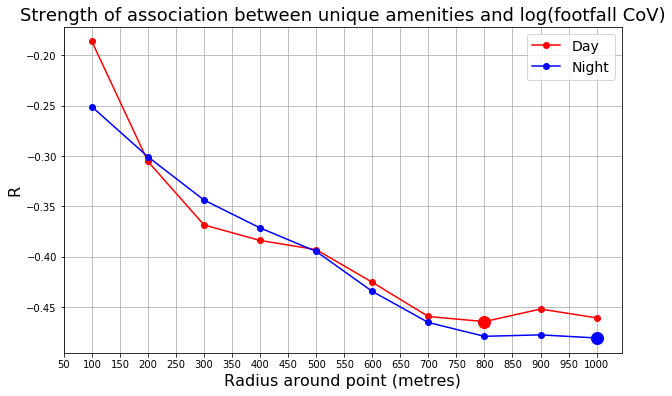

In [56]:
day_df = pd.DataFrame(day_correlations_cv.items(), columns=['Radius (m)', 'r2'])
night_df = pd.DataFrame(night_correlations_cv.items(), columns=['Radius (m)', 'r2'])

# Convert 'Radius (m)' column to numeric
day_df['Radius (m)'] = pd.to_numeric(day_df['Radius (m)'])
night_df['Radius (m)'] = pd.to_numeric(night_df['Radius (m)'])

# plt.figure(figsize=(18,6))
plt.figure(figsize=(10,6))

# Plot day correlations
plt.plot(day_df['Radius (m)'], day_df['r2'], marker='o', linestyle='-', color='r', label='Day')

# Plot night correlations
plt.plot(night_df['Radius (m)'], night_df['r2'], marker='o', linestyle='-', color='b', label='Night')

# Highlight the maximum 'r2' value for both day and night
# day_max_r2 = day_df['r2'].max()
# night_max_r2 = night_df['r2'].max()
day_max_r2 = day_df['r2'].min()
night_max_r2 = night_df['r2'].min()
plt.plot(day_df['Radius (m)'][day_df['r2'].idxmin()], day_max_r2, marker='o', markersize=12, linestyle='', color='r')
plt.plot(night_df['Radius (m)'][night_df['r2'].idxmin()], night_max_r2, marker='o', markersize=12, linestyle='', color='b')

# Add labels, title, legend, and grid
plt.xlabel('Radius around point (metres)', fontsize = 16)
# plt.ylabel('R\u00b2', fontsize = 16)
plt.ylabel('R', fontsize = 16)
# plt.title('Strength of association between unique amenities and footfall entropy', fontsize=18)
plt.title('Strength of association between unique amenities and log(footfall CoV)', fontsize=18)
plt.xticks([50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000])
# plt.xticks([50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400,3500,3600,3700,3800,3900,4000])
plt.legend(fontsize=14)
plt.grid(True)

plt.savefig('results/Jacobs/Correlation_plots/day_night_vs_distance_cv.png', format ='png', bbox_inches='tight', pad_inches=0.0)

In [14]:
# Create dataframes with information about all sites (for correlations across sites)

object_data['sums'] = {'site_cams':pd.DataFrame()}

sum_categories = categories+['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse','paratransit']
for site in site_cams:
    for cam in site_cams[site]:
        print(site+' '+cam)
        if(len(object_data[site][cam]) < 1):
            print(site)
            print(cam)
            print(int(len(object_data[site][cam])))
        else:
            site_counts = dict(object_data[site][cam][[cat+'_counts' for cat in sum_categories]].sum().sort_values(ascending=False))
            site_counts['site_cam']=site+"_"+cam
            site_counts['ndvi']=object_data[site][cam]['ndvi'][0]
            site_counts['pop_dens']=object_data[site][cam]['pop_dens'][0]
            #print(site)
            for cat in sum_categories:          
                site_counts[cat] = [float(int(site_counts[cat+'_counts'])/(len(object_data[site][cam])))]
                site_counts[cat+'_counts'] = [float(int(site_counts[cat+'_counts']))]
            site_counts['im_len'] = [float(len(object_data[site][cam]))]
            object_data['sums']['site_cams'] = pd.concat([object_data['sums']['site_cams'],pd.DataFrame(site_counts)], ignore_index = True)
        
object_data['sums']['sites'] = pd.DataFrame()

sum_categories = categories+['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse','paratransit']
for site in site_cams:
    site_counts = dict()
    site_counts['site']=site
    site_counts['ndvi']=object_data[site][site_cams[site][0]]['ndvi'][0]
    site_counts['pop_dens']=object_data[site][site_cams[site][0]]['pop_dens'][0]
    for cat in sum_categories:          
        site_counts[cat+'_counts'] = [0]
    site_counts['im_len']= [0]    
    for cam in site_cams[site]:
        #print(site+' '+cam)
        if(len(object_data[site][cam]) < 1):
            print(site)
            print(cam)
            print(int(len(object_data[site][cam])))
        else:
            for cat in sum_categories:          
                site_counts[cat+'_counts'][0] += float(object_data[site][cam][cat+'_counts'].sum())
            site_counts['im_len'][0]+= float(len(object_data[site][cam]))
    for cat in sum_categories:          
        site_counts[cat] = [float(site_counts[cat+'_counts'][0]/site_counts['im_len'][0])]
    object_data['sums']['sites'] = pd.concat([object_data['sums']['sites'],pd.DataFrame(site_counts)], ignore_index = True)
        

AD C4
AD C17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



AD C12
AD C14
ASH C6
ASH C13
EL C12
EL C32
EL C01
EL C8
EL C18
EL C28
EL C10
JT C31
JT C21
JT C11
JT C9
LA C16
LA C35
N1West C36
N1West C15
N1West C33
Nima C2
Nima C27
Nima C13
Nima C26
Taifa C21
Taifa C22
TMW C30
TMW C19
UGH C5
UGH C12
UGH C23
UGH C33
UGH C25
S135 C40
S135 C41
S166 C28
S166 C43
S21 C20
S21 C5
S113 C8
S113 C20
S132 C43
S8 C5
S8 C41
S45 C41
S45 C28
S109 C20
S109 C23
S0 C11
S58 C43
S58 C40
S94 C44
S94 C13
S88 C44
S88 C40
S139 C41
S139 C43
S79 C8
S79 C42
S14 C41
S14 C20
S153 C20
S153 C23
S160 C11
S37 C42
S37 C8
S18 C23
S18 C44
S117 C41
S93 C16
S93 C35
S34 C43
S103 C23
S103 C8
S92 C16
S92 C36
S19 C8
S90 C43
S90 C20
S54 C8
S54 C13
S29 C13
S29 C42
S104 C43
S104 C41
S112 C8
S112 C20
S131 C13
S147 C8
S126 C40
S126 C41
S53 C13
S53 C5
S86 C8
S86 C40
S50 C8
S50 C20
S85 C13
S85 C8
S154 C5
S154 C40
S72 C20
S123 C8
S114 C20
S114 C44
S60 C41
S35 C40
S35 C8
S107 C35
S66 C9
S66 C43
S97 C41
S97 C11
S101 C42
S101 C13
S122 C9
S115 C43
S115 C41
S138 C32
S100 C8
S100 C5
S124 C42
S106 C44
S1

In [6]:
# The categorisation of Labadi is actually different to that
# recorded from the log forms. This is because for pollution monitoring 
# purposes, Labadi's location by the sea makes it more akin to 
# a "background" site for that purpose, but is not peri-urban.

for cam in site_cams['LA']:
    object_data['LA'][cam]['site_type'] = 'low-dens'

In [9]:
# Show many objects of each kind there are in our dataset
obj_categories = ['person','umbrella', 'stall', 'food', 'bowl', 'car', 'taxi', 'truck','bicycle', 'motorcycle', 'animal','trotro', 'van', 'lorry', 'debris', 'trash', 'vendor', 'loudspeaker', 'stove', 'bus']

print(object_data['sums']['sites'][[cat+'_counts' for cat in obj_categories]].sum())

person_counts         9656349.0
umbrella_counts       3002174.0
stall_counts           143833.0
food_counts             49668.0
bowl_counts            209025.0
car_counts            4179583.0
taxi_counts           1270614.0
truck_counts           352880.0
bicycle_counts         102515.0
motorcycle_counts      257625.0
animal_counts           36663.0
trotro_counts         2941699.0
van_counts             175998.0
lorry_counts           163841.0
debris_counts          296912.0
trash_counts           601021.0
vendor_counts              98.0
loudspeaker_counts          0.0
stove_counts                0.0
bus_counts                 14.0
dtype: float64


In [17]:
object_data.keys()

dict_keys(['AD', 'ASH', 'EL', 'JT', 'LA', 'N1West', 'Nima', 'Taifa', 'TMW', 'UGH', 'S135', 'S166', 'S21', 'S113', 'S132', 'S8', 'S45', 'S109', 'S0', 'S58', 'S94', 'S88', 'S139', 'S79', 'S14', 'S153', 'S160', 'S37', 'S18', 'S117', 'S93', 'S34', 'S103', 'S92', 'S19', 'S90', 'S54', 'S29', 'S104', 'S112', 'S131', 'S147', 'S126', 'S53', 'S86', 'S50', 'S85', 'S154', 'S72', 'S123', 'S114', 'S60', 'S35', 'S107', 'S66', 'S97', 'S101', 'S122', 'S115', 'S138', 'S100', 'S124', 'S106', 'S133', 'S76', 'S67', 'S51', 'S3', 'S68', 'S169', 'S31', 'S62', 'S61', 'S102', 'S12', 'S49', 'S39', 'S91', 'S87', 'S159', 'S65', 'S168', 'S41', 'S82', 'S28', 'S25', 'S1', 'S105', 'S69', 'S11', 'S129', 'S40', 'S70', 'S125', 'S143', 'S108', 'S13', 'S26', 'S52', 'S116', 'S111', 'S22', 'S57', 'S56', 'S36', 'S150', 'S71', 'S118', 'S81', 'S136', 'S120', 'S5', 'S80', 'S73', 'S64', 'S44', 'S83', 'S24', 'S89', 'S4', 'S30', 'S74', 'S20', 'S98', 'S77', 'S130', 'S121', 'S32', 'S55', 'S59', 'S110', 'S119', 'S42', 'S27', 'S38', 'S

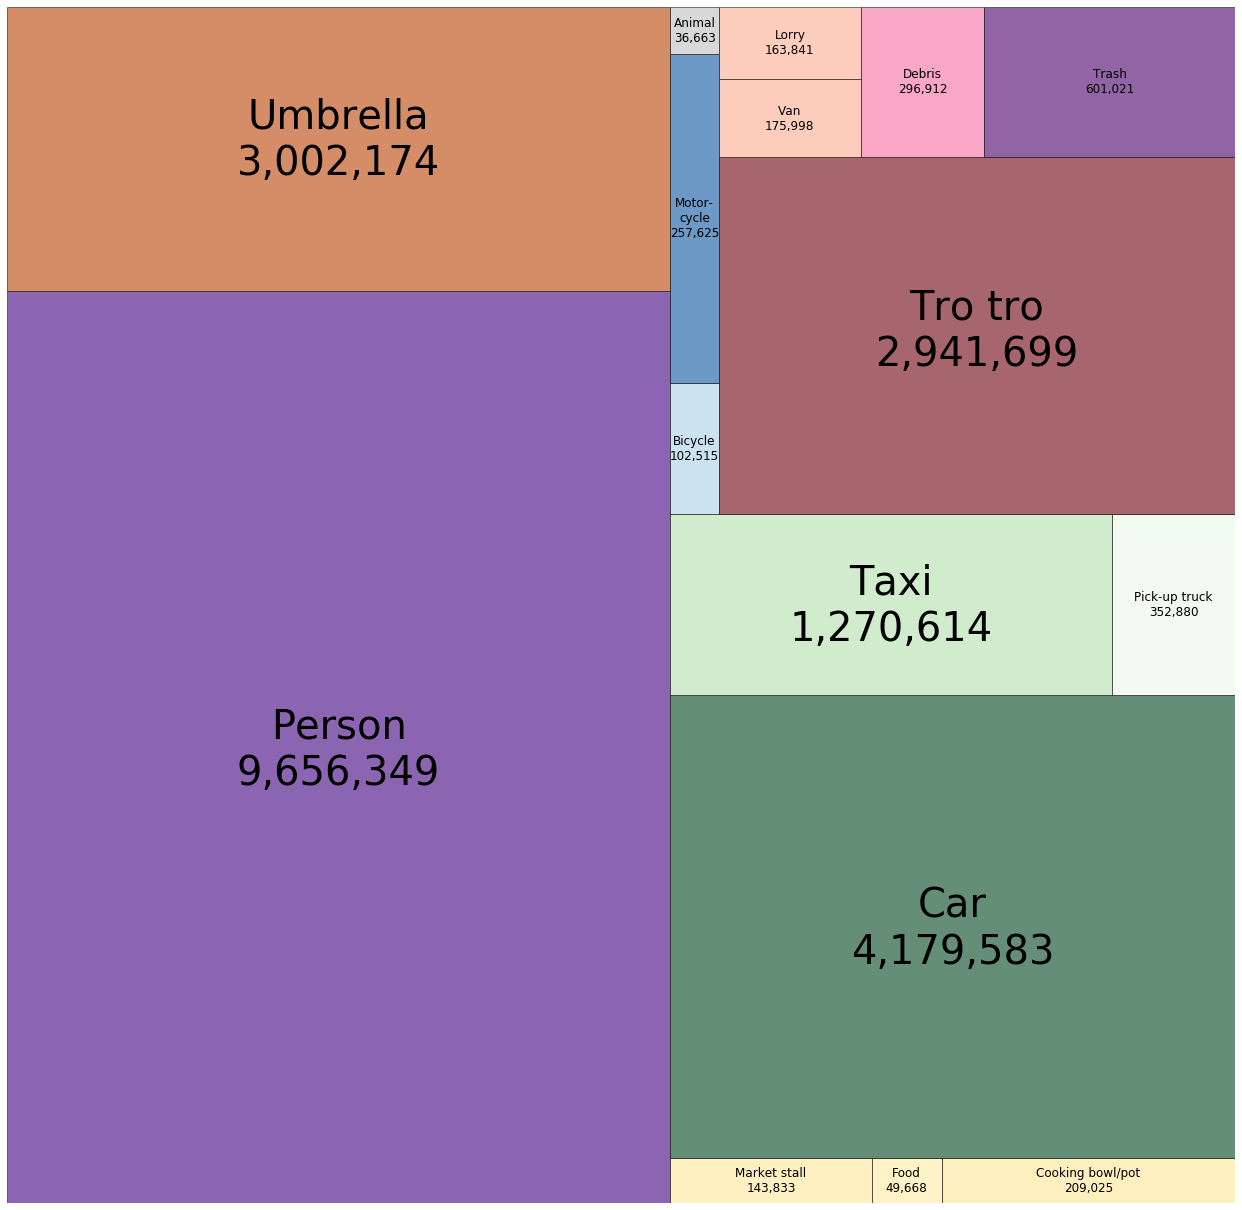

In [10]:
# Treemap generation

import matplotlib.colors as colors
fig, ax = plt.subplots(figsize=(22,22),linewidth=0)

tree_categories = ['person','umbrella', 'stall', 'food', 'bowl', 'car', 'taxi', 'truck','bicycle', 'motorcycle', 'animal','trotro', 'van', 'lorry', 'debris', 'trash']

total_counts = object_data['sums']['sites'][[cat+'_counts' for cat in tree_categories]].sum()#.sort_values(ascending=False)

sizes=[float(size/10000) for size in total_counts.values]

label=[obj[0].replace("trotro","tro tro")
             .replace("truck","pick-up truck")
             .replace("stall","market stall")
             .replace("bowl","cooking bowl/pot")
             .replace("_counts","\n"+str(f"{int(obj[1]):,}")).capitalize().replace("rcycle","r-\ncycle") for obj in zip(total_counts.index,total_counts.values)]
label_mod=label.copy()

for i in [0,1,5,6,11]:
    label_mod[i]= ""

cmap_1 = plt.cm.Purples
cmap_2 = plt.cm.YlOrBr
cmap_3 = plt.cm.Greens
cmap_4 = plt.cm.Blues
cmap_5 = plt.cm.Greys
cmap_6 = plt.cm.Reds
cmap_7 = plt.cm.RdPu

norm_1 = colors.Normalize(vmin=0, vmax=4000000)
norm_2 = colors.Normalize(vmin=-1000000, vmax=4000000)
norm_3 = colors.Normalize(vmin=0, vmax=4000000)
norm_4 = colors.Normalize(vmin=0, vmax=300000)
norm_5 = colors.Normalize(vmin=0, vmax=100000)
norm_6 = colors.Normalize(vmin=-1000000, vmax=3000000)
norm_7 = colors.Normalize(vmin=0, vmax=600000)

colors = [cmap_1(norm_1(value)) for value in total_counts.values[:1]]+\
         [cmap_2(norm_2(value)) for value in total_counts.values[1:5]]+\
         [cmap_3(norm_3(value)) for value in total_counts.values[5:8]]+\
         [cmap_4(norm_4(value)) for value in total_counts.values[8:10]]+\
         [cmap_5(norm_5(value)) for value in total_counts.values[10:11]]+\
         [cmap_6(norm_6(value)) for value in total_counts.values[11:14]]+\
         [cmap_7(norm_7(value)) for value in total_counts.values[14:]]

#print(label)
squarify.plot(sizes=sizes, label=label_mod, color=colors, alpha=0.6,text_kwargs={'fontsize':12, 'color':'black', 'fontweight':"medium"},bar_kwargs=dict(linewidth=1, edgecolor="#222222"))
fontsize = 40
plt.text(27,35, label[0], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(27, 86, label[1], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(77, 20, label[5], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(72, 47, label[6], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(79, 70, label[11], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.axis('off')
plt.show()
fig.savefig('results/treemap_final.pdf',format='pdf',edgecolor="#000000", bbox_inches='tight', pad_inches=0.1)

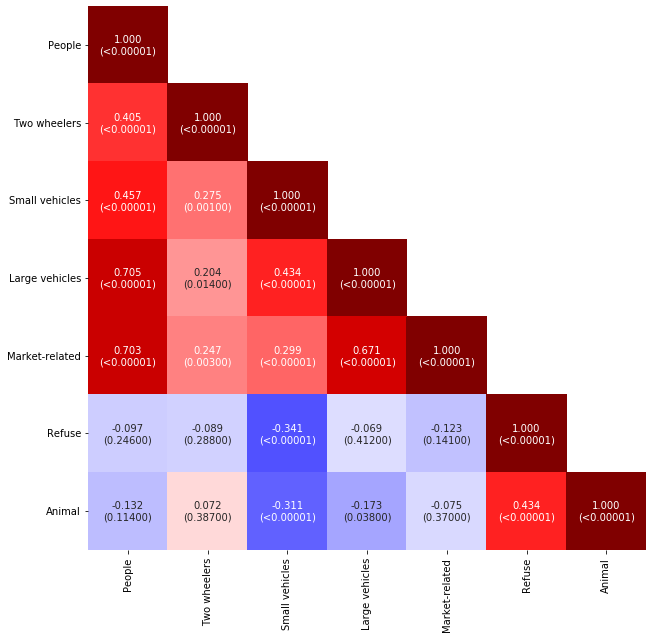

In [12]:
# Site correlations

corr_site = 'sums'

fig, ax = plt.subplots(figsize=(10,10))
corr_frame = object_data[corr_site]['sites']

#corr_categories = ['person', 'car', 'trash', 'trotro', 'debris', 'taxi', 'umbrella', 'truck', 'lorry', 'motorcycle', 'stall', 'van', 'animal', 'food', 'bicycle', 'bowl']
#corr_categories = ['person', 'bicycle', 'motorcycle', 'car', 'taxi', 'truck', 'trotro', 'van', 'lorry', 'umbrella', 'stall', 'food', 'bowl', 'animal', 'debris', 'trash']
corr_categories = ['people','two_wheelers','small_vehicles', 'large_vehicles', 'market', 'refuse', 'animal']

## This can be used instead of the correlation frame given above if one wishes for the correlation across all images instead of sites
# multi_frame = []
# for site in site_cams:
#     for cam in site_cams[site]:
#         multi_frame.append(object_data[site][cam].rename(columns={col+"_counts": col for col in corr_categories})[[col for col in corr_categories]])
# corr_frame = pd.concat(multi_frame)

cmap = 'seismic'
method = 'pearson'

# FOR P VALUES
p_frame = corr_frame[[obj for obj in corr_categories]].astype(float).rcorr(method=method, stars=False)

for obj in corr_categories:
    p_frame[obj][obj] = 0
    corr_frame[obj][obj] = 1

# FOR ACTUAL CORRELATION COEFFICIENTS
corr_frame = corr_frame[[obj for obj in corr_categories]].astype(float).corr(method=method)

text = np.asarray(p_frame.T)

labels = (np.asarray(["{:.3f}\n({:.5f})".format(float(data),float(text)) for text, data in zip(text.flatten(), corr_frame.to_numpy().flatten())])).reshape(7,7)

for j,row in enumerate(labels):
    for i,text in enumerate(row):
        labels[j][i]=text.replace("(0.00000)","(<0.00001)")

#print(labels)
mask = np.triu(np.ones_like(corr_frame, dtype=bool))

for i in range(len(mask)):
    mask[i,i] = False

# CORRELATION CO-EFFICIENTS
corr_plot = sns.heatmap(corr_frame.astype(float), annot=labels, fmt='',
          cmap=plt.get_cmap(cmap), vmin=-1,vmax=1, cbar=False, ax=ax, mask = mask)

ax.set_yticklabels([obj.replace('market', 'market-related').capitalize().replace("_"," ") for obj in corr_categories], rotation="horizontal")
ax.set_xticklabels([obj.replace('market', 'market-related').capitalize().replace("_"," ") for obj in corr_categories], rotation="vertical")

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

fig_type = "sites_supercat_final"

corr_plot.get_figure().savefig('results/'+fig_type+'_corr_'+method+'.pdf', format ='pdf', bbox_inches='tight', pad_inches=0.0)

In [21]:
# Create dataframe for geographic plotting

object_data['geo'] = {'cams':pd.DataFrame()}

for site in site_cams:
    site_cam_len = 0
    for cam in site_cams[site]: 
        site_cam_len += len(object_data[site][cam])
    if(site_cam_len > 1):
        site_counts = {cat+'_counts': 0 for cat in categories+['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse','animal','paratransit']}
        site_counts['im_len'] = 0
        site_counts['site']=site
        site_counts['site_type']=str(object_data[site][site_cams[site][0]]['site_type'][0])
        site_counts['lat'] = [object_data[site][site_cams[site][0]]['lat'][0]]
        site_counts['lon'] = [object_data[site][site_cams[site][0]]['lon'][0]]
        for cam in site_cams[site]:
            if(len(object_data[site][cam]) > 1):
                site_counts['im_len'] += len(object_data[site][cam])
                for cat in categories+['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse','paratransit']:
                    site_counts[cat+'_counts'] += object_data[site][cam][cat+'_counts'].sum()
        for cat in categories+['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse','animal','paratransit']:
            site_counts[cat+'_norm_counts'] =  [float(int(site_counts[cat+'_counts']))/site_counts['im_len']]

    object_data['geo']['cams'] = pd.concat([object_data['geo']['cams'],pd.DataFrame(site_counts)], ignore_index = True)

In [23]:
# Create Geopandas dataframe

geometry = [Point(xy) for xy in zip(object_data['geo']['cams'].lon, object_data['geo']['cams'].lat)]
crs = {'init': 'epsg:4326'} #http://www.spatialreference.org/ref/epsg/2263/
geo_df = GeoDataFrame( object_data['geo']['cams'], crs=crs, geometry=geometry)

acc = geopandas.read_file('GAMA_boundV2.shp')
roads = geopandas.read_file('roads.shp')

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


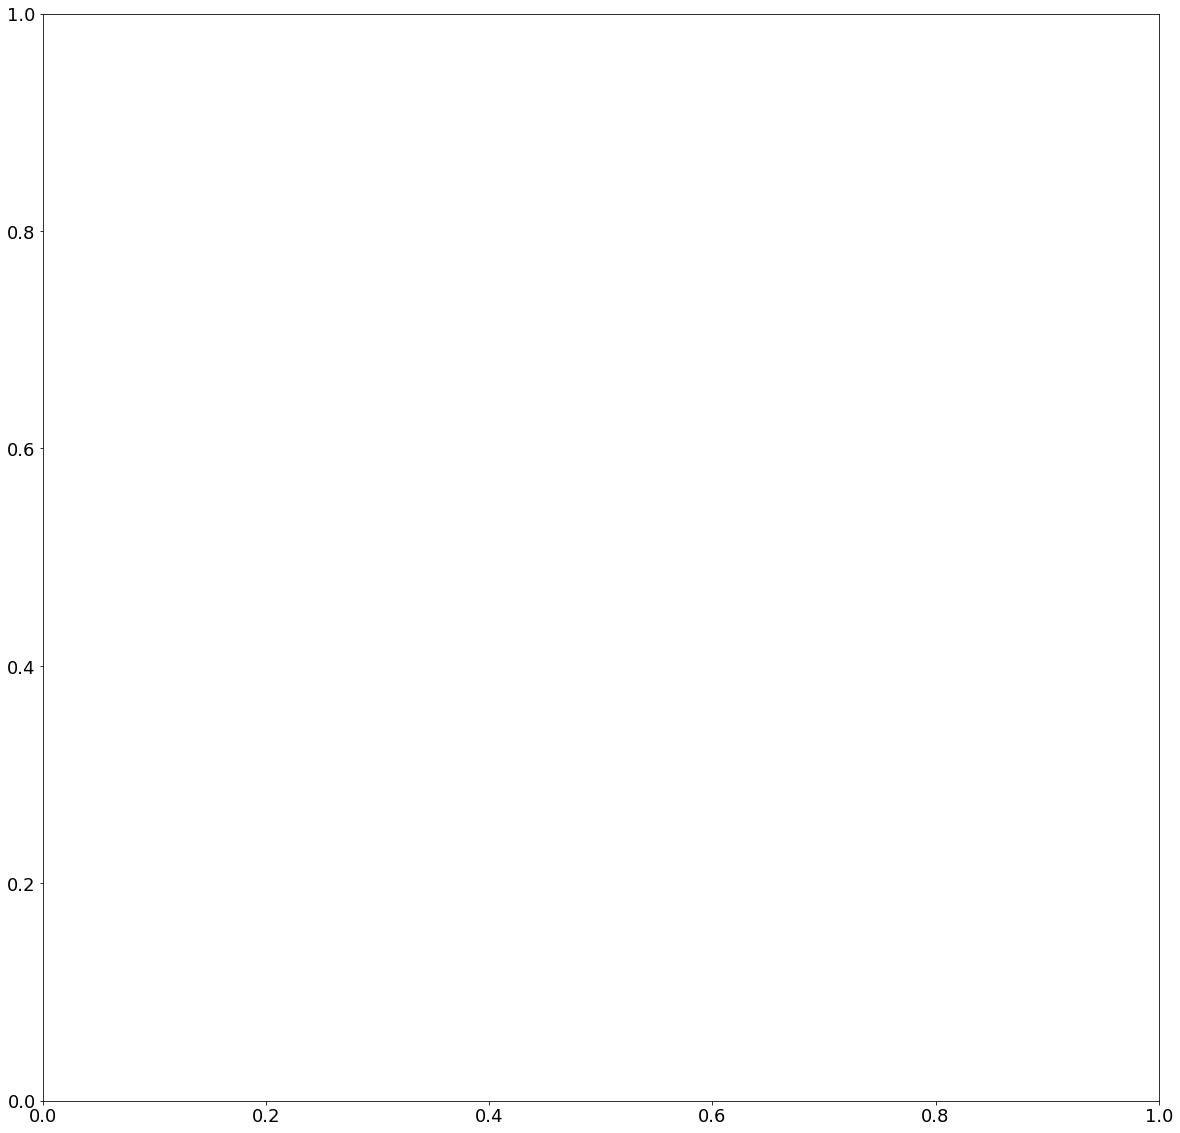

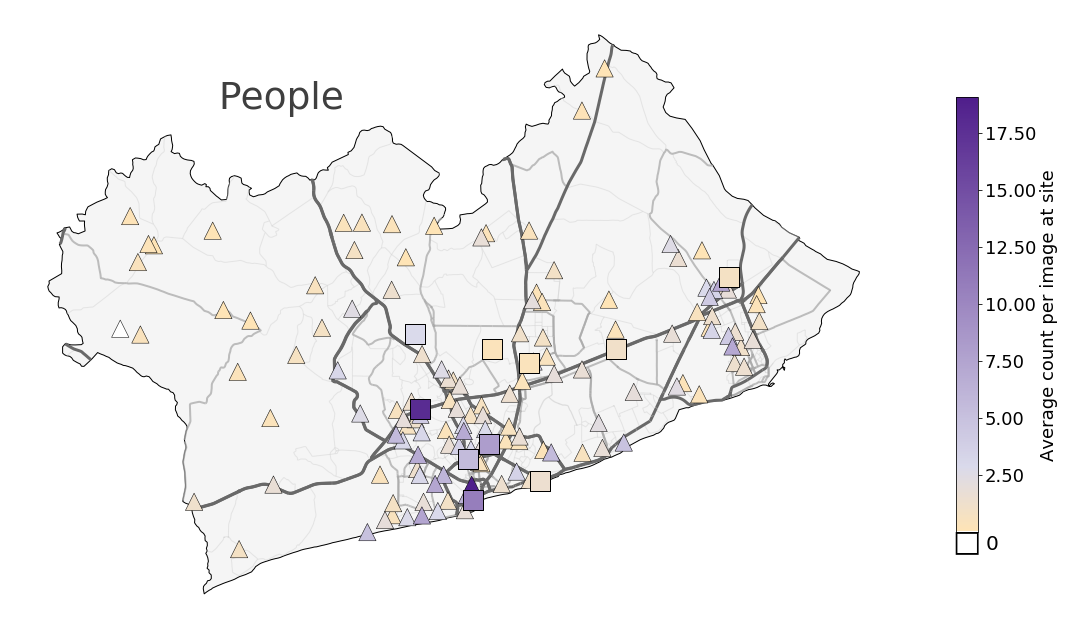

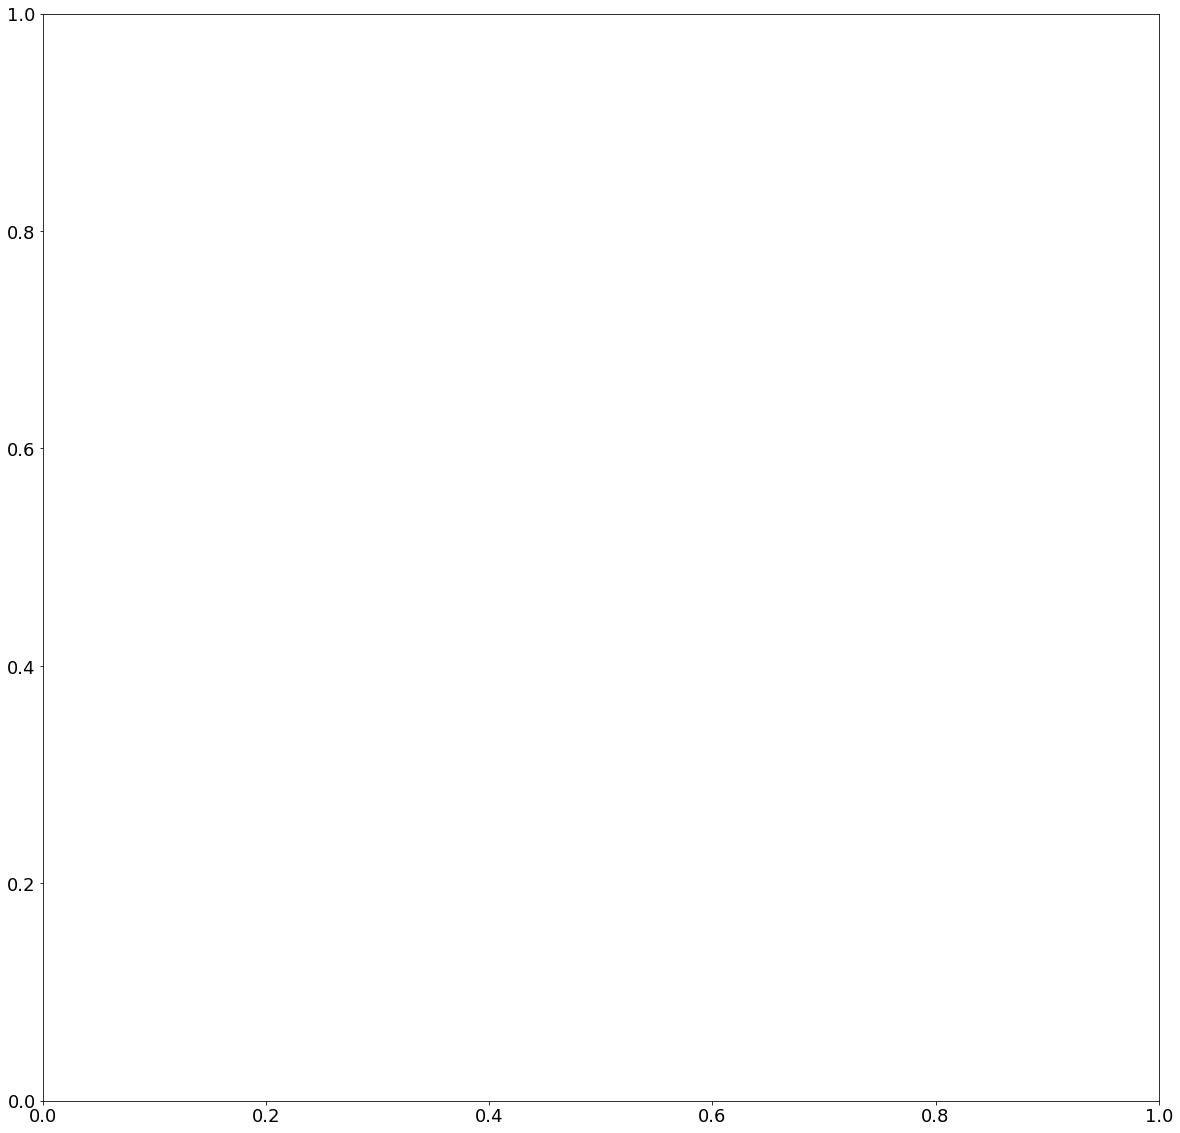

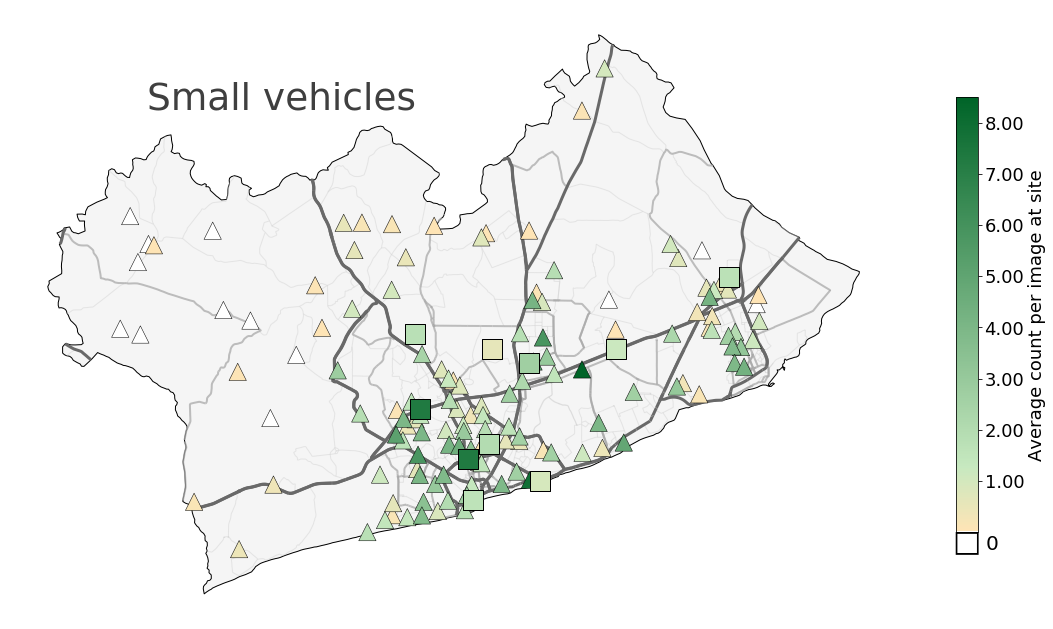

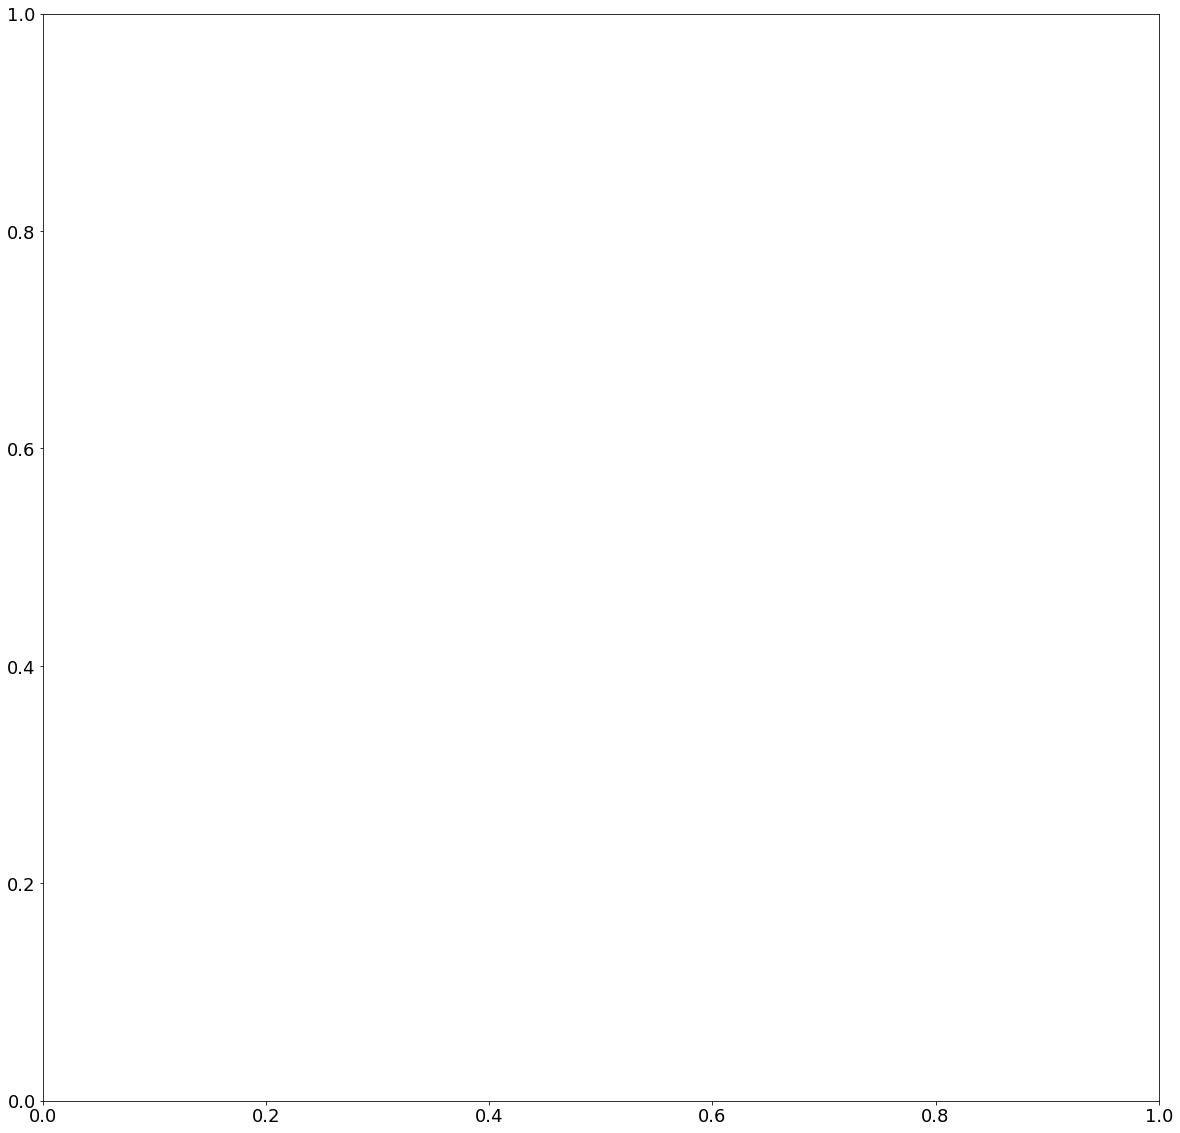

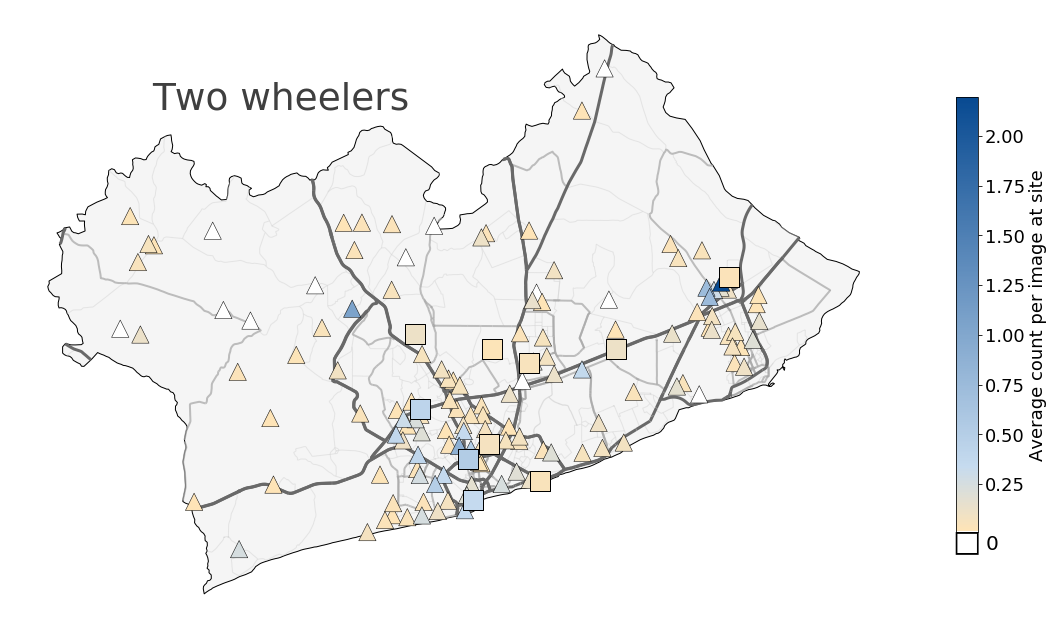

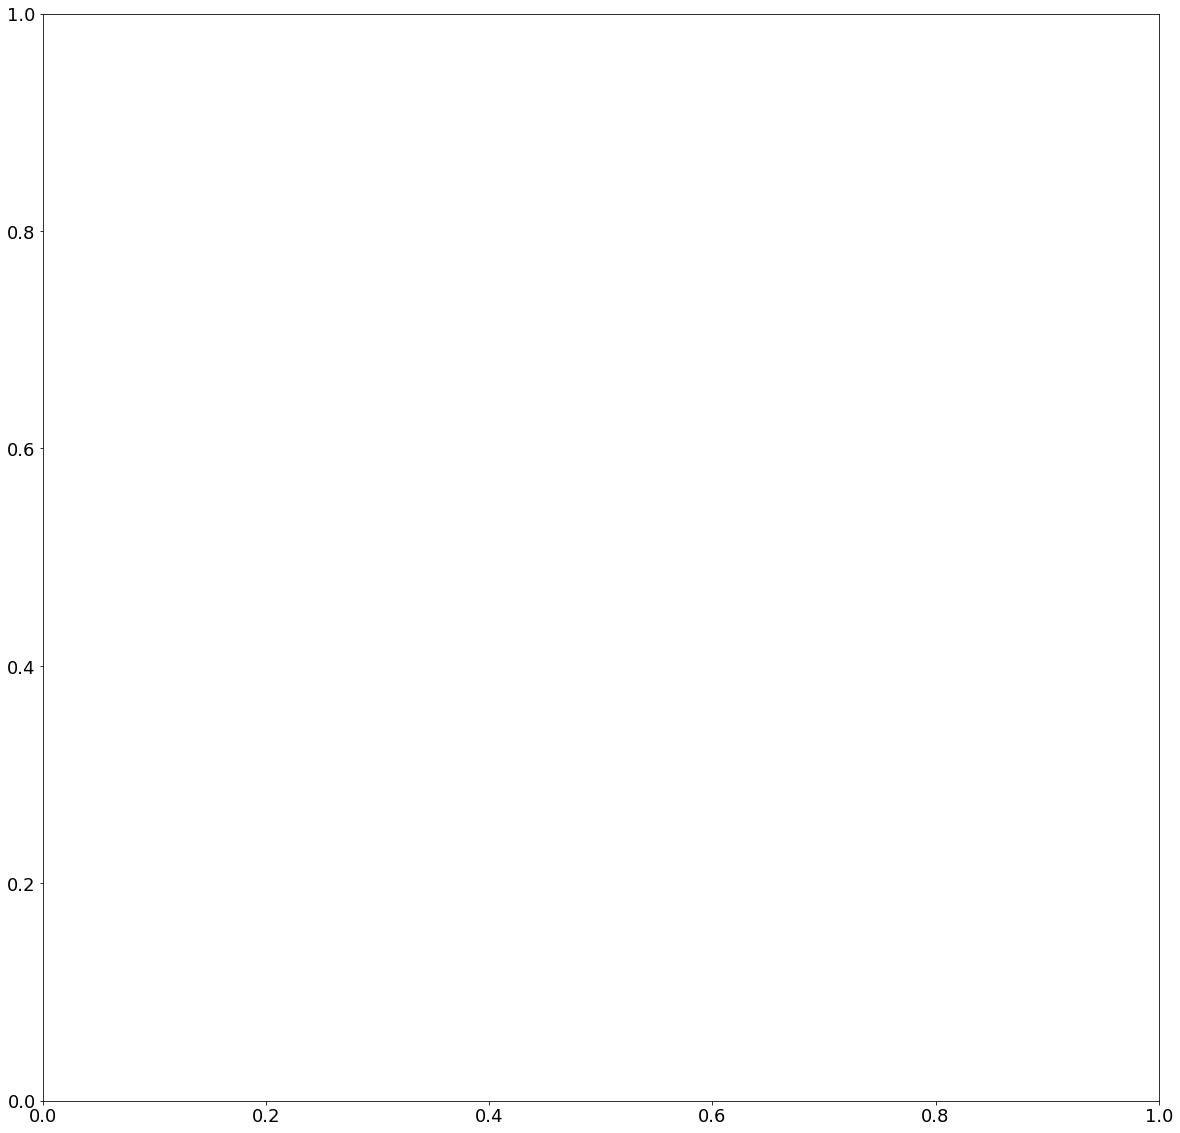

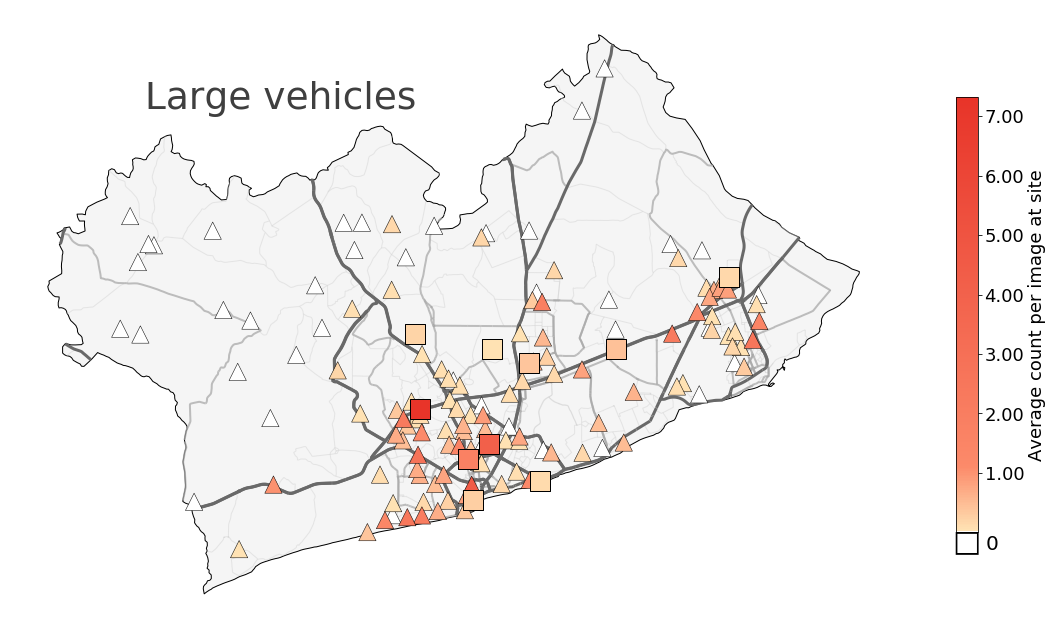

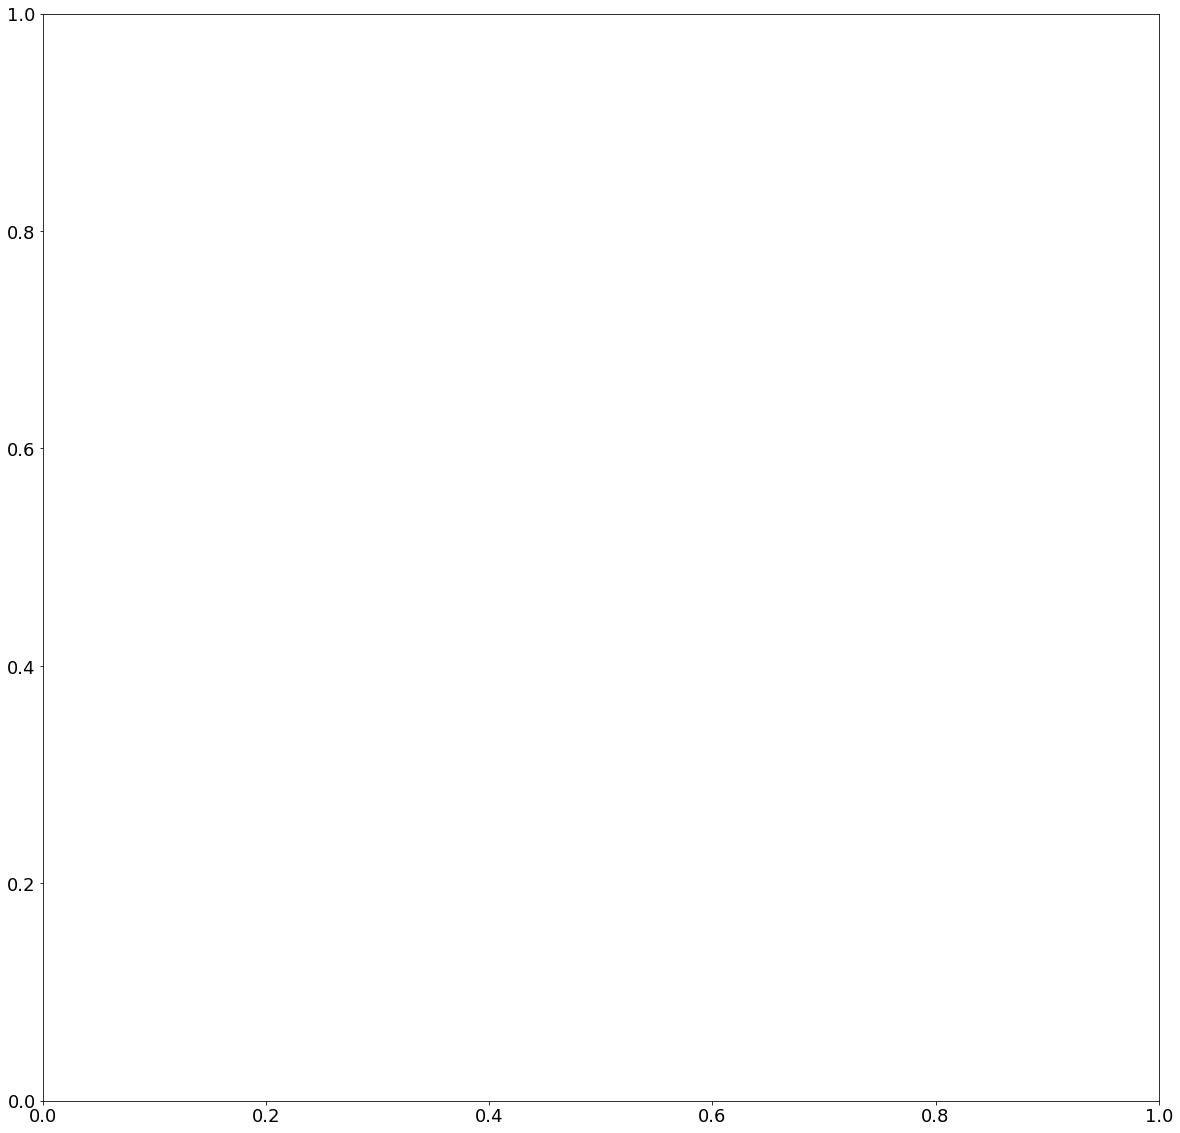

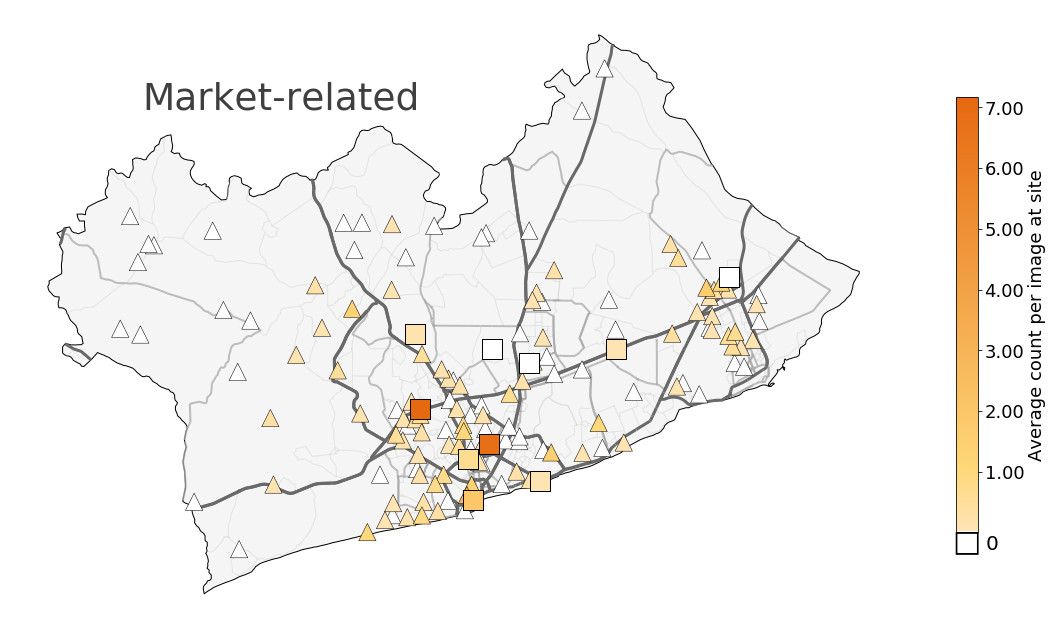

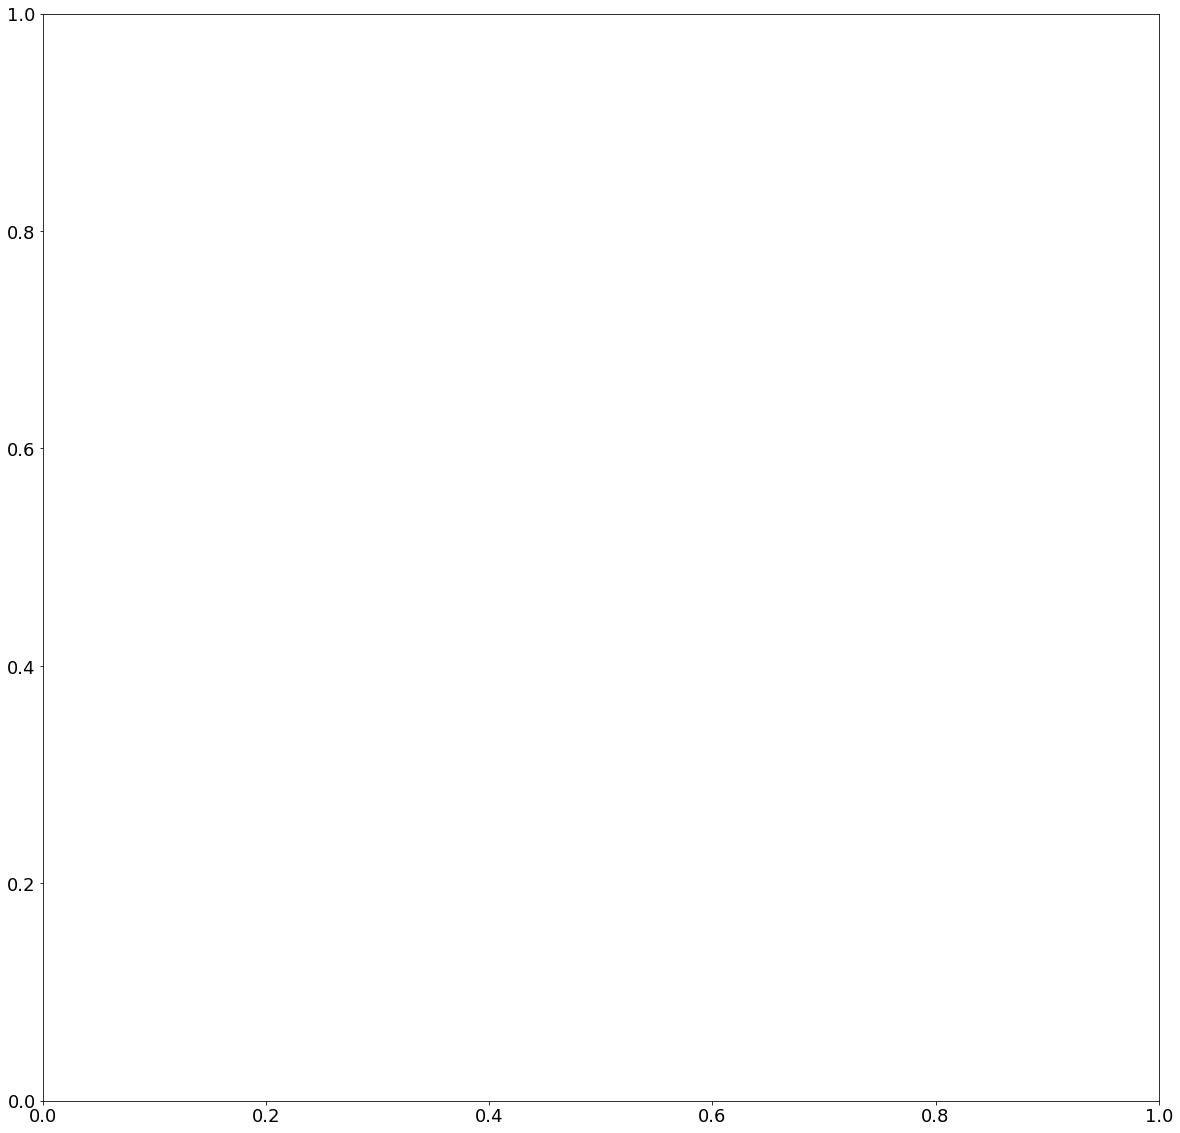

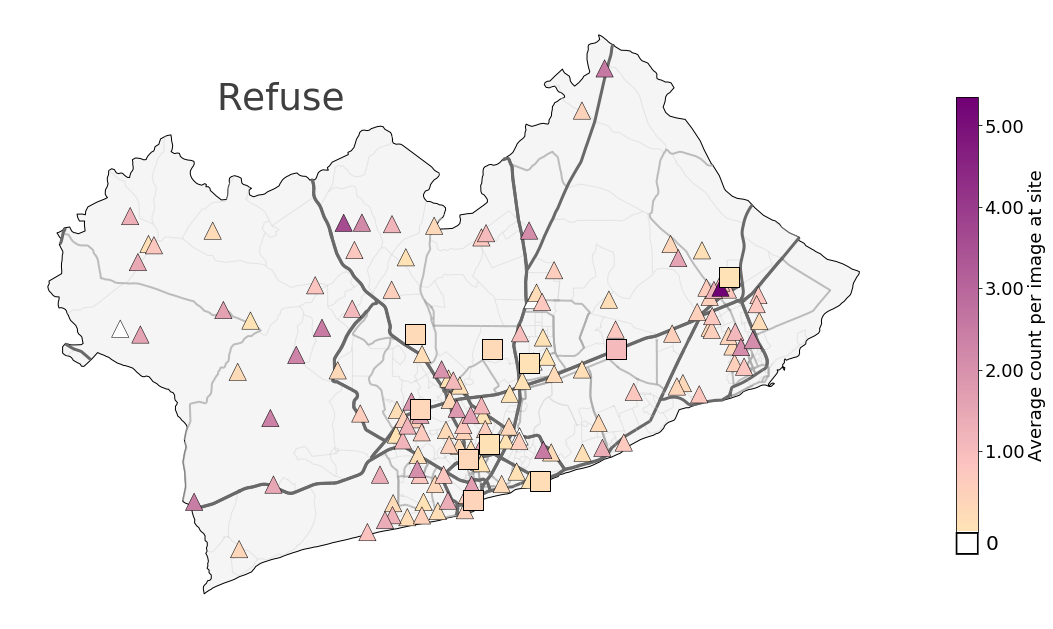

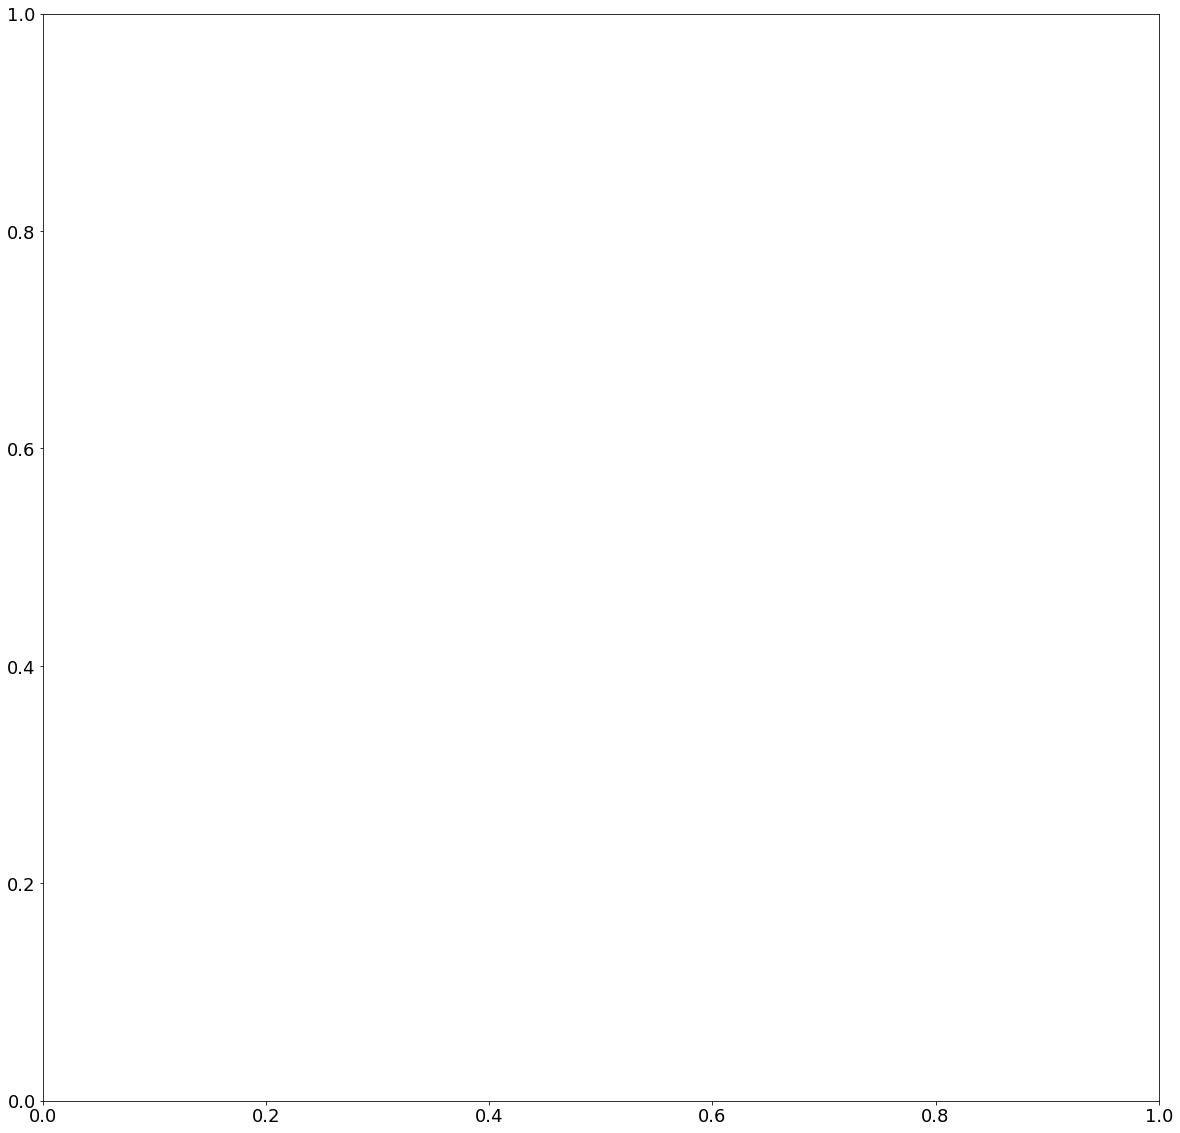

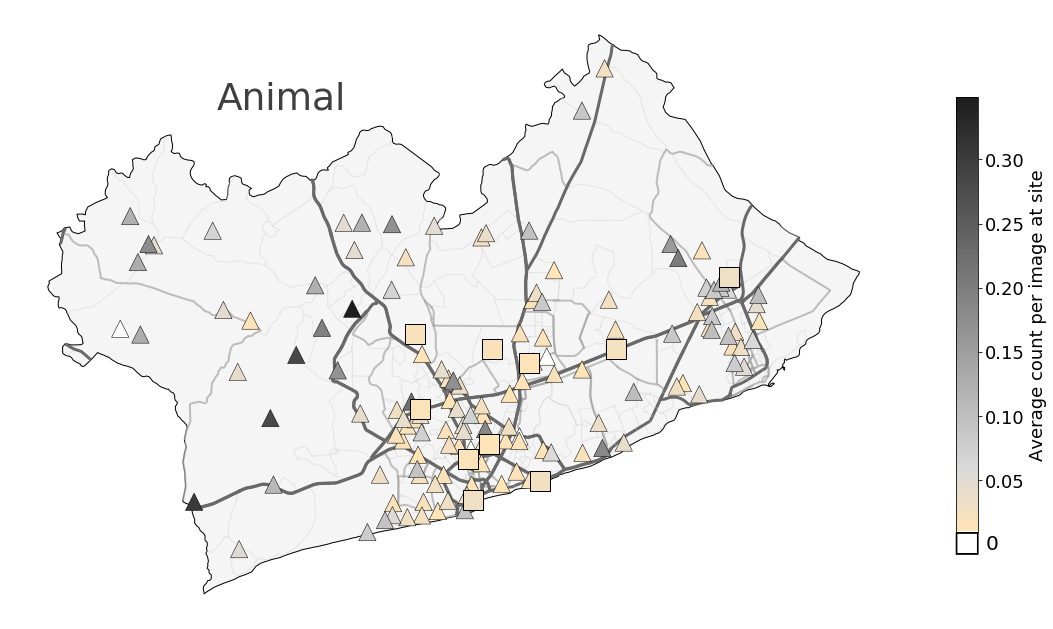

In [24]:
# Plot spatial distribution

import matplotlib.colors as colors
plt.rcParams.update({'font.size': 18})

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors

trunk = roads['code'] == 5112 
primary = roads['code'] == 5113
secondary = roads['code'] == 5114
tertiary = roads['code'] == 5115
cycleway = roads['code'] == 5152

color_dict = {}

color_dict['people'] = plt.cm.Purples
color_dict['market'] = plt.cm.YlOrBr
color_dict['small_vehicles'] = plt.cm.Greens
color_dict['two_wheelers'] = plt.cm.Blues
color_dict['animal'] = plt.cm.Greys
color_dict['large_vehicles'] = plt.cm.Reds
color_dict['refuse'] = plt.cm.RdPu

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=20):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Function that generates the colorbars for the plot.
def map_cmap(color_dict, obj):

    if obj=='market':
        cmap_trunc = truncate_colormap(color_dict, 0.30, 0.65)
    elif obj=='large_vehicles':
        cmap_trunc = truncate_colormap(color_dict, 0.40, 0.65)
    else:
        cmap_trunc = truncate_colormap(color_dict, 0.25, 0.9)

    cmaplist = [cmap_trunc(i) for i in range(cmap_trunc.N)]

    bar_colors = ["moccasin",cmaplist[0], cmaplist[len(cmaplist)-1]]
    nodes = [0.0,0.15, 1.0]

    cmap_1 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, bar_colors)))

    cmaplist = [cmap_1(i) for i in range(cmap_1.N)]
    # force the first color entry to be white
    cmaplist[0] = (1.0, 1.0, 1.0, 1.0)

    bar_colors_2 = ["white","white"]
    nodes_2 = [0.0, 1.0]

    cmap_2 = LinearSegmentedColormap.from_list("mycmap_2", list(zip(nodes_2, bar_colors_2)))

    num_cols = cmap_1.N
    cmap_1 = colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, num_cols)
    
    # combine them and build a new colormap
    N = 1000
    bar_colors = np.vstack((cmap_2(np.linspace(0, 1, (N/10)-1)),
                       cmap_1(np.linspace(0, 1, N))))
    
    new_cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', bar_colors)    
    return new_cmap, cmap_1

plot_cats = ['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse', 'animal']

for obj in plot_cats: 
    new_cmap, cbar_cmap = map_cmap(color_dict[obj], obj)

    
    fig, ax = plt.subplots(figsize=(20,20))    
    ax = acc.to_crs(epsg=4326).plot(facecolor="whitesmoke", edgecolor="black", figsize=(20,20), alpha=1,zorder=1)
    ax.set_axis_off()
    roads[tertiary].to_crs(epsg=4326).plot(figsize=(20,20), ax=ax,zorder=2, linewidth=1, color='lightgrey',alpha=0.5)
    roads[secondary].to_crs(epsg=4326).plot(figsize=(20,20), ax=ax,zorder=3, linewidth=2, color='darkgrey',alpha=0.75)
    roads[trunk | primary].to_crs(epsg=4326).plot(figsize=(20,20), ax=ax,zorder=4, linewidth=3, color='dimgrey',alpha=1)

    obj_max = geo_df[obj+'_norm_counts'].max()
    #geo_df[geo_df['site'].str.startswith('S')].sort_values(by=obj+'_norm_counts',ascending=True).to_crs(epsg=4326).plot(ax=ax, alpha=1, zorder=5, marker="^", column = obj+'_norm_counts',markersize=300,linewidth=0.5,edgecolor='black', cmap=new_cmap, vmin=-obj_max/10,vmax=obj_max,legend=True,legend_kwds={'label': "Average count per image at site",'orientation': "vertical",'shrink': 0.4, 'format': '%.2f'})
    geo_df[geo_df['site'].str.startswith('S')].sort_values(by=obj+'_norm_counts',ascending=True).to_crs(epsg=4326).plot(ax=ax, alpha=1, zorder=5, marker="^", column = obj+'_norm_counts',markersize=300,linewidth=0.5,edgecolor='black', cmap=new_cmap, vmin=-obj_max/10,vmax=obj_max,legend=False)
    geo_df[~geo_df['site'].str.startswith('S')].sort_values(by=obj+'_norm_counts',ascending=True).to_crs(epsg=4326).plot(ax=ax, alpha=1, zorder=6, marker="s", column = obj+'_norm_counts',markersize=400,linewidth=1,edgecolor='black', vmin=-obj_max/10,vmax=obj_max, cmap=new_cmap,legend=False)
    geo_df[geo_df['site'].str.startswith('S')].sort_values(by=obj+'_norm_counts',ascending=True).to_crs(epsg=4326).plot(ax=ax, alpha=0, zorder=7, marker=",", column = obj+'_norm_counts',markersize=0,linewidth=0,edgecolor='black', cmap=cbar_cmap, vmin=0.01,vmax=obj_max,legend=True,legend_kwds={'label': "Average count per image at site",'orientation': "vertical",'shrink': 0.4, 'format': '%.2f'})

    ax.text(-0.35, 5.825, obj.replace('market', 'market-related').capitalize().replace('_',' '), color='black',fontsize='37.5',alpha=0.75,horizontalalignment='center')
    #ax.text(0.1, 5.52, '□ - 0', color='black',fontsize='25',alpha=1,horizontalalignment='center')
    ax.text(0.13925, 5.505, '□', color='black',fontsize='30',alpha=1,horizontalalignment='left')
    ax.text(0.173, 5.505, '0', color='black',fontsize='20',alpha=1,horizontalalignment='right')

    plt.savefig('results/maps/'+obj+'_med.pdf', format='pdf')

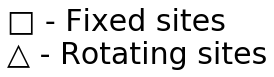

In [38]:
fig, ax = plt.subplots(figsize=(4,1.1))    
ax.set_axis_off()

ax.text(-0.15, 0.1, '□ - Fixed sites\n△ - Rotating sites', color='black',fontsize='30',alpha=1,horizontalalignment='left')
plt.savefig('results/maps/legend.pdf', format='pdf')

In [25]:
plot_categories = ['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse', 'animal']

for obj in plot_categories:
    for site in site_cams:
        if(site.lower() != 's'):
            for cam in site_cams[site]:
                object_data[site][cam][obj+"_rank"] = None

In [26]:
# Functions for plotting Range plots

def object_hour_samples(object_data_frame,site_cams_dict, obj):

    trend_cols = ['site_cam','site_type','object','hour','counts_per_hour']

    week_totals = pd.DataFrame(columns=trend_cols)

    for site in site_cams_dict:
        for cam in site_cams_dict[site]:
            if(len(object_data_frame[site][cam]) > 100):
                campaign_bool = np.logical_and(object_data_frame[site][cam].index >= datetime.datetime(2019,4,10), object_data_frame[site][cam].index <= datetime.datetime(2020,6,11))
                lock_bool = np.logical_or(object_data_frame[site][cam].index <= datetime.datetime(2020,3,30), object_data_frame[site][cam].index >= datetime.datetime(2020,4,20))
                date_bool = np.logical_and(campaign_bool,lock_bool)
                if(site in site_cams_dict):
                    if(site.lower()[0] != 's'):
                        if(object_data_frame[site][site_cams[site][0]]['site_type'][0] == 'traffic'):
                            site_type = 'commercial'
                        else:
                            site_type = object_data_frame[site][site_cams[site][0]]['site_type'][0]
                    else:
                        if(object_data_frame[site][cam]['site_type'][0] == 'traffic'):
                            site_type = 'commercial'
                        else:
                            site_type = object_data_frame[site][cam]['site_type'][0]
                else:
                    site_type = object_data_frame[site][cam]['site_type'][0]
                    
                WB_cat = object_data_frame[site][cam]['WB_cat'][0]
                pop_dens_cat = object_data_frame[site][cam]['pop_dens_cat'][0]
                ndvi_cat = object_data_frame[site][cam]['ndvi_cat'][0]
                road_surface = object_data_frame[site][cam]['road_surface'][0]
                road_type = object_data_frame[site][cam]['road_type'] [0]
                
                if(site.lower()[0] != 's' and len(object_data[site][cam][date_bool]) > 2016):
                    object_data_frame[site][cam][date_bool][obj+"_rank"] = object_data_frame[site][cam][date_bool][obj+'_counts'].astype(int).rank(method='first')
                    hour_df = object_data_frame[site][cam][date_bool][object_data_frame[site][cam][date_bool].index.hour == 0]
                    sample_rate = 84
                    #sample_rate = len(hour_df) 
                    #sample_rate = max(len(hour_df)/12,84)
                    sample_df = hour_df.sort_values(by=obj+"_rank").iloc[[i for i in range(0,len(hour_df),int(len(hour_df)/(sample_rate)))]+[len(hour_df)-1]]

                    for i in range(1,24):
                        hour_df = object_data_frame[site][cam][date_bool][object_data_frame[site][cam][date_bool].index.hour == i]
                        sample_rate = 84
                        #sample_rate = len(hour_df) 
                        #sample_rate = max(len(hour_df)/12,84) 
                        sample_df=sample_df.append(hour_df.sort_values(by=obj+"_rank").iloc[[i for i in range(0,len(hour_df),int(len(hour_df)/(sample_rate)))]+[len(hour_df)-1]])
                else:
                    sample_df = object_data_frame[site][cam][date_bool]
                        
                site_frame = pd.DataFrame(columns=trend_cols, index=sample_df.index)
                site_frame['counts_per_hour'] = sample_df[obj+'_counts'].astype(float)
                site_frame['hour'] = sample_df.index.hour.astype(int)
                site_frame['site_cam'] = site+'_'+cam
                site_frame['site_type'] = site_type
                site_frame['ndvi_cat'] = ndvi_cat
                site_frame['pop_dens_cat'] = pop_dens_cat
                site_frame['WB_cat'] = WB_cat
                site_frame['road_type'] = road_type               
                site_frame['object'] = obj
                week_totals = week_totals.append(site_frame).sort_index()

    week_totals.reset_index(inplace=True)
    return week_totals

def object_hour_lockdown(object_data_frame,site_cams_dict, obj, lockdown):

    trend_cols = ['site_cam','site_type','object','hour','counts_per_hour']

    week_totals = pd.DataFrame(columns=trend_cols)
    
    site_bools={'other', 'low-dens', 'high-dens'}
    for site in site_cams_dict:
        for cam in site_cams_dict[site]:
            lock_bool = np.logical_and(object_data_frame[site][cam].index >= datetime.datetime(2020,3,30), object_data_frame[site][cam].index <= datetime.datetime(2020,4,20))
            if(len(object_data_frame[site][cam][lock_bool]) > 100):
                if(lockdown == 'lockdown'):
                    date_bool = lock_bool
                elif(lockdown == 'post_lockdown'):
                    date_bool = object_data_frame[site][cam].index >= datetime.datetime(2020,4,20)
                else:
                    date_bool = np.logical_and(object_data_frame[site][cam].index >= datetime.datetime(2019,4,10), object_data_frame[site][cam].index <= datetime.datetime(2020,3,30))
                if(site in site_cams_dict):
                    if(site.lower()[0] != 's'):
                        if(object_data_frame[site][site_cams[site][0]]['site_type'][0] == 'traffic'):
                            site_type = 'commercial'
                        else:
                            site_type = object_data_frame[site][site_cams[site][0]]['site_type'][0]
                    else:
                        if(object_data_frame[site][cam]['site_type'][0] == 'traffic'):
                            site_type = 'commercial'
                        else:
                            site_type = object_data_frame[site][cam]['site_type'][0]
                else:
                    site_type = object_data_frame[site][cam]['site_type'][0]
                    
                WB_cat = object_data_frame[site][cam]['WB_cat'][0]
                pop_dens_cat = object_data_frame[site][cam]['pop_dens_cat'][0]
                ndvi_cat = object_data_frame[site][cam]['ndvi_cat'][0]
                road_surface = object_data_frame[site][cam]['road_surface'][0]
                road_type = object_data_frame[site][cam]['road_type'] [0]
                
                if(site.lower()[0] != 's' and len(object_data[site][cam][date_bool]) > 2016):
                    object_data_frame[site][cam][date_bool][obj+"_rank"] = object_data_frame[site][cam][date_bool][obj+'_counts'].astype(int).rank(method='first')
                    hour_df = object_data_frame[site][cam][date_bool][object_data_frame[site][cam][date_bool].index.hour == 0]
                    sample_rate = 84
                    sample_df = hour_df.sort_values(by=obj+"_rank").iloc[[i for i in range(0,len(hour_df),int(len(hour_df)/(sample_rate)))]+[len(hour_df)-1]]

                    for i in range(1,24):
                        hour_df = object_data_frame[site][cam][date_bool][object_data_frame[site][cam][date_bool].index.hour == i]
                        sample_rate = 84
                        sample_df=sample_df.append(hour_df.sort_values(by=obj+"_rank").iloc[[i for i in range(0,len(hour_df),int(len(hour_df)/(sample_rate)))]+[len(hour_df)-1]])
                else:
                    sample_df = object_data_frame[site][cam][date_bool]
                    
                site_frame = pd.DataFrame(columns=trend_cols, index=sample_df.index)
                site_frame['counts_per_hour'] = sample_df[obj+'_counts'].astype(float)
                site_frame['hour'] = sample_df.index.hour.astype(int)
                site_frame['site_cam'] = site+'_'+cam
                site_frame['site_type'] = site_type
                site_frame['ndvi_cat'] = ndvi_cat
                site_frame['pop_dens_cat'] = pop_dens_cat
                site_frame['WB_cat'] = WB_cat
                site_frame['road_type'] = road_type                
                site_frame['object'] = obj
                week_totals = week_totals.append(site_frame).sort_index()

    week_totals.reset_index(inplace=True)
    return week_totals

['Medium/low-density\nResidential', 'High-density\nresidental', 'Commercial/business/\nindustrial', 'Peri-urban background']
people


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


small_vehicles


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


two_wheelers


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


large_vehicles


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


market


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


refuse


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


animal


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


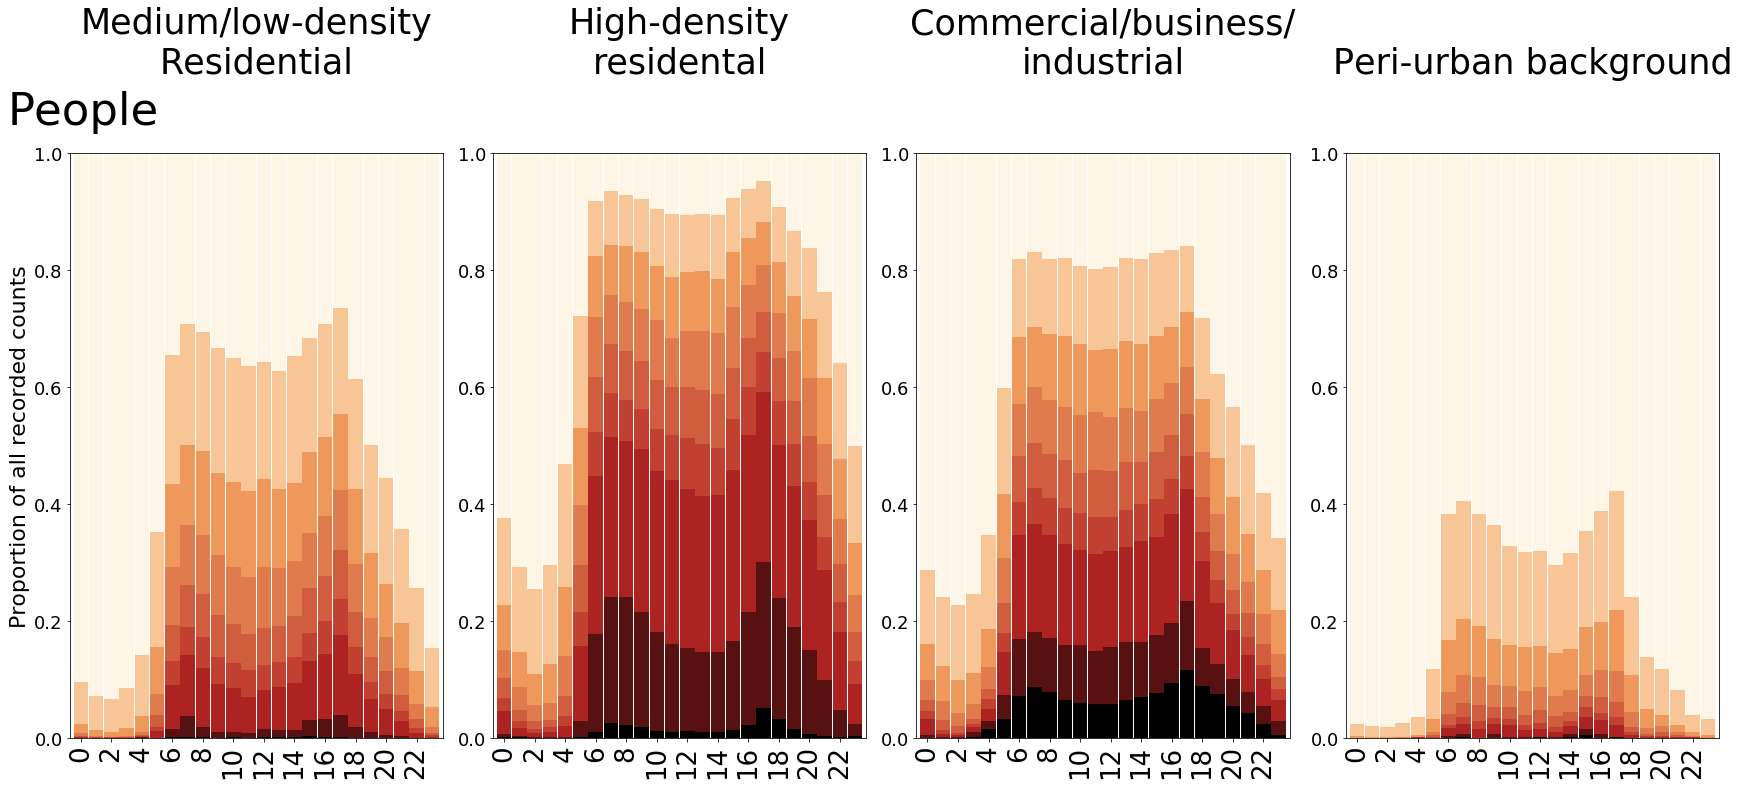

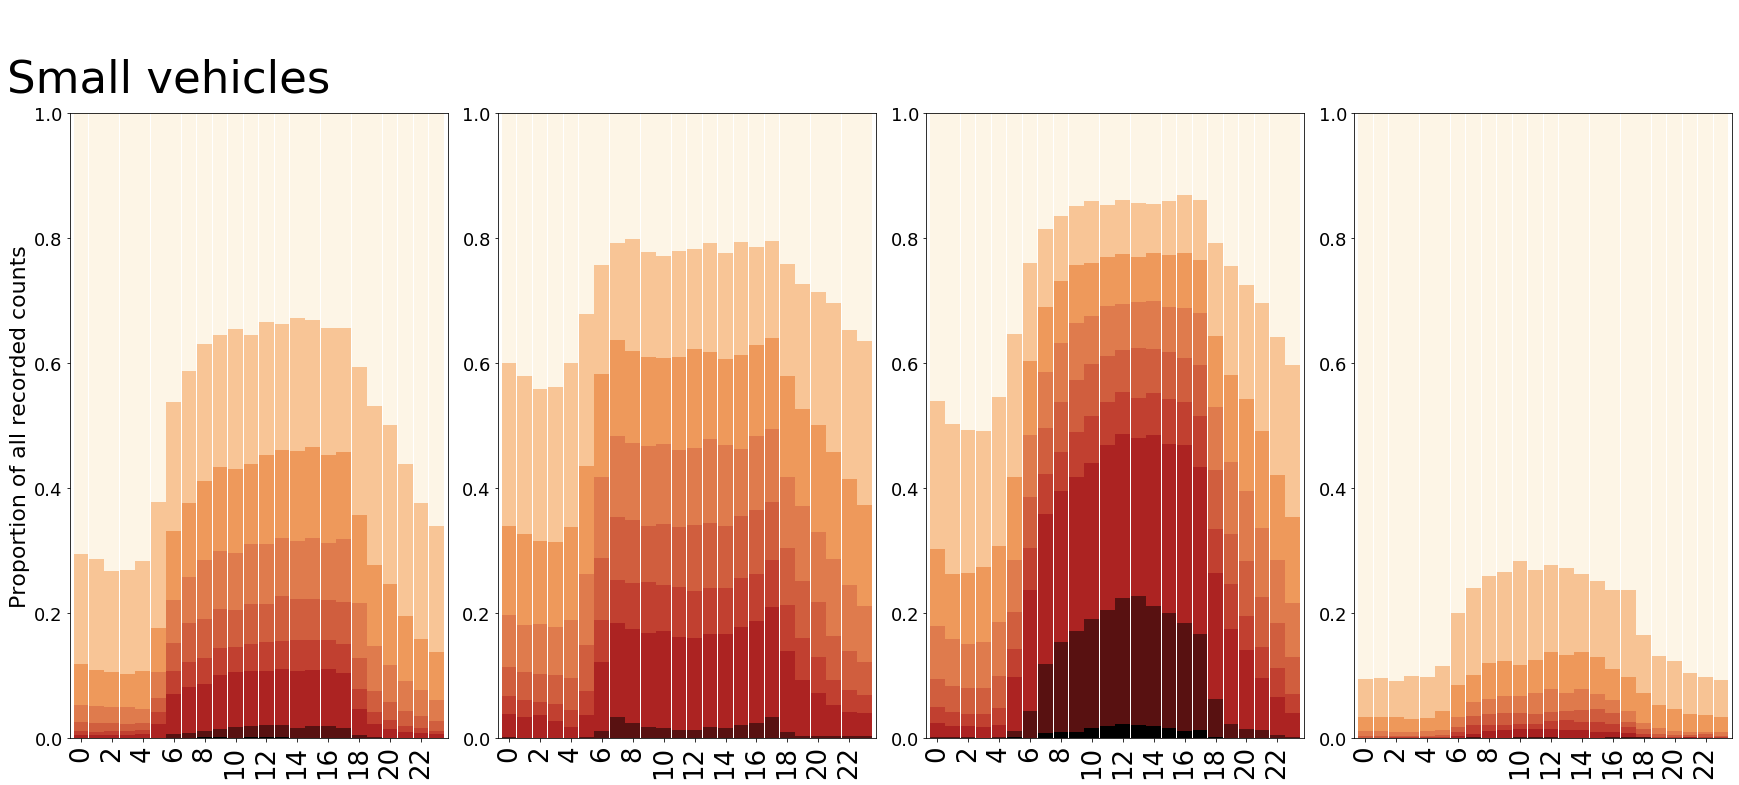

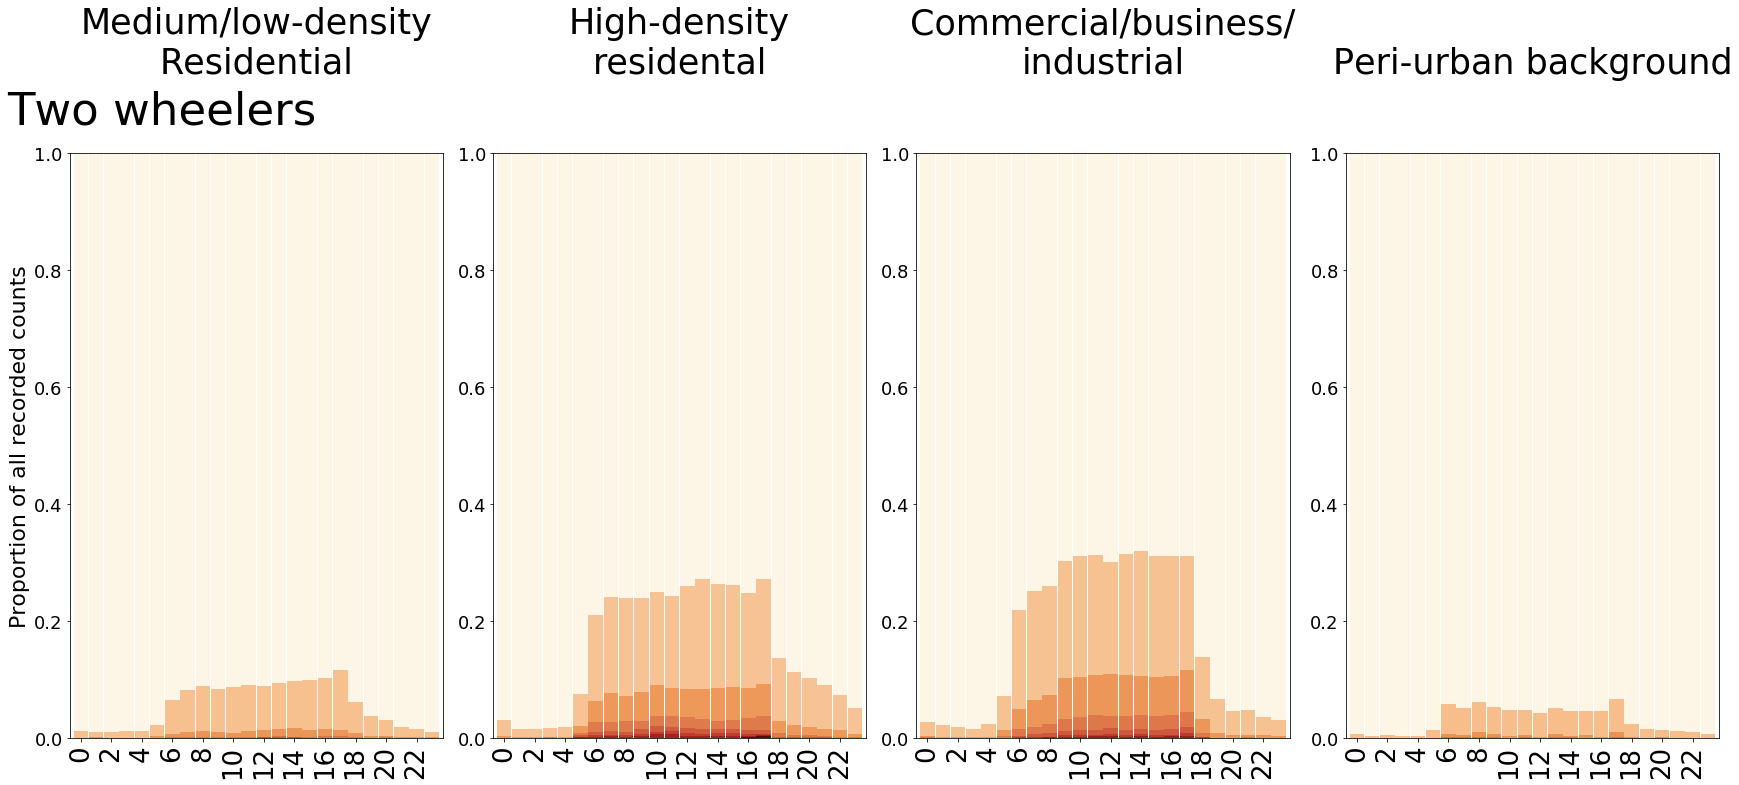

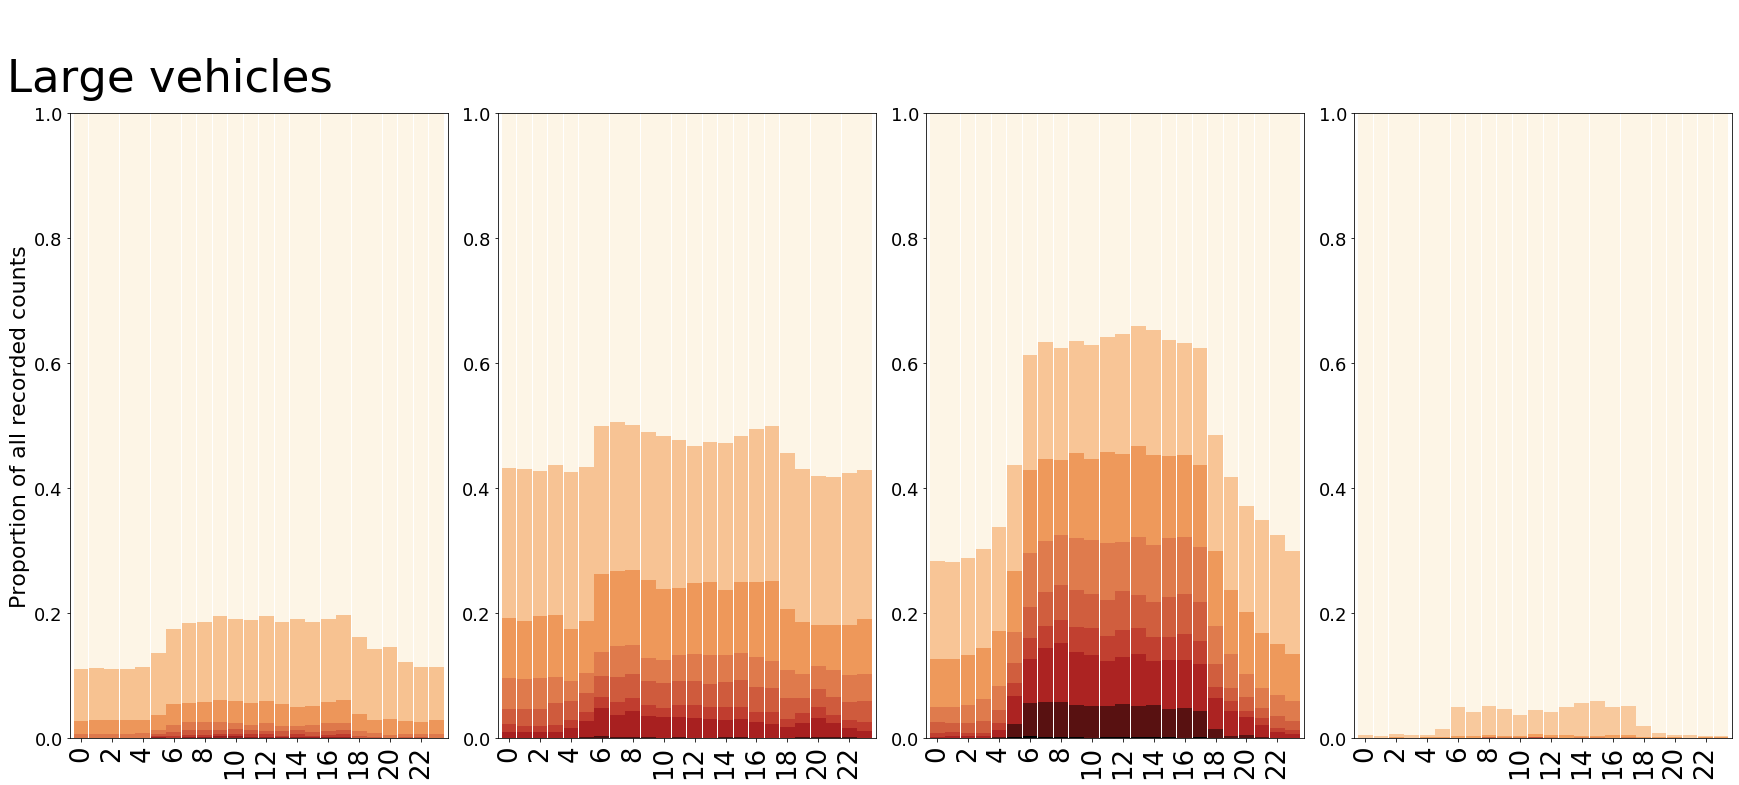

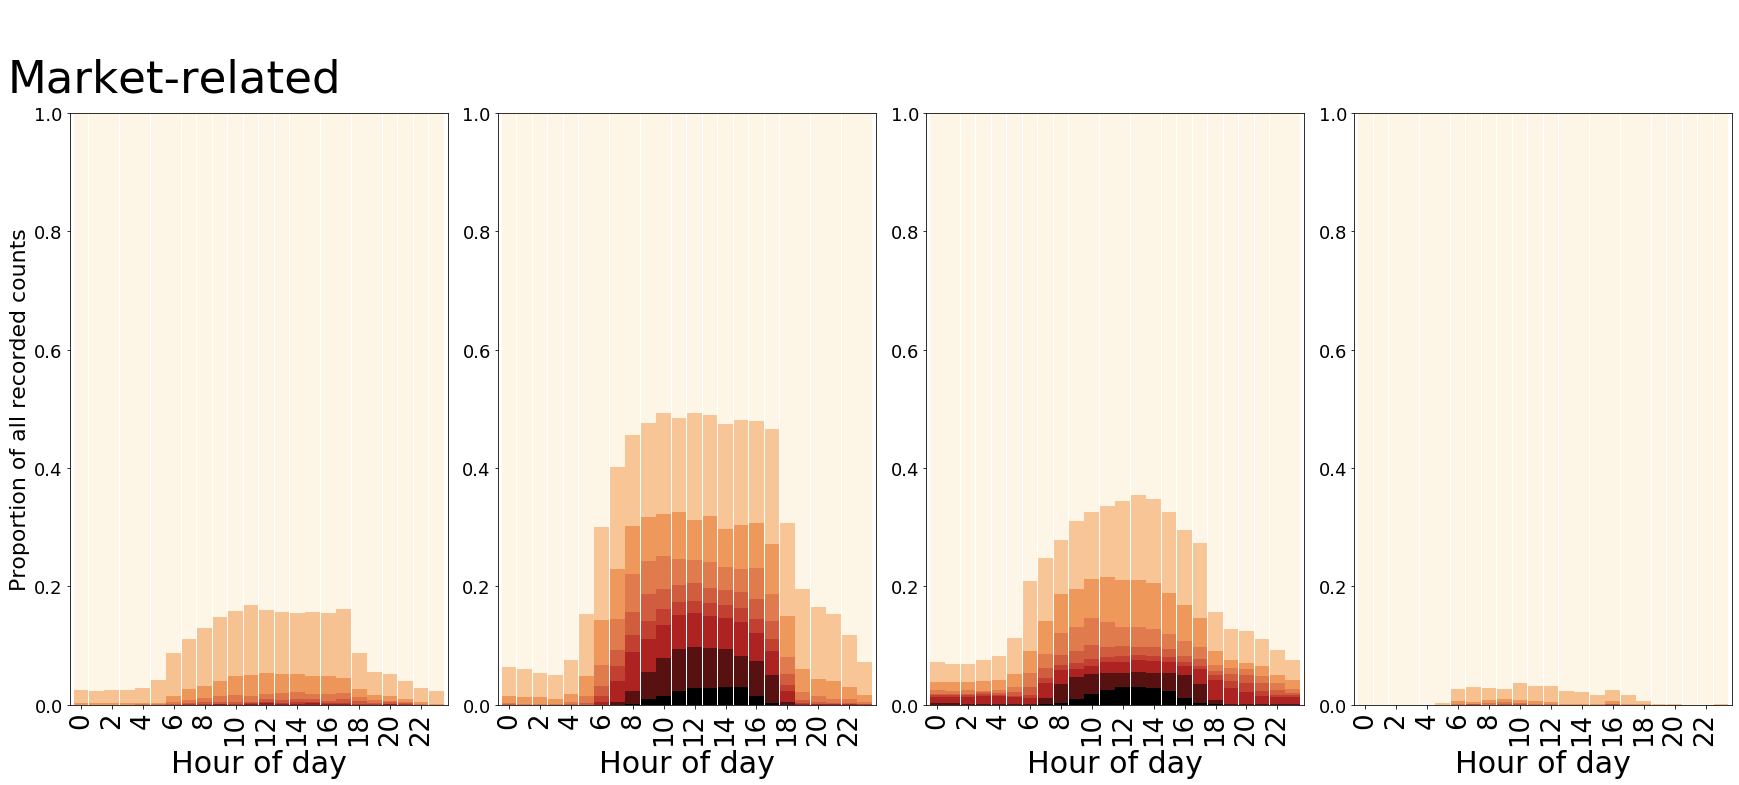

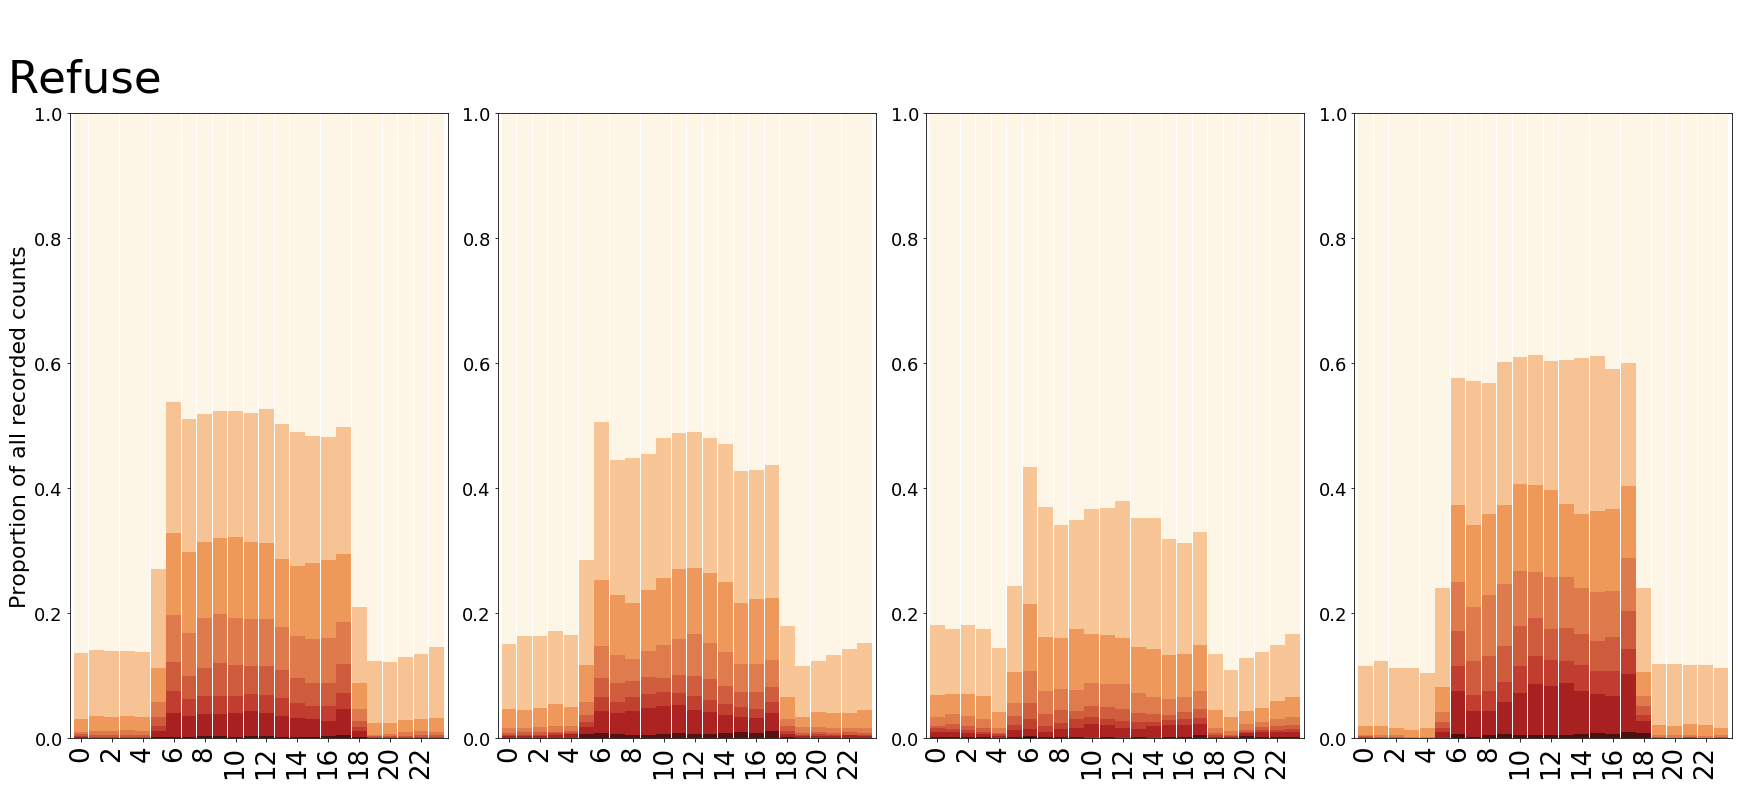

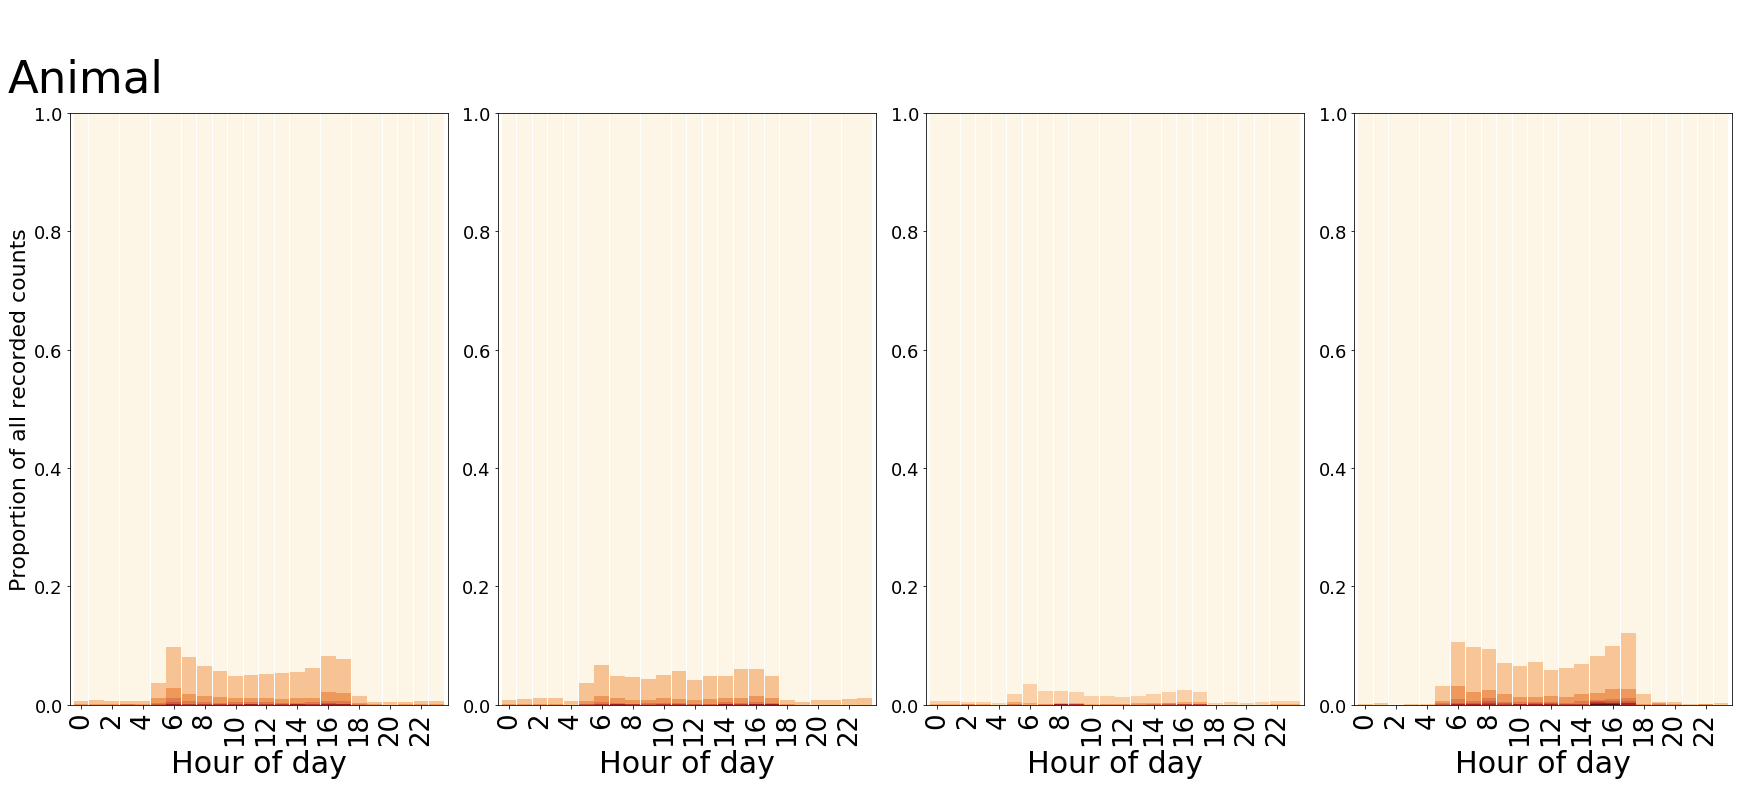

In [28]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors
import matplotlib.colors as mcolors
plt.rcParams['legend.title_fontsize'] = 'large'

def simpleaxis(ax):
    ax.spines['bottom'].set_visible(False)    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_top()

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=20):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


plot_colors = ["black", "firebrick", "sandybrown", "oldlace"]
nodes = [0.0, 0.25, 0.8, 1.0]
    
cmap_range = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, plot_colors)))

#plot_categories = ['car', 'person', 'trotro', 'stall', 'truck', 'motorcycle', 'lorry', 'umbrella', 'trash', 'taxi', 'van', 'debris', 'bowl', 'food', 'animal', 'bicycle']
plot_categories = ['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse', 'animal']#,'paratransit']

quantiles = [0,0.25,0.5,0.75,0.875,0.9375,0.96875,1.0]
bins = [0.5,1.5,2.5,3.5,4.5,5.5,10.5,20.5,80.5]

#q_labels = ['Low', 'Low-med', 'Med-high', 'High', 'V. High', 'V.V. High', 'V.V.V High']
q_labels = ['1 count', '2 counts', '3 counts', '4 counts', '5 counts', '6-10 counts', '11-20 counts', '21+ counts']

# Field Team Classifications
site_labels = ['Medium/low-density\nResidential','High-density\nresidental','Commercial/business/\nindustrial','Peri-urban background']

## Lots of different ways to split the sites up for plotting.
#World Bank Classifications
#site_labels = ['Formal Residental','Informal Residential','Commercial','Less Built Up']

#NDVI Classifications
#site_labels = ['NDVI Quintile '+str(i) for i in range(1,6)]

#Pop_dens Classifications
#site_labels = ['Pop. Density Quintile '+str(i) for i in range(1,6)]

#Road types
#site_labels = ['Minor Roads','Medium Roads','Major Roads']

#Road surfaces
#site_labels = ['Dirt Roads', 'Asphalt Roads', 'Mixed Roads']

print(site_labels)

# Uncomment to produce lockdown comparisons
# lockdown='pre_lockdown'

for obj in plot_categories[:]:
    print(obj)
# Uncomment to produce lockdown comparisons
#     week_totals = object_hour_lockdown(object_data,site_cams,obj,lockdown)
    week_totals = object_hour_samples(object_data,site_cams,obj)

    if(obj in ['people','two_wheelers']):
        fig, ax = plt.subplots(1,len(site_labels),figsize=(24,9*(1.2)), constrained_layout=True)
    elif(obj == 'animal','market'):
        fig, ax = plt.subplots(1,len(site_labels),figsize=(24,9*(1.2)), constrained_layout=True)
    else:
        fig, ax = plt.subplots(1,len(site_labels),figsize=(24,9), constrained_layout=True)
    
    # ONLY uncomment if you want to produce a Legend figure (and uncomment further down)
    #figlegend = plt.figure(figsize=(24,9))   
    
    obj_count_bool = np.logical_and(week_totals.counts_per_hour.astype(float) != 0, week_totals.object == obj)

    week_totals['count_category'] = pd.cut(week_totals[obj_count_bool].counts_per_hour.astype(float), bins, labels=q_labels)
    week_totals['count_category'] = week_totals['count_category'].replace(np.nan, 'Zero')

    leg_labels = q_labels

    cat_type = week_totals.site_type
    site_cats=['low-dens', 'high-dens', 'commercial', 'other']

#     cat_type = week_totals.WB_cat
#    site_cats =[1,2,3,4]

#     cat_type = week_totals.ndvi_cat
#     site_cats =['low','low-med','med','med-high','high']

#     cat_type = week_totals.pop_dens_cat
#     site_cats =['low','low-med','med','med-high','high']

#     cat_type = week_totals.road_type
#     site_cats =['minor','medium','major']

#     cat_type = week_totals.road_surface
#     site_cats =['dirt','asphalt','mixed']

    for i,site_type in enumerate(site_cats):
        cat_max = week_totals[np.logical_and(week_totals.object == obj, cat_type == site_type)].groupby(week_totals['hour'].astype(int))['count_category'].nunique().max()
        stack_plot = week_totals[np.logical_and(week_totals.object == obj, cat_type == site_type)].groupby(week_totals['hour'].astype(int))['count_category'].value_counts(normalize=True).unstack()
        stack_plot.columns = pd.CategoricalIndex(stack_plot.columns.values, 
                                         ordered=True, 
                                         categories=list(reversed(q_labels))+["Zero"])
        # Sort the columns (axis=1) by the new categorical ordering
        stack_plot = stack_plot.sort_index(axis=1)   
        cmap_1 = truncate_colormap(cmap_range, 1-float(cat_max/9), 1)    

        if(i == 0):
            range_plot = stack_plot.plot.bar(stacked=True,ax=ax[i], rot=0, width=0.95, cmap=cmap_1, legend=None)
            ax[i].set_ylabel('Proportion of all recorded counts', fontsize=22)
        else:
            range_plot = stack_plot.plot.bar(stacked=True,ax=ax[i], rot=0, width=0.95, cmap=cmap_1, legend=None)        

        _, labels = ax[i].get_legend_handles_labels()

        if(len(labels) == 9):
              handles, labels = ax[i].get_legend_handles_labels() 
                
        ax[i].set_ylim(0,1)
        
        offset = 0
        if(obj in ['people','two_wheelers']):
#         if(obj in ['people']):
        #if(obj in plot_categories):
            ax[i].set_title(site_labels[i], fontsize=35,pad=80)
            #offset = (11/60)
            offset = (1/6)
        else:
            ax[i].set_title(" ", fontsize=35,pad=80)
            #offset = (11/60)
            offset = (1/8)

        if(obj in ['market','animal']):
#         if(obj in ['animal']):
        #if(obj in plot_categories):
            x_tics = range(0,24,2)
            ax[i].set_xticks(x_tics)
            ax[i].set_xticklabels([str(n) for n in x_tics], rotation=90)
            ax[i].tick_params(axis='x', which='major', labelsize=26)
            ax[i].set_xlabel('Hour of day', fontsize=30)
        else:
            x_tics = range(0,24,2)
            ax[i].set_xticks(x_tics)
            ax[i].set_xticklabels([str(n) for n in x_tics], rotation=90)
            ax[i].tick_params(axis='x', which='major', labelsize=26)
            ax[i].xaxis.label.set_visible(False)

            
## Uncomment if you're producing a figure legend
#    lg = figlegend.legend(handles[::-1], ["Zero"]+q_labels, title= 'Categories of \nnon-zero counts and zeros', loc='center', fontsize = 35, ncol=3)
#    lg.get_title().set_fontsize(25)
#    figlegend.savefig('../results/range_plots/legend.pdf',edgecolor="#ffffff")#, bbox_inches='tight',edgecolor="#000000")

## Used to create the headings for the lockdown plots
#     plt.figtext(0, 0, lockdown.replace("_","-").capitalize(), color='black',fontsize='45',alpha=1,horizontalalignment='left', verticalalignment='bottom')
#     figlegend.savefig('../results/range_plots/lockdown/'+lockdown+'_text.pdf',edgecolor="#ffffff", bbox_inches='tight')

    plt.figtext(0, 1-offset, obj.replace("market","market-related").capitalize().replace("_"," "), color='black',fontsize='45',alpha=1,horizontalalignment='left', verticalalignment='bottom')

    plt.savefig('results/range_plots/'+obj+'.pdf',edgecolor="#ffffff", bbox_inches='tight')
#     plt.savefig('../results/range_plots/lockdown/'+obj+'_'+lockdown+'.pdf',edgecolor="#ffffff", bbox_inches='tight')

In [18]:
# Work out periods of time during which both cameras at a site were in operation by merging both available cameras.

for site in site_cams:
    if(site[0].lower() == 's'):
        if(len(site_cams[site]) == 1):
            date_bool = np.logical_and(object_data[site][site_cams[site][0]].index >= datetime.datetime(2019,4,10), object_data[site][site_cams[site][0]].index <= datetime.datetime(2020,6,11))
            object_data[site]['total'] = object_data[site][site_cams[site][0]][date_bool].sort_index()
        elif(len(site_cams[site]) == 2):
            date_bool_1 = np.logical_and(object_data[site][site_cams[site][0]].index >= datetime.datetime(2019,4,10), object_data[site][site_cams[site][0]].index <= datetime.datetime(2020,6,11))
            date_bool_2 = np.logical_and(object_data[site][site_cams[site][1]].index >= datetime.datetime(2019,4,10), object_data[site][site_cams[site][1]].index <= datetime.datetime(2020,6,11))

            object_data[site]['total'] = pd.merge_asof(object_data[site][site_cams[site][0]][date_bool_1].sort_index(), object_data[site][site_cams[site][1]][date_bool_2].sort_index(),
                          direction='nearest', on='datetime', tolerance=pd.Timedelta('5m'), suffixes=("_"+site_cams[site][0], "_"+site_cams[site][1])).dropna(axis=0,subset = ['person_counts'+"_"+site_cams[site][0],'person_counts'+"_"+site_cams[site][1]])

            #sum_and_sort_merge(object_data[site]['total'], site)
        else:    
            print(site)
            print('ERROR: SITE CONTAINS NEITHER 1 or 2 CAMERAS')

# Long term data is trickier since cameras (and their corresponding labels) were switched around.

merge_pairs = {'AD' : [['C17','C14'],['C17','C4'],['C4','C12']],
             'EL' : [['C18','C28'],['C32','C01'],['C32','C8'],['C32','C12']],
             'N1West' : [['C33','C15'],['C15','C36']],
             'Nima' : [['C26','C2'],['C13','C2'],['C27','C2']],
             'Taifa' : [['C21', 'C22']],
             'TMW' : [['C30', 'C19']],
             'UGH' : [['C12','C5'],['C25','C33'],['C23','C33']]}

concat_pairs = {'ASH' : ['C6', 'C13'],
                'JT' : ['C31', 'C21', 'C9'],
                'LA' : ['C16', 'C35']
               }

for site in site_cams:
    if(site[0].lower() != 's'):
        print(site)
        object_data[site]['total'] = pd.DataFrame()
        if(site in concat_pairs):
            for cam in concat_pairs[site]:
                date_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2019,4,10), object_data[site][cam].index <= datetime.datetime(2020,6,11))
                object_data[site]['total'] = pd.concat([object_data[site]['total'],object_data[site][cam][date_bool].sort_index()])
        elif(site in merge_pairs):
            for pair in merge_pairs[site]:
                date_bool_1 = np.logical_and(object_data[site][pair[0]].index >= datetime.datetime(2019,4,10), object_data[site][pair[0]].index <= datetime.datetime(2020,6,11))
                date_bool_2 = np.logical_and(object_data[site][pair[1]].index >= datetime.datetime(2019,4,10), object_data[site][pair[1]].index <= datetime.datetime(2020,6,11))
                object_data[site]['total'] = pd.concat([object_data[site]['total'],pd.merge_asof(object_data[site][pair[0]][date_bool_1].sort_index(), object_data[site][pair[1]][date_bool_2].sort_index(),
                          direction='nearest', on='datetime', tolerance=pd.Timedelta('5m'), suffixes=("_"+pair[0], "_"+pair[1])).dropna(axis=0,subset = ['person_counts'+"_"+pair[0],'person_counts'+"_"+pair[1]])])
        else:    
            print(site)
            print('ERROR: SITE CONTAINS NEITHER 1 or 2 CAMERAS')

AD


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



ASH
EL
JT
LA


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



N1West
Nima
Taifa
TMW
UGH


In [32]:
object_data['short'] = {'observation':pd.DataFrame()}

ideal_count = 2016

total_images = 0
total_used = 0

for site in site_cams:
    if(site[0].lower() == 's' and site != 'S136'):
        site_len = sum([len(object_data[site][cam]) for cam in site_cams[site]])
        site_counts = dict()
        site_counts['site']=[site]
        tot_cam_length = 0
        any_cam_length = 0
        used_cam_length = 0    
        for cam in site_cams[site]:
            date_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2019,4,10), object_data[site][cam].index <= datetime.datetime(2020,6,11))
            tot_cam_length += int(len(object_data[site][cam][date_bool]))
            total_images += int(len(object_data[site][cam][date_bool]))
        if(len(site_cams[site]) == 1):
            denom = 1
            total_used += site_len
            site_counts['2_cameras']=[0]
            site_counts['1_cameras'] = [float(tot_cam_length/ideal_count)]
            site_counts['0_cameras'] = [max(0,float((int(ideal_count)-tot_cam_length)/ideal_count))]
            site_counts['any_cameras'] = site_counts['1_cameras'][0]
            any_cam_length += float(tot_cam_length)
            used_cam_length += float(tot_cam_length)        
        else:
            total_used += site_len
            site_counts['2_cameras']=[float(int(len(object_data[site]['total']))/ideal_count)]
            site_counts['1_cameras'] = [float((tot_cam_length-2*int(len(object_data[site]['total'])))/ideal_count)]
            site_counts['0_cameras'] = [max(0,float((ideal_count - (tot_cam_length - int(len(object_data[site]['total']))))/ideal_count))]
            site_counts['any_cameras'] = site_counts['1_cameras'][0] + site_counts['2_cameras'][0] 
            any_cam_length += float(tot_cam_length-int(len(object_data[site]['total'])))
            used_cam_length += len(object_data[site]['total'])
            denom = 2            
        site_counts['avg_cam'] = [float(tot_cam_length/(denom*ideal_count))]
        site_counts['inv_avg_cam'] = [1 - float(tot_cam_length/(denom*ideal_count))]
        object_data['short']['observation'] = pd.concat([object_data['short']['observation'],pd.DataFrame(site_counts)], ignore_index = True)
    
print('Total images captured (in analysis period): '+str(total_images))
print('Total images used (in analysis period): '+str(total_used))

object_data['short']['observation'].set_index('site', inplace=True)

# print("\n\n\n")

object_data['long'] = {'observation':pd.DataFrame()}

ideal_count = 119520

total_images = 0
total_used = 0

for site in site_cams:
    if(site[0].lower() != 's'):
        site_len = sum([len(object_data[site][cam]) for cam in site_cams[site]])
        site_counts = dict()
        site_counts['site']=[site]
        site_counts['site_count']=[int(len(object_data[site]['total']))]
        site_counts['perc']=[float(int(len(object_data[site]['total']))/ideal_count)]
        tot_cam_length = 0
        any_cam_length = 0
        used_cam_length = 0
        for cam in site_cams[site]:
            date_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2019,4,10), object_data[site][cam].index <= datetime.datetime(2020,6,11))
            tot_cam_length += int(len(object_data[site][cam][date_bool]))
            total_images += int(len(object_data[site][cam][date_bool]))
        if site in ('ASH','JT','LA'):
            denom = 1
            total_used += int(len(object_data[site]['total']))
            site_counts['2_cameras']=[0]
            site_counts['1_cameras'] = [float(tot_cam_length/ideal_count)]
            site_counts['0_cameras'] = [float((int(ideal_count)-tot_cam_length)/ideal_count)]
            site_counts['any_cameras'] = site_counts['1_cameras'][0]
            any_cam_length += float(tot_cam_length)
            used_cam_length += float(tot_cam_length)
        else:
            total_used += 2*int(len(object_data[site]['total']))
            site_counts['2_cameras']=[float(int(len(object_data[site]['total']))/ideal_count)]
            site_counts['1_cameras'] = [float((tot_cam_length-2*int(len(object_data[site]['total'])))/ideal_count)]
            site_counts['0_cameras'] = [float((ideal_count - (tot_cam_length - int(len(object_data[site]['total']))))/ideal_count)]
            site_counts['any_cameras'] = site_counts['1_cameras'][0] + site_counts['2_cameras'][0] 
            any_cam_length += float(tot_cam_length-int(len(object_data[site]['total'])))
            used_cam_length += len(object_data[site]['total'])
            denom = 2            
        site_counts['avg_cam'] = [float(tot_cam_length/(denom*ideal_count))]
        site_counts['inv_avg_cam'] = [1 - float(tot_cam_length/(denom*ideal_count))]
        object_data['long']['observation'] = pd.concat([object_data['long']['observation'],pd.DataFrame(site_counts)], ignore_index = True)
    
print('Total images captured (in analysis period): '+str(total_images))
print('Total images used (in analysis period): '+str(total_used))

object_data['long']['observation'].set_index('site', inplace=True)

Total images captured (in analysis period): 402839
Total images used (in analysis period): 403302
Total images captured (in analysis period): 1664005
Total images used (in analysis period): 1451886


In [ ]:
fig, ax = plt.subplots()

one_cam_sites = [site for site in site_cams if (len(site_cams[site]) == 1)]
two_cam_sites = [site for site in site_cams if (len(site_cams[site]) == 2)]

bar_colors = ['grey','darkorange','green']

site_bool_1 = object_data['short']['observation'].index.isin(one_cam_sites)
site_bool_2 = object_data['short']['observation'].index.isin(two_cam_sites)

object_data['short']['observation'][['0_cameras','1_cameras']][site_bool_1].sort_values(by='site', key=lambda col: int(col[1:])).plot.bar(figsize=(25,5),ax=ax,colors=bar_colors[:2], stacked=True,width=0.8,ylim = (0,1),alpha=.99,legend=False)
for i in range(0,len(object_data['short']['observation'][site_bool_1])):
    ax.patches[i].set_hatch('//')
#ax.legend(["No Camera", "One Camera","Two Cameras"])
ax.set_xlabel("Single camera rotating sites",fontsize=20)
ax.set_ylim(0,1)
ax.set_ylabel('Fraction of ideal monitoring time captured',fontsize=16)

plt.savefig('results/short_cams_1.pdf', bbox_inches='tight', pad_inches=0.0)

fig, ax = plt.subplots()

object_data['short']['observation'][['0_cameras','1_cameras','2_cameras']][site_bool_2].sort_index().plot.bar(figsize=(25,5),ax=ax,colors=bar_colors, stacked=True,width=0.8,ylim = (0,1),alpha=.99,legend=False)
for i in range(0,len(object_data['short']['observation'][site_bool_2])):
    ax.patches[i].set_hatch('//')
#ax.legend(["No Camera", "One Camera","Two Cameras"])
ax.set_xlabel("Double camera rotating sites",fontsize=20)
ax.set_ylim(0,1)
ax.set_ylabel('Fraction of ideal monitoring time captured',fontsize=16)

plt.savefig('results/short_cams_2.pdf', bbox_inches='tight', pad_inches=0.0)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


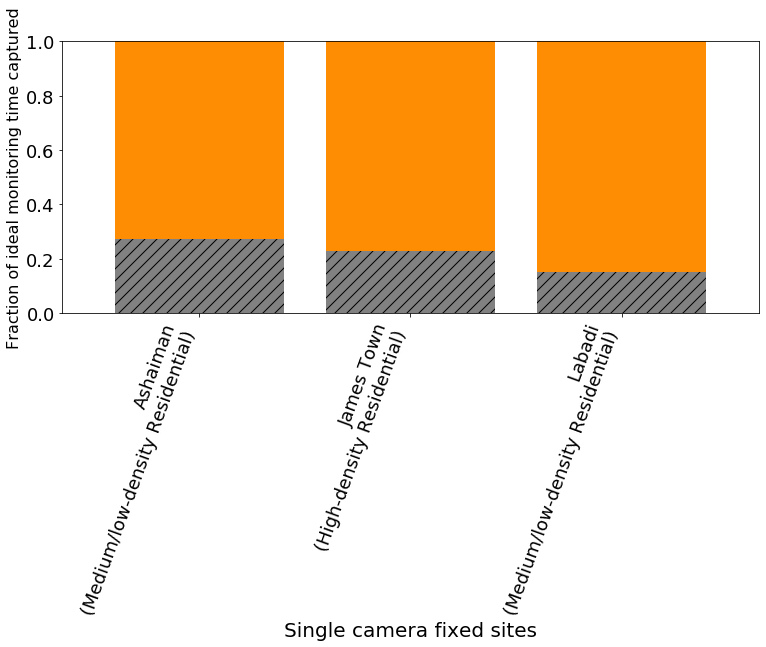

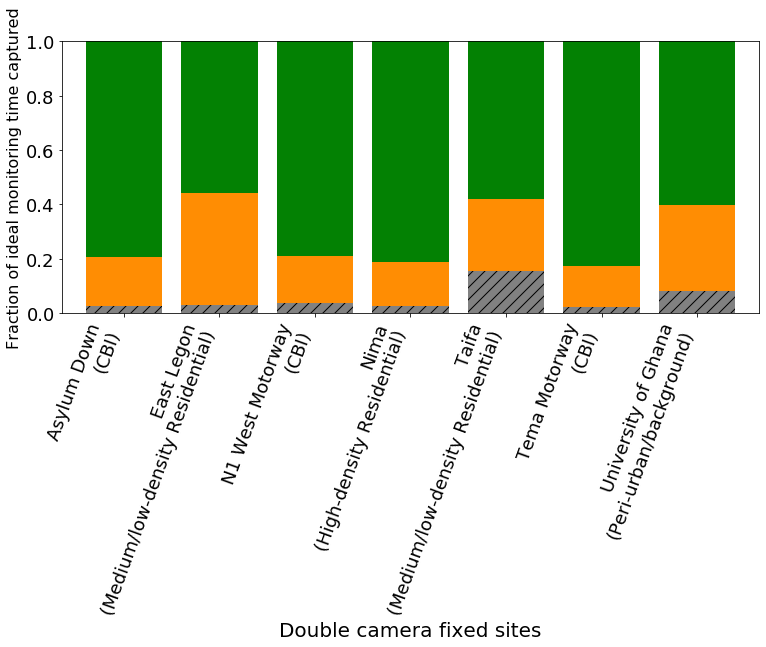

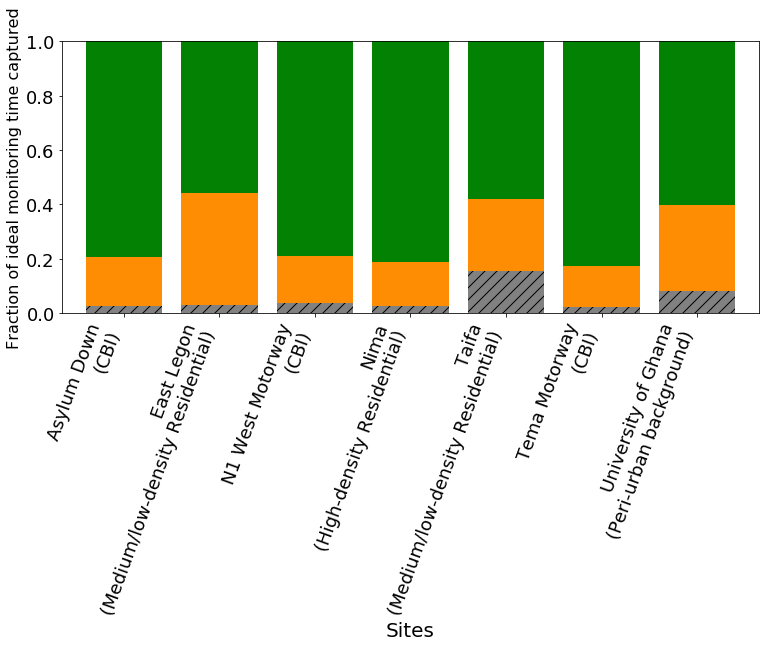

<Figure size 360x360 with 0 Axes>

In [36]:
fig, ax = plt.subplots()

bar_colors = ['grey','darkorange','green']
site_bool_1 = (object_data['long']['observation'].index == 'JT') | (object_data['long']['observation'].index == 'LA') | (object_data['long']['observation'].index == 'ASH')
object_data['long']['observation'][['0_cameras','1_cameras']][site_bool_1].plot.bar(figsize=(12.5,5),ax=ax,colors=bar_colors,stacked=True,ylim = (0,1),width=0.8,alpha=.99,legend=False)
for i in range(0,len(object_data['long']['observation'][site_bool_1])):
    ax.patches[i].set_hatch('//')
#ax.legend(["No Camera", "One Camera"])
ax.set_xticklabels(["Ashaiman\n(Medium/low-density Residential)",
                    "James Town\n(High-density Residential)",
                    "Labadi\n(Medium/low-density Residential)"], rotation=70, ha="right")
ax.set_xlabel("Single camera fixed sites",fontsize=20)
ax.set_ylabel('Fraction of ideal monitoring time captured',fontsize=16)

plt.savefig('results/long_1_cams.pdf', bbox_inches='tight', pad_inches=0.0)

fig, ax = plt.subplots()

site_bool_1 = (object_data['long']['observation'].index != 'JT') & (object_data['long']['observation'].index != 'LA') & (object_data['long']['observation'].index != 'ASH')
object_data['long']['observation'][['0_cameras','1_cameras','2_cameras']][site_bool_1].plot.bar(figsize=(12.5,5),ax=ax,colors=bar_colors,stacked=True,ylim = (0,1),width=0.8,alpha=.99,legend=False)
for i in range(0,len(object_data['long']['observation'][site_bool_1])):
    ax.patches[i].set_hatch('//')
#ax.legend(["No Camera", "One Camera","Two Cameras"])
ax.set_xticklabels(["Asylum Down\n(CBI)",
                    "East Legon\n(Medium/low-density Residential)",
                    "N1 West Motorway\n(CBI)",
                    "Nima\n(High-density Residential)",
                    "Taifa\n(Medium/low-density Residential)",
                    "Tema Motorway\n(CBI)",
                    "University of Ghana\n(Peri-urban/background)"], rotation=70, ha="right")
ax.set_xlabel("Double camera fixed sites",fontsize=20)
ax.set_ylabel('Fraction of ideal monitoring time captured',fontsize=16)

plt.savefig('results/long_2_cams.pdf', bbox_inches='tight', pad_inches=0.0)

fig, ax = plt.subplots()
figlegend = plt.figure(figsize=(5,5))

site_bool_1 = (object_data['long']['observation'].index != 'JT') & (object_data['long']['observation'].index != 'LA') & (object_data['long']['observation'].index != 'ASH')
object_data['long']['observation'][['0_cameras','1_cameras','2_cameras']][site_bool_1].plot.bar(figsize=(12.5,5),ax=ax,colors=bar_colors,stacked=True,ylim = (0,1),width=0.8,alpha=.99,legend=False)
for i in range(0,len(object_data['long']['observation'][site_bool_1])):
    ax.patches[i].set_hatch('//')
#ax.legend(["No Camera", "One Camera","Two Cameras"])
ax.set_xticklabels(["Asylum Down\n(CBI)",
                    "East Legon\n(Medium/low-density Residential)",
                    "N1 West Motorway\n(CBI)",
                    "Nima\n(High-density Residential)",
                    "Taifa\n(Medium/low-density Residential)",
                    "Tema Motorway\n(CBI)",
                    "University of Ghana\n(Peri-urban background)"], rotation=70, ha="right")
ax.set_xlabel("Sites",fontsize=20)
ax.set_ylabel('Fraction of ideal monitoring time captured',fontsize=16)
handles, labels = ax.get_legend_handles_labels() 

lg = figlegend.legend(handles, ["No Camera", "One Camera","Two Cameras"], title= 'Number of cameras operating', loc='center', fontsize = 25)
lg.get_title().set_fontsize(25)
figlegend.savefig(fname='results/'+'cam_legend.pdf', format='pdf', bbox_inches = "tight")

#plt.savefig('../results/long_2_cams.pdf', bbox_inches='tight', pad_inches=0.0)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. tight_lay

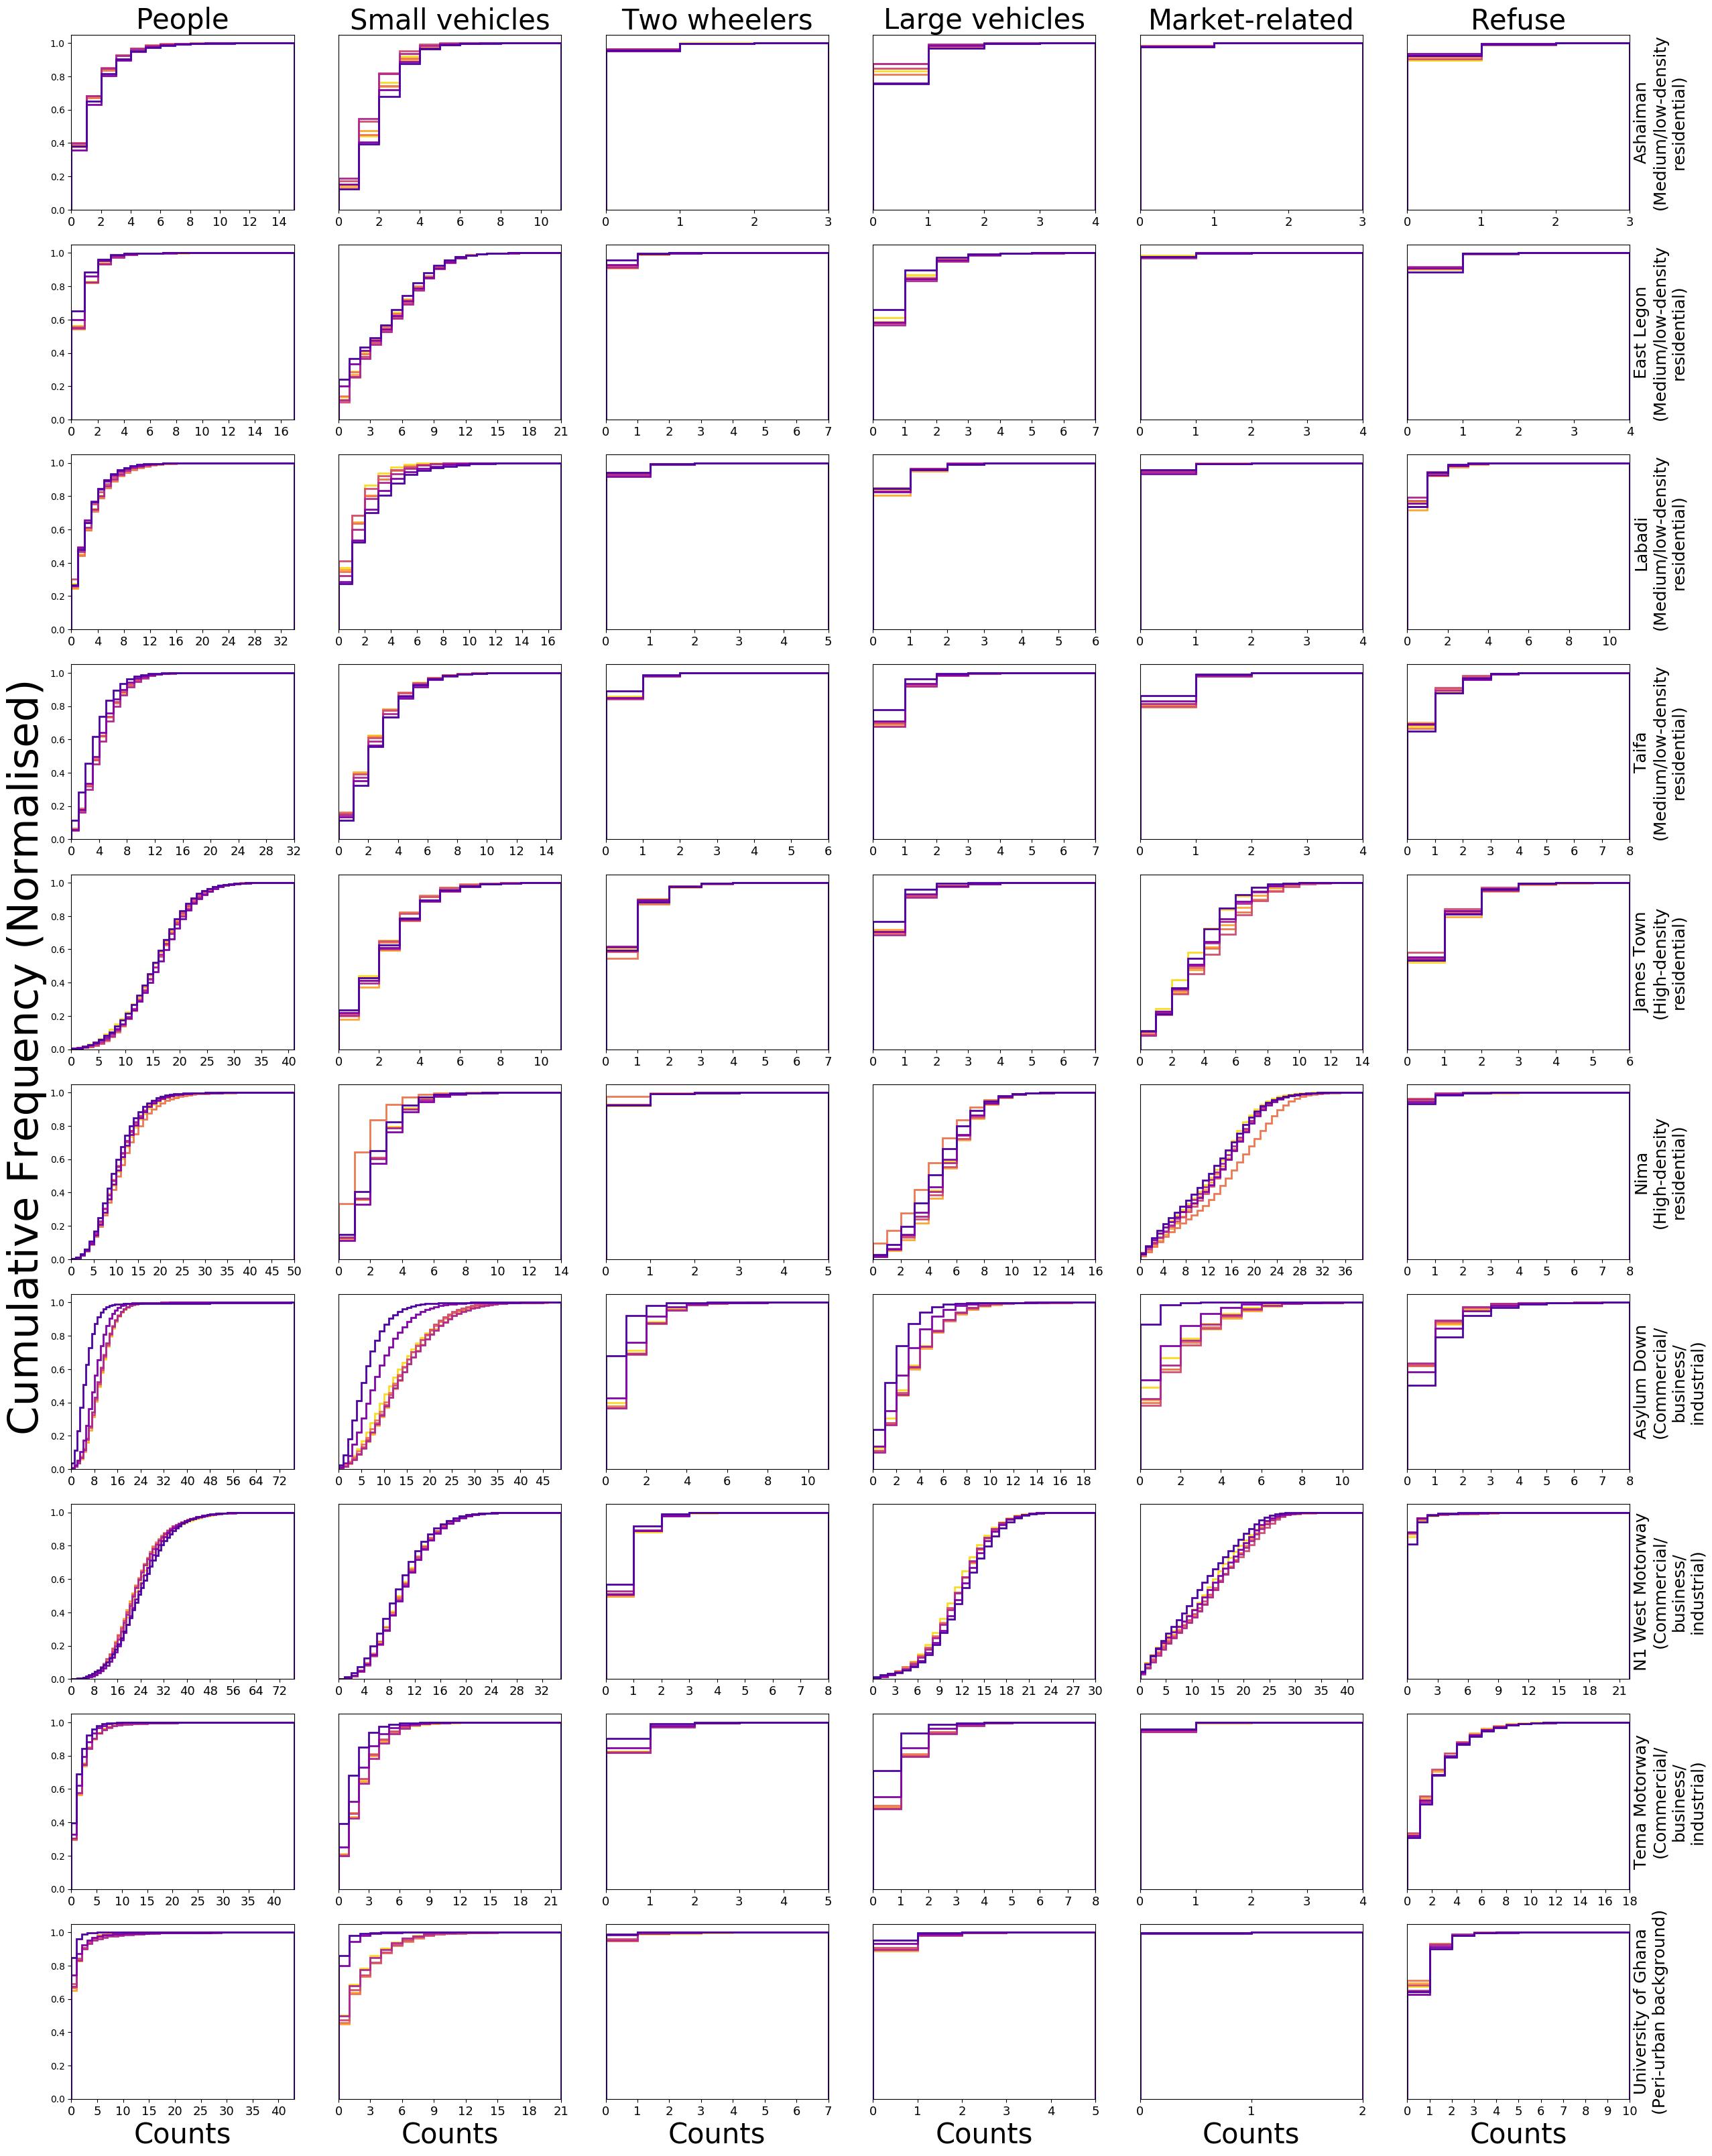

<Figure size 200x1200 with 0 Axes>

In [37]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from pandas import Grouper
import seaborn as sns

week_cols = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
#week_colors = ['red','orange','gold','olivedrab','deepskyblue','blueviolet','fuchsia']

cmap = 'plasma'
week_colors = plt.cm.get_cmap(cmap, 16).colors[1:-1][::-1]

#object_cats = ['two_wheelers','small_vehicles']
object_cats = ['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse']

fig, ax = plt.subplots(10, len(object_cats),figsize=(5*len(object_cats),40), tight_layout=True)

## Uncomment if you want to produce the legend as a separate figure
figlegend = plt.figure(figsize=(2,12))

site_type = {'AD': ['Asylum Down', 'Commercial/\nbusiness/\nindustrial','blue'],
             'ASH' : ['Ashaiman', 'Medium/low-density\nresidential', 'tab:orange'],
             'EL': ['East Legon', 'Medium/low-density\nresidential', 'tab:orange'],
             'JT' : ['James Town', 'High-density\nresidential', 'red'],
             'LA': ['Labadi', 'Medium/low-density\nresidential', 'tab:orange'],
             'N1West': ['N1 West Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'Nima': ['Nima', 'High-density\nresidential', 'red'],
             'Taifa': ['Taifa','Medium/low-density\nresidential', 'tab:orange'],
             'TMW': ['Tema Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'UGH': ['University of Ghana', 'Peri-urban background', 'green']}

for j,site in enumerate(['ASH', 'EL', 'LA', 'Taifa', 'JT', 'Nima', 'AD', 'N1West', 'TMW', 'UGH']):
    site_cam_frame = pd.DataFrame()
    for cam in site_cams[site]:
        date_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2019,4,10), object_data[site][cam].index <= datetime.datetime(2020,6,11))
        site_cam_frame = site_cam_frame.append(object_data[site][cam][date_bool])

    site_cam_frame.sort_index()
    #for i, obj in enumerate(['person']):
    for i, obj in enumerate(object_cats):
        #print(obj)
        if(site_cam_frame[obj+'_counts'].max() > 1):
                time_cut_day = (site_cam_frame['hm'].astype(int) > 600) & (site_cam_frame['hm'].astype(int) < 1800)
                time_cut_night = (site_cam_frame['hm'].astype(int) < 600) | (site_cam_frame['hm'].astype(int) > 1800)
                series=site_cam_frame[obj+'_counts']
                day_series=site_cam_frame[time_cut_day][obj+'_counts']
                night_series=site_cam_frame[time_cut_night][obj+'_counts']

                groups = series.groupby(series.index.weekday_name)
                day_groups = day_series.groupby(day_series.index.weekday_name)
                night_groups = night_series.groupby(night_series.index.weekday_name)

                days = pd.DataFrame()

                for name, group in day_groups:
                    days[name+" day"] = pd.Series(group.astype(float).values)
                for name, group in night_groups:
                    days[name+" night"] = pd.Series(group.astype(float).values)
                for name, group in groups:
                    days[name] = pd.Series(group.astype(float).values)

                bin_max = int(site_cam_frame[obj+'_counts'].max())
                bins=range(0,bin_max+1,1)

                ax[j,i].clear()
                day_night = "day"
                if(j==0):
                    ax[j,i].set_title(obj.replace('market', 'market-related').capitalize().replace("_"," "),fontsize=30)
            
                for index, day in enumerate(week_cols):
                    if(bin_max < 20):
                        #days[[day+' day']].plot.density(lw = 3, alpha=1,ax=ax,color=week_colors[index], bw_method=2)
                        sns.distplot(days[day+" "+day_night], hist = True, kde = False,
                        #kde_kws = {'linewidth': 3,'cumulative': True}, hist_kws={'cumulative': False, "histtype": "stepfilled", "linewidth": 2,"alpha": 0.25},
                        kde_kws = {'linewidth': 3,'cumulative': True}, hist_kws={'cumulative': True, "histtype": "step", "linewidth": 2, "alpha": 1},
                        label = day, bins=bins, norm_hist=True, color=tuple(week_colors[index*2]), ax = ax[j,i]) 
                    else:
                        #days[[day+' day']].plot.density(lw = 3, alpha=1,ax=ax,color=week_colors[index])
                        sns.distplot(days[day+" "+day_night], hist = True, kde = False,
                        #kde_kws = {'linewidth': 3,'cumulative': True}, hist_kws={'cumulative': False, "histtype": "stepfilled", "linewidth": 2,"alpha": 0.25},
                        kde_kws = {'linewidth': 3,'cumulative': True}, hist_kws={'cumulative': True, "histtype": "step", "linewidth": 2, "alpha": 1},
                        label = day, bins=bins, norm_hist=True, color=tuple(week_colors[index*2]), ax = ax[j,i])

## The following may be added to the cumulative frequency graph to show the median and IQR                        
#                 ax[j,i].axhline(0.25, lw=1,color = 'grey',linestyle='dashed')                                
#                 ax[j,i].axhline(0.5, lw=1,color = 'grey',linestyle='dashed')
#                 ax[j,i].axhline(0.75, lw=1,color = 'grey',linestyle='dashed')
                ax[j,i].set_xlim(0,bin_max)

                #ax[j,i].legend(loc='lower right', framealpha=1)
                ax[j,i].legend().remove()
                ax[j,i].tick_params(axis='x', which='major', labelsize=13)
                ax[j,i].xaxis.set_major_locator(MaxNLocator(integer=True))
                ax[j,i].xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
                #ax[j,i].legend(loc='upper right', framealpha=1)
                if(site=='UGH'):
                    ax[j,i].set_xlabel('Counts',fontsize=30)
                else:
                    ax[j,i].xaxis.label.set_visible(False)
                if(i == 0):
                    ax[j,i].get_yaxis().set_visible(True)
                    ax[j,i].get_yaxis().label.set_visible(False)
                elif(i == len(object_cats)-1):
                    ax[j,i].yaxis.set_label_position("right")
                    ax[j,i].set_yticks([], [])
                    ax[j,i].set_ylabel(site_type[site][0]+"\n("+site_type[site][1]+")",color='black',fontsize=18)
                else:
                    ax[j,i].get_yaxis().set_visible(False)
                    #ax[j,i].set_yticks([], [])
                #handles, labels = ax[j,i].get_legend_handles_labels() 
                #ax[j,i].set_ylabel('Frequency')
                #ax[j,i].text(0.70*bin_max, 0.55, site_type[site][1]+":\n"+obj.replace('market', 'market-related').capitalize().replace("_"," "), color=site_type[site][2],fontsize='12',alpha=0.75,horizontalalignment='center', fontweight='bold')
                if(i == 0 and j == 5):
                    ax[j,i].text(-10, -1, 'Cumulative Frequency (Normalised)',fontsize='45',alpha=1,horizontalalignment='center', rotation=90)

#                lg = figlegend.legend(handles, week_cols, title= 'Days of the Week', loc='center', fontsize = 25, ncol = 7)
#lg.get_title().set_fontsize(25)
#figlegend.savefig(fname='../results/day_of_week_hists/cumulative/'+'/'+'legend_'+cmap+'.pdf', format='pdf', bbox_inches = "tight")
fig.show()
fig.savefig(fname='results/day_of_week_hists/cumulative/'+'/'+'objects'+'_'+day_night+'_'+cmap+'.pdf', format='pdf', bbox_inches = "tight")


In [38]:
lockdown_cams_images=[]

num_cams=0
for site in site_cams:
    for cam in site_cams[site]:
        lock_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2020,3,30), object_data[site][cam].index <= datetime.datetime(2020,4,20))
        if(len(object_data[site][cam][lock_bool]) > 1):
            lockdown_cams_images.append(len(object_data[site][cam][lock_bool]))
            num_cams+=1
            print(site+" "+cam+": "+str(len(object_data[site][cam][lock_bool])))
        
            
print(num_cams)

AD C4: 2249
AD C17: 3761
EL C12: 6048
LA C16: 6048
N1West C36: 6048
N1West C15: 5178
Nima C2: 4385
Nima C27: 4618
Taifa C21: 1456
Taifa C22: 1195
TMW C30: 3440
TMW C19: 5308
UGH C33: 493
UGH C25: 4343
14


In [39]:
postlock_total = 0
for site in site_cams:
    for cam in site_cams[site]:
        lock_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2020,3,30), object_data[site][cam].index <= datetime.datetime(2020,4,20))
        if(len(object_data[site][cam][lock_bool]) > 100):
            postlock_bool = object_data[site][cam].index >= datetime.datetime(2020,4,20)
            if(len(object_data[site][cam][postlock_bool]) > 1 and site[0].lower() != 's'):
                lockdown_cams_images.append(len(object_data[site][cam][postlock_bool]))
                postlock_total += len(object_data[site][cam][postlock_bool])
                num_cams+=1
                #print(site+" "+cam+": "+str(len(object_data[site][cam][postlock_bool])))

print("POST-lockdown contributions from each camera:\n")

num_cams=0
for site in site_cams:
    for cam in site_cams[site]:
        lock_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2020,3,30), object_data[site][cam].index <= datetime.datetime(2020,4,20))
        if(len(object_data[site][cam][lock_bool]) > 100):
            postlock_bool = object_data[site][cam].index >= datetime.datetime(2020,4,20)
            if(len(object_data[site][cam][postlock_bool]) > 1 and site[0].lower() != 's'):
                print(site+" "+cam+": "+str(len(object_data[site][cam][postlock_bool])/postlock_total))
        

POST-lockdown contributions from each camera:

AD C4: 0.0874475055200381
AD C17: 0.05815161704645491
EL C12: 0.09163984818091293
LA C16: 0.07537557906282019
N1West C36: 0.07423549276261672
N1West C15: 0.08207178214249636
Nima C2: 0.08941740146912387
Nima C27: 0.08732483800672507
Taifa C21: 0.017555885875918203
Taifa C22: 0.011097802086790873
TMW C30: 0.11595687876120243
TMW C19: 0.0846983100746107
UGH C33: 0.03820732252897118
UGH C25: 0.08681973648131847


In [40]:
prelock_total = 0
for site in site_cams:
    for cam in site_cams[site]:
        lock_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2020,3,30), object_data[site][cam].index <= datetime.datetime(2020,4,20))
        if(len(object_data[site][cam][lock_bool]) > 100):
            prelock_bool = object_data[site][cam].index <= datetime.datetime(2020,3,30)
            if(len(object_data[site][cam][prelock_bool]) > 1 and site[0].lower() != 's'):
                lockdown_cams_images.append(len(object_data[site][cam][prelock_bool]))
                postlock_total += len(object_data[site][cam][prelock_bool])
                num_cams+=1
                #print(site+" "+cam+": "+str(len(object_data[site][cam][postlock_bool])))

print("PRE-lockdown contributions from each camera:\n")

num_cams=0
for site in site_cams:
    for cam in site_cams[site]:
        lock_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2020,3,30), object_data[site][cam].index <= datetime.datetime(2020,4,20))
        if(len(object_data[site][cam][lock_bool]) > 100):
            prelock_bool = object_data[site][cam].index <= datetime.datetime(2020,3,30)
            if(len(object_data[site][cam][prelock_bool]) > 1 and site[0].lower() != 's'):
                print(site+" "+cam+": "+str(len(object_data[site][cam][prelock_bool])/postlock_total))
        

PRE-lockdown contributions from each camera:

AD C4: 0.0630965121636677
AD C17: 0.07115605428611131
EL C12: 0.055767513333024536
LA C16: 0.0479972631036632
N1West C36: 0.06426099329509155
N1West C15: 0.07189309851932933
Nima C2: 0.07602363417252361
Nima C27: 0.05493783068460602
Taifa C21: 0.0647103708705817
Taifa C22: 0.06806566925972968
TMW C30: 0.07307058153358834
TMW C19: 0.07416111445638722
UGH C33: 0.04674826973381083
UGH C25: 0.05549366117580902


In [41]:
lockdown_cams = np.array(lockdown_cams_images)
lockdown_cams = lockdown_cams*5/(60*24)
print("Mean number of days camera operated during lockdown: "+str(np.mean(lockdown_cams)))
print("Standard deviation of number of days camera operated during lockdown: "+str(np.std(lockdown_cams)))

q75, q25 = np.percentile(lockdown_cams, [75 ,25])
print("Median number of days camera operated during lockdown: "+str(np.median(lockdown_cams)))
print("25th and 75th perecentile of number of days camera operated during lockdown: "+str(q25)+", "+str(q75))

Mean number of days camera operated during lockdown: 106.24677579365078
Standard deviation of number of days camera operated during lockdown: 119.28863980709356
Median number of days camera operated during lockdown: 40.125
25th and 75th perecentile of number of days camera operated during lockdown: 16.520833333333332, 236.52430555555554
